In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt

In [3]:
folder = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi"

vocab_en = os.path.join(folder, 'vocab.en.txt')
vocab_vi = os.path.join(folder, 'vocab.vi.txt')

train_en = os.path.join(folder, 'train.en.txt')
train_vi = os.path.join(folder, 'train.vi.txt')

validation_en = os.path.join(folder, 'tst2012.en.txt')
validation_vi = os.path.join(folder, 'tst2012.vi.txt')

test_en = os.path.join(folder, 'tst2013.en.txt')
test_vi = os.path.join(folder, 'tst2013.vi.txt')

In [4]:
def preprocess_sentence(w):
    w = w.lower().strip()
        
    # loại bỏ &apos; và &quot; trong dữ liệu
    w = re.sub(" &apos;", "", w)
    w = re.sub(" &quot;", "", w)
    
    # loại bỏ các kí tự đặc biệt & các dấu câu, chỉ giữ lại chữ, số từ 0-9 và khoảng trắng
    w = re.sub(r"[^\w0-9 ]+", " ", w)
    
    # rút gọn nhiều khoảng trắng dài thành 1 khoảng trắng
    w = re.sub(r"[\s]+", " ", w)
    
    # xóa khoảng trắng phía đầu và đuôi của câu
    w = w.strip()
    
    # thêm <start> và <end> ở đầu và cuối câu để model biết nơi bắt đầu và kết thúc dự đoán
    w = '<start> ' + w + ' <end>'
    
    return w

In [5]:
def create_dataset(input_path, target_path):
  input_lines = open(input_path, encoding='UTF-8').read().strip().split('\n')
  target_lines = open(target_path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = []
  for i in range(len(input_lines)):
    pi = preprocess_sentence(input_lines[i])
    pt = preprocess_sentence(target_lines[i])
    word_pairs.append([pi, pt])
  
  return word_pairs

In [6]:
train_pairs = create_dataset(train_en, train_vi)

In [7]:
def print_samples(pairs, number):
  """
  Hàm in ra một số câu Anh - Việt
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    number: số lượng các cặp câu cần in
    
  Returns:
    None
  """
  
  for i in range(number):
    print(pairs[i][0])
    print(pairs[i][1])

In [8]:
print_samples(train_pairs, 10)

<start> rachel pike the science behind a climate headline <end>
<start> khoa học đằng sau một tiêu đề về khí hậu <end>
<start> in 4 minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule <end>
<start> trong 4 phút chuyên gia hoá học khí quyển rachel pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu cùng với đoàn nghiên cứu của mình hàng ngàn người đã cống hiến cho dự án này một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt <end>
<start> id like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper <end>
<start> tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên

In [9]:
def short_sentences(pairs):
  result = []
  
  for i in range(len(pairs)):
    if len(pairs[i][0].split()) <= 60 and len(pairs[i][1].split()) <= 60:
      result.append([pairs[i][0], pairs[i][1]])
  
  return result

In [10]:
short_train_pairs = short_sentences(train_pairs)

In [11]:
print_samples(short_train_pairs, 10)

<start> rachel pike the science behind a climate headline <end>
<start> khoa học đằng sau một tiêu đề về khí hậu <end>
<start> id like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper <end>
<start> tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo <end>
<start> headlines that look like this when they have to do with climate change and headlines that look like this when they have to do with air quality or smog <end>
<start> có những dòng trông như thế này khi bàn về biến đổi khí hậu và như thế này khi nói về chất lượng không khí hay khói bụi <end>
<start> they are both two branches of the same field of atmospheric science <end>
<start> cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển <end>
<start> recently the headlines looked like this when the intergovernmental panel on climate change or ipcc put out their report on 

In [12]:
val_pairs = create_dataset(validation_en, validation_vi)

In [13]:
print_samples(val_pairs, 10)

<start> how can i speak in 10 minutes about the bonds of women over three generations about how the astonishing strength of those bonds took hold in the life of a four year old girl huddled with her young sister her mother and her grandmother for five days and nights in a small boat in the china sea more than 30 years ago bonds that took hold in the life of that small girl and never let go that small girl now living in san francisco and speaking to you today <end>
<start> làm sao tôi có thể trình bày trong 10 phút về sợi dây liên kết những người phụ nữ qua ba thế hệ về việc làm thế nào những sợi dây mạnh mẽ đáng kinh ngạc ấy đã níu chặt lấy cuộc sống của một cô bé bốn tuổi co quắp với đứa em gái nhỏ của cô bé với mẹ và bà trong suốt năm ngày đêm trên con thuyền nhỏ lênh đênh trên biển đông hơn 30 năm trước những sợi dây liên kết đã níu lấy cuộc đời cô bé ấy và không bao giờ rời đi cô bé ấy giờ sống ở san francisco và đang nói chuyện với các bạn hôm nay <end>
<start> this is not a finis

In [14]:
test_pairs = create_dataset(test_en, test_vi)

In [15]:
print_samples(test_pairs, 10)

<start> when i was little i thought my country was the best on the planet and i grew up singing a song called nothing to envy <end>
<start> khi tôi còn nhỏ tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài chúng ta chẳng có gì phải ghen tị <end>
<start> and i was very proud <end>
<start> tôi đã rất tự hào về đất nước tôi <end>
<start> in school we spent a lot of time studying the history of kim il sung but we never learned much about the outside world except that america south korea japan are the enemies <end>
<start> ở trường chúng tôi dành rất nhiều thời gian để học về cuộc đời của chủ tịch kim ii sung nhưng lại không học nhiều về thế giới bên ngoài ngoại trừ việc hoa kỳ hàn quốc và nhật bản là kẻ thù của chúng tôi <end>
<start> although i often wondered about the outside world i thought i would spend my entire life in north korea until everything suddenly changed <end>
<start> mặc dù tôi đã từng tự hỏi không biết thế giới bên ngoài kia như thế nào 

In [16]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split())
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [18]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [19]:
def load_train_dataset(input_path, target_path):
  # Nhập dữ liệu đầu vào cho tập Train
  pairs = create_dataset(input_path, target_path)
  
  # Cập nhật vocab của từng ngôn ngữ Anh, Việt
  inp_lang = LanguageIndex(en for en, vi in pairs)
  targ_lang = LanguageIndex(vi for en, vi in pairs)
  
  # Lọc ra những cặp câu Anh - Việt có độ dài <= 60 chữ
  pairs = short_sentences(pairs)

  # Chuyển các từ trong câu Tiếng Anh sang index
  input_tensor = [[inp_lang.word2idx[word] for word in en.split()] for en, vi in pairs]

  # Chuyển các từ trong câu Tiếng Việt sang index
  target_tensor = [[targ_lang.word2idx[word] for word in vi.split()] for en, vi in pairs]

  # Tính độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

  # Lấp đầy các câu ngắn bằng index 0
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')

  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')

  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [20]:
input_tensor_train, target_tensor_train, inp_lang, targ_lang, max_length_inp, max_length_targ = load_train_dataset(train_en, train_vi)

In [21]:
print(len(inp_lang.word2idx))
print(len(targ_lang.word2idx))

42916
19823


In [22]:
max_length_inp, max_length_targ

(60, 60)

In [23]:
input_tensor_train[0]

array([  804, 30734, 28670, 38331, 33653,  4190,   806,  7530, 17534,
         803,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [24]:
target_tensor_train[0]

array([  966,  8810,  7882, 19586, 14950, 11495, 16976, 19606, 18357,
        8896,  7856,   965,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [25]:
def load_val_dataset(input_path, target_path, inp_lang, targ_lang):
  # Nhập dữ liệu đầu vào cho tập Validation
  pairs = create_dataset(input_path, target_path)
  
  # Chuyển các từ trong câu Tiếng Anh và Tiếng Việt sang index dựa trên vocab của tập Train
  # Từ nào không có trong vocab của tập Train thì cho index = 0
  
  input_tensor = []
  target_tensor = []
  
  for en, vi in pairs:
    inputs = []
    for word in en.split():
      try:
        index = inp_lang.word2idx[word]
      except:
        index = 0
      inputs.append(index)
    input_tensor.append(inputs)
    
    targets = []
    for word in vi.split():
      try:
        index = targ_lang.word2idx[word]
      except:
        index = 0
      targets.append(index)
    target_tensor.append(targets)

  # Tính độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

  # Lấp đầy các câu ngắn bằng index 0
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
  input_tensor = tf.convert_to_tensor(input_tensor)

  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')
  target_tensor = tf.convert_to_tensor(target_tensor)

  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [26]:
input_tensor_val, target_tensor_val, inp_lang_val, targ_lang_val, max_length_inp_val, max_length_targ_val = load_val_dataset(validation_en, validation_vi, inp_lang, targ_lang)

In [27]:
max_length_inp_val, max_length_targ_val

(92, 119)

In [28]:
input_tensor_val[0]

<tf.Tensor: id=5, shape=(92,), dtype=int32, numpy=
array([  804, 18358,  6189, 18660, 35762, 19091,    31, 24476,   905,
       38331,  5082, 26613, 42297, 27196, 38514, 15939,   905, 18358,
       38331,  3071, 36696, 26613, 38488,  5082, 38880, 18080, 19091,
       38331, 22206, 26613,   806, 15230, 42618, 26690, 16198, 18402,
       42227, 17762, 42717, 34929, 17762, 25034,  2173, 17762, 16615,
       15047, 14686, 10010,  2173, 26035, 19091,   806, 35229,  4976,
       19091, 38331,  7149, 33805, 24949, 38312,   487, 42627,  1578,
        5082, 38322, 38880, 18080, 19091, 38331, 22206, 26613, 38322,
       35229, 16198,  2173, 25905, 22068, 16361, 38322, 35229, 16198,
       26319, 22432, 19091, 33298, 15300,  2173, 35765, 38776, 42713,
       38791,   803], dtype=int32)>

In [29]:
target_tensor_val[0]

<tf.Tensor: id=10, shape=(119,), dtype=int32, numpy=
array([  966,  9937, 14910, 17635,  4380, 16837, 17285,  2833, 17219,
          32, 13409, 18357, 16181,  5159,  9691,  9309, 12266, 11922,
       13470, 12659, 13864,  1833, 16830,  7877, 18357, 18161,  9937,
       16830, 12497, 12266, 16181,  5159, 11412, 11450, 19440,  9039,
       11931, 19728, 19455, 12532,  3793, 10074,  4320, 16162,  4536,
       11495,  4387,  2859,  3029, 17527,  3971, 13981, 18389, 19674,
        5482,  6874, 12232,  4536,  4387,  2859, 18389, 11447, 18215,
        2827, 17219, 15979, 12553, 11872, 19467, 17280,  4067, 16672,
       12232,  9978, 19469, 17280,  2343, 19496,  7809,   553, 12553,
       17326, 12266, 16181,  5159,  9691,  9309, 19455, 12532, 10074,
        4320, 19660,  4387,  2859, 19728, 18215,  8910,  1955,  6550,
       14762, 19366,  4387,  2859, 19728,  6550, 16162, 19796, 14874,
        6025, 18215, 19352, 12537,  3630, 18389,  4345,  2936,  7788,
       11644,   965], dtype=int32)>

In [30]:
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(128111, 128111, 1553, 1553)

## Train

In [31]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [33]:
def gru(units):
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [35]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [36]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [37]:
class LuongAttention(tf.keras.Model):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W = tf.keras.layers.Dense(units)
  
  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, hidden_size)
    score = tf.matmul(values, self.W(hidden_with_time_axis), transpose_b=True)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [39]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
      super(Decoder, self).__init__()
      self.batch_sz = batch_sz
      self.dec_units = dec_units
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      self.gru = gru(self.dec_units)
      self.fc = tf.keras.layers.Dense(vocab_size)

      # used for attention
      self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)

      # x shape after passing through embedding == (batch_size, 1, embedding_dim)
      x = self.embedding(x)

      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

      # passing the concatenated vector to the GRU
      output, state = self.gru(x)

      # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

      # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [40]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [41]:
LEARNING_RATE = 0.001

In [42]:
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

In [44]:
def loss_function(real, pred):

  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  
  return tf.reduce_mean(loss_)

In [45]:
global_step = tf.train.get_or_create_global_step()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [46]:
from fastprogress import master_bar, progress_bar

In [48]:
def epoch_training(encoder, decoder, dataset, global_step, mb, num_step):
    train_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, targ = next(dataset_iter)
        loss = 0
        
        with tf.GradientTape() as tape:
            # Feedforward
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
                
            batch_loss = (loss / int(targ.shape[1]))
            
            train_losses.append(batch_loss)
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables), global_step=global_step) 
        
        mb.child.comment = 'Train loss {:.4f}'.format(loss)
        
    return sum(train_losses)/ len(train_losses)

In [49]:
def epoch_evaluation(encoder, decoder, dataset, mb, num_step):
    val_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, targ = next(dataset_iter)
        loss = 0
        
        # Feed forward
        enc_output, enc_hidden = encoder(inp, hidden)
            
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
        
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)
            
            dec_input = tf.expand_dims(targ[:, t], 1)
            
        batch_loss = (loss / int(targ.shape[1]))
        
        val_losses.append(batch_loss)
        
        mb.child.comment = 'Validation loss {:.4f}'.format(loss)
    
    return sum(val_losses)/ len(val_losses)

Instructions for updating:
Colocations handled automatically by placer.


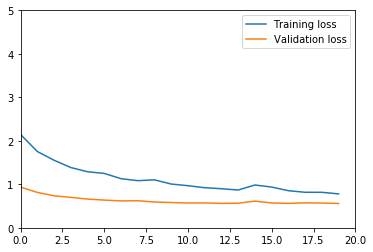

Finish train epoch 0 with loss 2.1455
Finish validate epoch 0 with loss 0.9352
Finish train epoch 1 with loss 1.7541
Finish validate epoch 1 with loss 0.8140
Finish train epoch 2 with loss 1.5531
Finish validate epoch 2 with loss 0.7353
Finish train epoch 3 with loss 1.3857
Finish validate epoch 3 with loss 0.6995
Finish train epoch 4 with loss 1.2893
Finish validate epoch 4 with loss 0.6601
Finish train epoch 5 with loss 1.2504
Finish validate epoch 5 with loss 0.6371
Finish train epoch 6 with loss 1.1299
Finish validate epoch 6 with loss 0.6185
Finish train epoch 7 with loss 1.0839
Finish validate epoch 7 with loss 0.6227
Finish train epoch 8 with loss 1.1024
Finish validate epoch 8 with loss 0.5931
Finish train epoch 9 with loss 1.0062
Finish validate epoch 9 with loss 0.5811
Finish train epoch 10 with loss 0.9680
Finish validate epoch 10 with loss 0.5706
Finish train epoch 11 with loss 0.9219
Finish validate epoch 11 with loss 0.5717
Finish train epoch 12 with loss 0.8985
Finish va

In [50]:
EPOCHS = 20

mb = master_bar(range(EPOCHS))
mb.names = ['Training loss', 'Validation loss']
training_losses = []
validation_losses = []
x = []

train_step = math.floor(len(input_tensor_train)*1.0/BATCH_SIZE)
val_step = math.floor(len(input_tensor_val)*1.0/BATCH_SIZE)

for epoch in mb:
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = encoder.initialize_hidden_state()
    x.append(epoch)
    
    ### START CODE HERE
    # Training
    training_loss = epoch_training(encoder, decoder, train_dataset, global_step, mb, train_step)
    
    # Cập nhật thông tin sau khi huấn luyện
    training_losses.append(training_loss)
    
    # Validating
    valid_loss = epoch_evaluation(encoder, decoder, validation_dataset, mb, val_step)
    
    # Cập nhật thông tin sau khi validate
    validation_losses.append(valid_loss)
    
    # Cập nhật đồ thị
    global_step.assign_add(1)
    mb.update_graph([[x, training_losses], [x, validation_losses]], [0,EPOCHS], [0,5])
    
    print('Finish train epoch {} with loss {:.4f}'.format(epoch, training_loss))
    print('Finish validate epoch {} with loss {:.4f}'.format(epoch,valid_loss))
    
    # Update score và lưu model có score tốt nhất
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    ### END CODE HERE
    

In [ ]:
# khôi phục checkpoint cuối cùng trong folder checkdir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Đánh giá output

In [51]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    # Làm sạch câu Tiếng Anh
    sentence = preprocess_sentence(sentence)
    
    # Chuyển câu Tiếng Anh sang index
    inputs = []
    for word in sentence.split():
      try:
        index = inp_lang.word2idx[word]
      except:
        index = 0
      inputs.append(index)

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    # Dịch
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id]

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        else:
          result += ' '
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [53]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [54]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):

    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Dịch tập Test

Input: <start> i love you <end>
Predicted translation: tôi yêu mến <end>


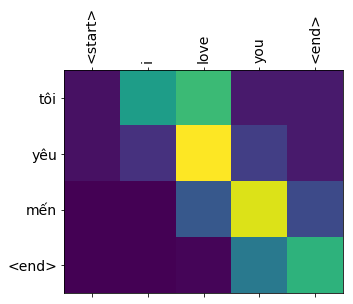

In [55]:
translate(u'i love you', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

In [56]:
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import collections
import math


def _get_ngrams(segment, max_order):
  ngram_counts = collections.Counter()
  for order in range(1, max_order + 1):
    for i in range(0, len(segment) - order + 1):
      ngram = tuple(segment[i:i+order])
      ngram_counts[ngram] += 1
  return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
  matches_by_order = [0] * max_order
  possible_matches_by_order = [0] * max_order
  reference_length = 0
  translation_length = 0
  for (references, translation) in zip(reference_corpus,
                                       translation_corpus):
    reference_length += min(len(r) for r in references)
    translation_length += len(translation)

    merged_ref_ngram_counts = collections.Counter()
    for reference in references:
      merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
    translation_ngram_counts = _get_ngrams(translation, max_order)
    overlap = translation_ngram_counts & merged_ref_ngram_counts
    for ngram in overlap:
      matches_by_order[len(ngram)-1] += overlap[ngram]
    for order in range(1, max_order+1):
      possible_matches = len(translation) - order + 1
      if possible_matches > 0:
        possible_matches_by_order[order-1] += possible_matches

  precisions = [0] * max_order
  for i in range(0, max_order):
    if smooth:
      precisions[i] = ((matches_by_order[i] + 1.) /
                       (possible_matches_by_order[i] + 1.))
    else:
      if possible_matches_by_order[i] > 0:
        precisions[i] = (float(matches_by_order[i]) /
                         possible_matches_by_order[i])
      else:
        precisions[i] = 0.0

  if min(precisions) > 0:
    p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
    geo_mean = math.exp(p_log_sum)
  else:
    geo_mean = 0

  ratio = float(translation_length) / reference_length

  if ratio > 1.0:
    bp = 1.
  else:
    bp = math.exp(1 - 1. / ratio)

  bleu = geo_mean * bp

  return (bleu, precisions, bp, ratio, translation_length, reference_length)

**Tạo tập Test:**

In [57]:
pairs_2 = create_dataset(test_en, test_vi)

**Dịch, tính bleu score và vẽ ma trận attention trên tập Test:**


Input:  <start> when i was little i thought my country was the best on the planet and i grew up singing a song called nothing to envy <end>
Groundtruth:  <start> khi tôi còn nhỏ tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài chúng ta chẳng có gì phải ghen tị <end>
Translation:  <start> khi tôi rất nhỏ tôi nghĩ rằng đất nước tôi là nơi tốt nhất trên hành tinh và tôi lớn lên tiếng hát tựa như không có gì mà không ghen tị <end>
Bleu Score:  61.76470588235294

Input:  <start> and i was very proud <end>
Groundtruth:  <start> tôi đã rất tự hào về đất nước tôi <end>
Translation:  <start> tôi rất tự hào <end>
Bleu Score:  43.459820850707814


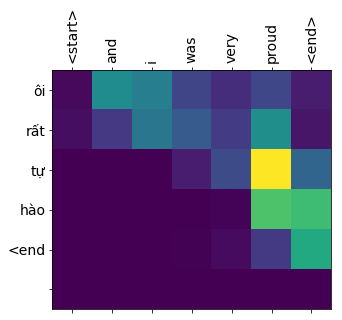


Input:  <start> in school we spent a lot of time studying the history of kim il sung but we never learned much about the outside world except that america south korea japan are the enemies <end>
Groundtruth:  <start> ở trường chúng tôi dành rất nhiều thời gian để học về cuộc đời của chủ tịch kim ii sung nhưng lại không học nhiều về thế giới bên ngoài ngoại trừ việc hoa kỳ hàn quốc và nhật bản là kẻ thù của chúng tôi <end>
Translation:  <start> trong trường chúng tôi dành nhiều thời gian nghiên cứu lịch sử của kim jong il nhưng chúng tôi chưa từng học được nhiều nơi ngoài thế giới ngoại quốc <end>
Bleu Score:  39.80357454364157

Input:  <start> although i often wondered about the outside world i thought i would spend my entire life in north korea until everything suddenly changed <end>
Groundtruth:  <start> mặc dù tôi đã từng tự hỏi không biết thế giới bên ngoài kia như thế nào nhưng tôi vẫn nghĩ rằng mình sẽ sống cả cuộc đời ở bắctriều tiên cho tới khi tất cả mọi thứ đột nhiên thay đổ

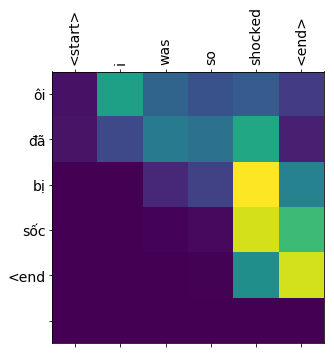


Input:  <start> this was the first time i heard that people in my country were suffering <end>
Groundtruth:  <start> vì đó là lần đầu tiên tôi biết rằng đồng bào của tôi đang phải chịu đựng như vậy <end>
Translation:  <start> đây là lần đầu tiên tôi đã nghe thấy rằng mọi người trong đất nước tôi đang bị đau khổ <end>
Bleu Score:  45.45454545454545

Input:  <start> soon after when i was walking past a train station i saw something terrible that i cant erase from my memory <end>
Groundtruth:  <start> không lâu sau đó khi tôi đi qua một nhà ga tôi nhìn thấy một cảnh tượng kinh hoàng mà tôi không bao giờ có thể quên <end>
Translation:  <start> ngay sau khi tôi đi bộ phim tôi đã thấy một điều tệ hại tôi không thể xoá bỏ ký ức của tôi <end>
Bleu Score:  40.90290187037814

Input:  <start> a lifeless woman was lying on the ground while an emaciated child in her arms just stared helplessly at his mothers face <end>
Groundtruth:  <start> trên nền nhà ga là xác chết của một người đàn bà hai tay 

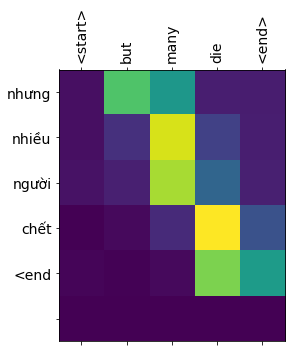


Input:  <start> sometimes i saw dead bodies floating down the river <end>
Groundtruth:  <start> và tôi đã nhìn thấy xác họ nổi trên sông <end>
Translation:  <start> đôi khi tôi thấy những cơ thể sống trên sông <end>
Bleu Score:  50.0

Input:  <start> i cant reveal many details 91 about 93 how i left north korea but i only can say that during the ugly years of the famine i was sent to china to live with distant relatives <end>
Groundtruth:  <start> tôi không thể nói cụ thể về việc mình đã trốn khỏi bắc triều tiên như thế nào chỉ có thể nói rằng trong những năm tháng khốn khó vì nạn đói ấy tôi được gửi sang trung quốc để sống với một người họ hàng xa <end>
Translation:  <start> tôi không thể tiết lộ nhiều chi tiết như thế nào tôi rời khỏi hàn quốc nhưng tôi chỉ có thể nói rằng trong thời kỳ lớn trong những nạn đói tôi đã được đến trung quốc để sống với những ngôi làng <end>
Bleu Score:  52.86361765995735

Input:  <start> but i only thought that i would be separated from my family for a 

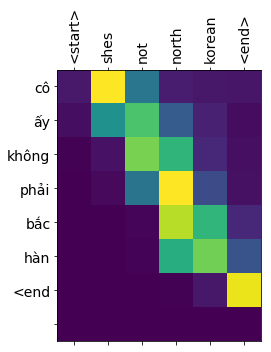


Input:  <start> and they let me go it was a miracle <end>
Groundtruth:  <start> và họ thả tôi ra đó quả là một phép màu <end>
Translation:  <start> và họ để tôi đi tôi đi đó là một phép màu <end>
Bleu Score:  71.42857142857143

Input:  <start> some north koreans in china seek asylum in foreign embassies but many can be caught by the chinese police and repatriated <end>
Groundtruth:  <start> một số người bắc triều tiên ở trung quốc đã đến những đại sứ quán của nước ngoài để xin tị nạn nhưng rất nhiều trong số đó đã bị bắt bởi cảnh sát trung quốc và bị trả về nước <end>
Translation:  <start> một số người hàn quốc ở trung quốc tìm kiếm ở châu phi và có thể bị bắt kịp bởi cảnh sát trung quốc và trung quốc <end>
Bleu Score:  34.04572443821691

Input:  <start> these girls were so lucky <end>
Groundtruth:  <start> những cô gái này đã rất may mắn <end>
Translation:  <start> những cô gái này rất may mắn <end>
Bleu Score:  89.48393168143697


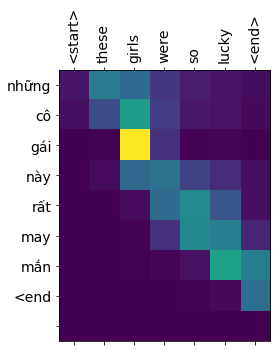


Input:  <start> even though they were caught they were eventually released after heavy international pressure <end>
Groundtruth:  <start> vì mặc dù đã bị bắt nhưng cuối cùng học cũng được thả ra nhờ vào sức ép từ cộng đồng quốc tế <end>
Translation:  <start> ngay cả khi họ bị bắt họ bắt đầu sau khi quá nặng quốc gia <end>
Bleu Score:  18.3716096470669

Input:  <start> these north koreans were not so lucky <end>
Groundtruth:  <start> nhưng những người bắc triều tiên này thì không được may mắn như vậy <end>
Translation:  <start> những người hàn quốc đã không may mắn <end>
Bleu Score:  38.416814526581845


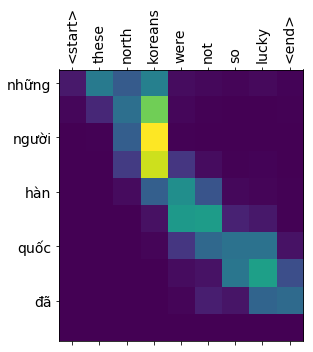


Input:  <start> every year countless north koreans are caught in china and repatriated to north korea where they can be tortured imprisoned or publicly executed <end>
Groundtruth:  <start> hàng năm có vô số người bắc triều tiên bị bắt ở trung quốc và bị trả về nước nơi mà họ bị tra tấn bị giam cầm hoặc bị xử tử công khai <end>
Translation:  <start> mỗi năm tôi đã trở thành nhà nước hàn quốc đang bị kẹt trong trung quốc và trung quốc nơi mà họ có đang bị tra bị bắn súng hay bị giết nô lệ bị giết nô lệ bị giết nô lệ bị giết nô lệ bị giết nô lệ bị giết nô lệ bị giết nô lệ bị giết
Bleu Score:  26.229508196721312

Input:  <start> even though i was really fortunate to get out many other north koreans have not been so lucky <end>
Groundtruth:  <start> trong khi tôi rất may mắn vì đã được thả ra thì rất nhiều đồng bào của tôi lại không được như vậy <end>
Translation:  <start> mặc dù tôi thực sự may mắn được nhiều nước ngoài bắc triều tiên sẽ không may mắn <end>
Bleu Score:  31.1520313228562



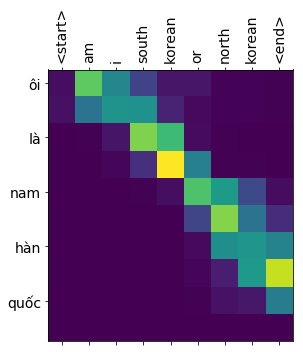


Input:  <start> where am i from who am i <end>
Groundtruth:  <start> tôi đến từ đâu và tôi là ai <end>
Translation:  <start> tôi ở đâu là ai <end>
Bleu Score:  55.8376335026619


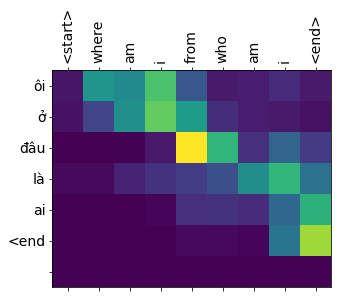


Input:  <start> suddenly there was no country i could proudly call my own <end>
Groundtruth:  <start> bỗng nhiên tôi chẳng có một đất nước nào để có thể tự hào gọi là tổ quốc <end>
Translation:  <start> đột nhiên không có nước tôi có thể tự hào gọi tên mình <end>
Bleu Score:  52.54562944207788

Input:  <start> even though adjusting to life in south korea was not easy i made a plan <end>
Groundtruth:  <start> mặc dù để thích ứng với cuộc sống ở hàn quốc thì không dễ chút nào nhưng tôi đã lập một kế hoạch <end>
Translation:  <start> mặc dù tôi cũng cần phải làm việc trong cuộc sống ở hàn quốc không phải tôi đã tạo ra một kế hoạch <end>
Bleu Score:  60.0

Input:  <start> i started studying for the university entrance exam <end>
Groundtruth:  <start> và bắt đầu học để chuẩn bị cho kì thi đại học <end>
Translation:  <start> tôi bắt đầu nghiên cứu về việc đào tạo chương trình nghiên cứu <end>
Bleu Score:  26.666666666666668

Input:  <start> just as i was starting to get used to my new life 

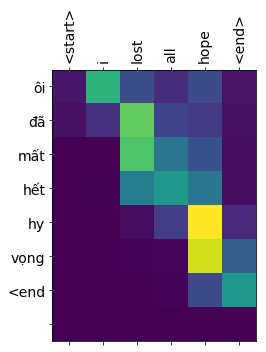


Input:  <start> at that moment i heard one mans voice ask me whats wrong <end>
Groundtruth:  <start> đúng vào lúc đó có một người đàn ông đã hỏi tôi có chuyện gì vậy <end>
Translation:  <start> trong khoảnh khắc đó tôi nghe một người nói tiếng nói tôi là sai <end>
Bleu Score:  33.09363384692233

Input:  <start> i was so surprised that a total stranger cared enough to ask <end>
Groundtruth:  <start> tôi vô cùng ngạc nhiên khi một người hoàn toàn xa lạ lại quan tâm tới mức hỏi tôi như vậy <end>
Translation:  <start> tôi rất ngạc nhiên một điều này nghe một điều kì lạ thường được yêu cầu <end>
Bleu Score:  29.456977215437586

Input:  <start> in my broken english and with a dictionary i explained the situation and without hesitating the man went to the atm and he paid the rest of the money for my family and two other north koreans to get out of jail <end>
Groundtruth:  <start> bằng vốn tiếng anh ít ỏi của mình và một quyển từ điển tôi đã kể cho cho ông ta nghe hoàn cảnh của gia đình tôi k

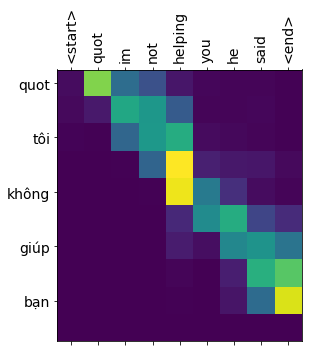


Input:  <start> quot im helping the north korean people <end>
Groundtruth:  <start> quot tôi đang giúp người bắc triều tiên <end>
Translation:  <start> quot tôi đang giúp đỡ người hàn quốc <end>
Bleu Score:  70.0


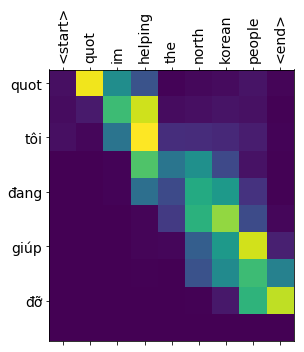


Input:  <start> i realized that this was a symbolic moment in my life <end>
Groundtruth:  <start> tôi nhận ra rằng đó là một khoảng khắc có ý nghĩa vô cùng to lớn trong cuộc đời tôi <end>
Translation:  <start> tôi nhận ra rằng đây là một biểu tượng trong đời tôi <end>
Bleu Score:  44.37070958632394

Input:  <start> the kind stranger symbolized new hope for me and the north korean people when we needed it most and he showed me the kindness of strangers and the support of the international community are truly the rays of hope we north korean people need <end>
Groundtruth:  <start> lòng tốt từ người đàn ông xa lạ trở thành biểu tượng hy vọng mới cho tôi và cả những người dân bắc triều tiên khi mà chúng tôi đang rất cần nó và ông ta đã cho tôi thấy lòng tốt từ những người xa lạ và sự hỗ trợ của cộng đồng quốc tế chính là những tia hy vọng mà người bắc triều tiên chúng tôi đang tìm kiếm <end>
Translation:  <start> người lạ thường có thể hy vọng mới cho tôi và bắc triều tiên khi chúng tôi c

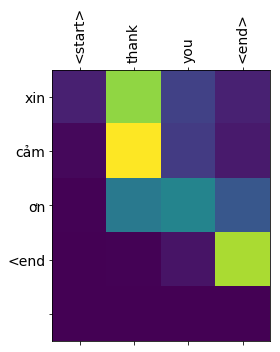


Input:  <start> today i have just one request <end>
Groundtruth:  <start> hôm nay tôi chỉ có một yêu cầu mà thôi <end>
Translation:  <start> hôm nay tôi chỉ có một yêu cầu <end>
Bleu Score:  81.87307530779819


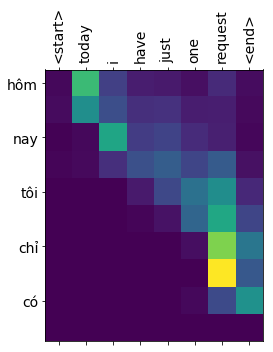


Input:  <start> please dont tell me im normal <end>
Groundtruth:  <start> xin đừng nói với tôi rằng tôi bình thường <end>
Translation:  <start> xin đừng nói với tôi tôi bình thường <end>
Bleu Score:  90.48374180359595


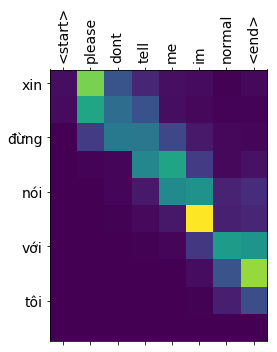


Input:  <start> now id like to introduce you to my brothers <end>
Groundtruth:  <start> bây giờ tôi muốn giới thiệu các bạn với những người em trai của tôi <end>
Translation:  <start> bây giờ tôi muốn giới thiệu với các bạn cho anh em trai của anh <end>
Bleu Score:  82.35294117647058

Input:  <start> remi is 22 tall and very handsome <end>
Groundtruth:  <start> remi 22 tuổi cao ráo và rất đẹp trai <end>
Translation:  <start> được rồi 22 có thể rất tốt và scott <end>
Bleu Score:  45.45454545454545

Input:  <start> hes speechless but he communicates joy in a way that some of the best orators cannot <end>
Groundtruth:  <start> em không nói được nhưng em truyền đạt niềm vui theo cách mà ngay cả một số nhà hùng biện giỏi nhất cũng không thể làm được <end>
Translation:  <start> ông ấy sẽ trao quyền nhưng ông ta giao tiếp niềm vui trong một cách mà một cách tốt nhất <end>
Bleu Score:  29.760157187357052

Input:  <start> remi knows what love is <end>
Groundtruth:  <start> remi biết tình yêu l

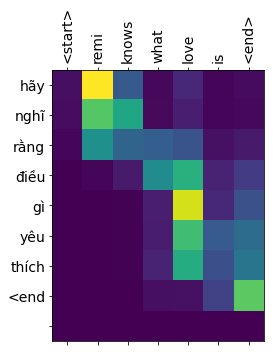


Input:  <start> he shares it unconditionally and he shares it regardless <end>
Groundtruth:  <start> em chia sẻ nó một cách vô điều kiện dù bất kể ra sao chăng nữa <end>
Translation:  <start> ông ấy chia sẻ nó mời và nói với bất cứ ai <end>
Bleu Score:  32.206169703226536

Input:  <start> hes not greedy he doesnt see skin color <end>
Groundtruth:  <start> em ấy không tham lam em không phân biệt màu da <end>
Translation:  <start> anh ta không chỉ là người ta không bị da màu <end>
Bleu Score:  46.15384615384615

Input:  <start> he doesnt care about religious differences and get this he has never told a lie <end>
Groundtruth:  <start> em không quan tâm về sự khác biệt tôn giáo và hãy hiểu rằng em ấy chưa từng nói dối <end>
Translation:  <start> ông ta không quan tâm đến tôn giáo và có điều này ông chưa bao giờ nói dối <end>
Bleu Score:  49.76605799197778

Input:  <start> when he sings songs from our childhood attempting words that not even i could remember he reminds me of one thing how 

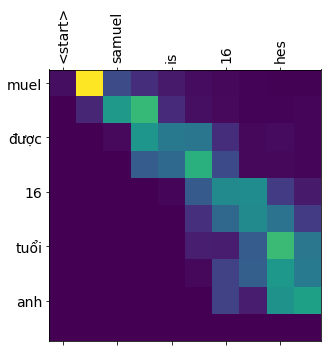


Input:  <start> he has the most impeccable memory <end>
Groundtruth:  <start> em có một trí nhớ cực hoàn hảo <end>
Translation:  <start> ông ấy có bộ nhớ nhất trí não <end>
Bleu Score:  50.0


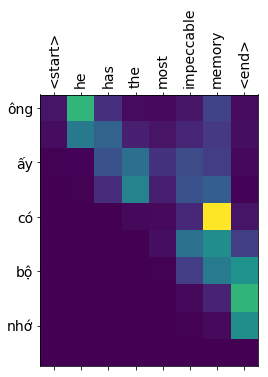


Input:  <start> he has a selective one though <end>
Groundtruth:  <start> nhưng cũng là có chọn lọc <end>
Translation:  <start> ông có một cặp bốt có một cách nào <end>
Bleu Score:  27.27272727272727

Input:  <start> he doesnt remember if he stole my chocolate bar but he remembers the year of release for every song on my ipod conversations we had when he was four weeing on my arm on the first ever episode of teletubbies and lady gagas birthday <end>
Groundtruth:  <start> em không nhớ liệu em có xoáy thanh kẹo sô cô la của tôi không nhưng em lại nhớ năm phát hành của từng bài hát trên ipod của tôi các cuộc nói chuyện giữa chúng tôi từ em mới bốn tuổi tè lên tay của tôi vào ngày teletubbies lên sóng tập đầu tiên và sinh nhật của lady gaga <end>
Translation:  <start> ông không nhớ rằng nếu ông ta cướp đi sô cô la nhưng anh ấy nhớ đến năm <end>
Bleu Score:  5.824207888674845

Input:  <start> dont they sound incredible <end>
Groundtruth:  <start> những chuyện này nghe thật tuyệt vời phải k

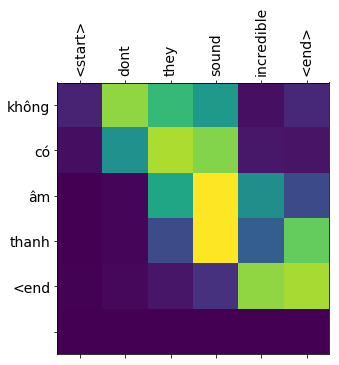


Input:  <start> but most people dont agree <end>
Groundtruth:  <start> nhưng hầu hết mọi người không đồng ý <end>
Translation:  <start> nhưng hầu hết mọi người không đồng ý <end>
Bleu Score:  100.0


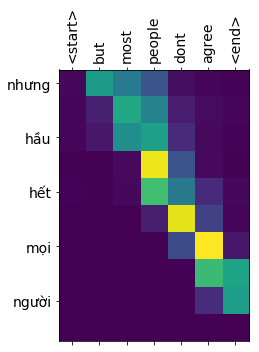


Input:  <start> and in fact because their minds dont fit into societys version of normal theyre often bypassed and misunderstood <end>
Groundtruth:  <start> và thực tế là vì tâm trí của các em tôi không phù hợp với phiên bản xã hội bình thường các em thường bị cho qua và hiểu lầm <end>
Translation:  <start> và thực tế bởi vì trí óc của họ đừng phù hợp với họ sẽ không phải bỏ qua và hiểu lầm <end>
Bleu Score:  47.76875403825262

Input:  <start> but what lifted my heart and strengthened my soul was that even though this was the case although they were not seen as ordinary this could only mean one thing that they were extraordinary autistic and extraordinary <end>
Groundtruth:  <start> nhưng điều khiến trái tim tôi nhẹ nhõm hơn và tâm hồn tôi mạnh mẽ hơn là rằng mặc dù điều này là đúng dù các em không được coi là bình thường điều này chỉ có thể có nghĩa rằng các em thật phi thường người tự kỉ và người phi thường <end>
Translation:  <start> nhưng điều gì đã mất đi xuống và tăng cường tâm 

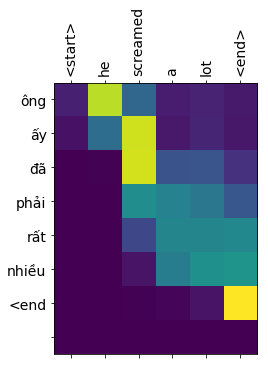


Input:  <start> he didnt want to play like the other babies did and in fact he didnt seem very interested in me whatsoever <end>
Groundtruth:  <start> em không muốn chơi đùa như các em bé khác và trong thực tế em có vẻ chẳng thích thú gì đến tôi hay điều gì khác hết <end>
Translation:  <start> ông không muốn chơi với các em bé khác và thực tế ông ấy không hề quan tâm đến tôi <end>
Bleu Score:  44.23643180720136

Input:  <start> remi lived and reigned in his own world with his own rules and he found pleasure in the smallest things like lining up cars around the room and staring at the washing machine and eating anything that came in between <end>
Groundtruth:  <start> remi sống và ngự trị trong thế giới của riêng mình với quy tắc riêng của mình và em thấy niềm vui trong những điều nhỏ nhặt nhất như là xếp ô tô quanh phòng và nhìn chằm chằm vào cái máy giặt và ăn bất cứ thứ gì trong tầm tay <end>
Translation:  <start> những người sống và sống và trong việc trong thế giới với chính mình 

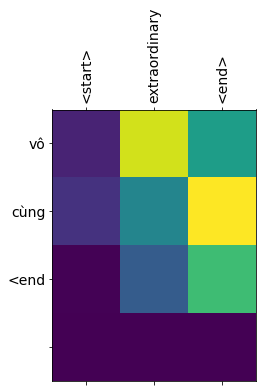


Input:  <start> now i cannot deny that there have been some challenging moments in my family moments where ive wished that they were just like me <end>
Groundtruth:  <start> chà tôi không thể phủ nhận rằng đã có một vài khoảnh khắc khó khăn trong gia đình tôi những khoảnh khắc tôi ước ao các em cũng giống như mình <end>
Translation:  <start> bây giờ tôi không thể phủ nhận rằng có một vài khoảnh khắc mà trong thời điểm mà tôi đã mong muốn họ như tôi <end>
Bleu Score:  53.38249352778721

Input:  <start> but i cast my mind back to the things that theyve taught me about individuality and communication and love and i realize that these are things that i wouldnt want to change with normality <end>
Groundtruth:  <start> nhưng tôi đưa kí ức mình quay trở lại những điều các em đã dạy tôi về tính cách lối giao tiếp và tình yêu và tôi nhận ra rằng đây là những điều mà tôi sẽ chẳng đánh đổi để lấy sự bình thường <end>
Translation:  <start> nhưng tôi suy nghĩ về sự suy nghĩ về những thứ mà họ dạy 

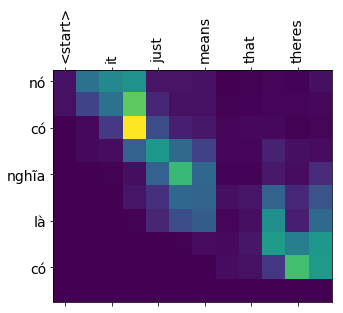


Input:  <start> and if i could communicate just one thing to remi and to sam and to you it would be that you dont have to be normal <end>
Groundtruth:  <start> và nếu tôi chỉ có thể truyền đạt một điều cho remi và cho sam và cho các bạn điều đó là bạn không bắt buộc phải bình thường <end>
Translation:  <start> và nếu tôi có thể giao tiếp chỉ là một thứ để làm việc và sam mời bạn nó sẽ không phải bình thường <end>
Bleu Score:  53.94577091795812

Input:  <start> you can be extraordinary <end>
Groundtruth:  <start> bạn có thể phi thường <end>
Translation:  <start> bạn có thể là phi thường <end>
Bleu Score:  87.5


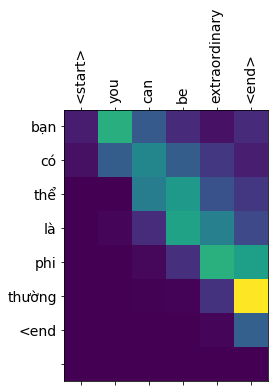


Input:  <start> because autistic or not the differences that we have weve got a gift everyones got a gift inside of us and in all honesty the pursuit of normality is the ultimate sacrifice of potential <end>
Groundtruth:  <start> vì có mắc chứng tự kỷ hay không sự khác biệt giữa chúng ta chúng ta có một món quà ai cũng mang trong mình một món quà và thật lòng mà nói theo đuổi cái bình thường chính là hi sinh tiềm năng lớn nhất <end>
Translation:  <start> bởi vì người tự kỉ hay không phải khác biệt mà chúng ta có một món quà cho chúng ta và tất cả những người duy nhất trong những người trong những người trong những người trong những người trong những người trong những người trong những người trong những người trong những người trong những người trong những người
Bleu Score:  31.147540983606564

Input:  <start> the chance for greatness for progress and for change dies the moment we try to be like someone else <end>
Groundtruth:  <start> cơ hội cho sự vĩ đại tiến bộ và cho sự thay đổi bị

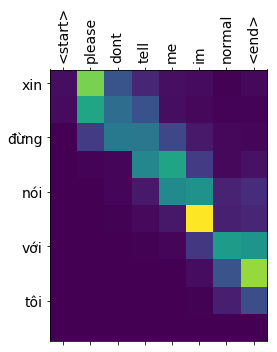


Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn bạn <end>
Translation:  <start> xin cảm ơn <end>
Bleu Score:  80.0


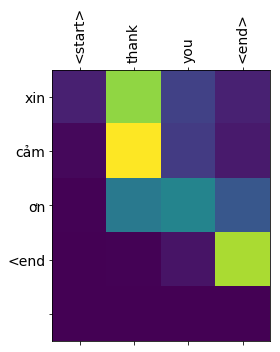


Input:  <start> you probably all agree with me that this is a very nice road <end>
Groundtruth:  <start> có lẽ các bạn đều đồng ý với tôi đây là một con đường rất đẹp <end>
Translation:  <start> bạn có thể đều đồng ý với tôi rằng đây là một con đường rất tốt <end>
Bleu Score:  83.33333333333334

Input:  <start> its made of asphalt and asphalt is a very nice material to drive on but not always especially not on these days as today when its raining a lot <end>
Groundtruth:  <start> nó được xây dựng từ nhựa đường và nhựa đường là loại vật liệu xe mà chạy trên nó thì rất êm nhưng không phải lúc nào cũng được vậy đặc biệt không phải vào những ngày này như hôm nay khi trời đang mưa nhiều <end>
Translation:  <start> nó được làm nhựa đường nhựa và có thể có một vật liệu tuyệt vời để lái trên mặt nhưng không phải không phải không phải không phải không phải không phải không phải không phải không phải không phải không phải không phải không phải không phải không phải không phải không phải không p

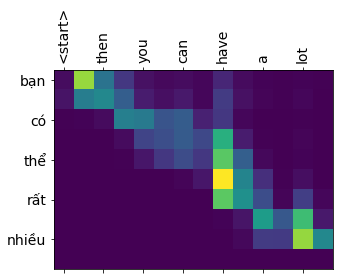


Input:  <start> and especially if you then ride with your bicycle and pass these cars then thats not very nice <end>
Groundtruth:  <start> và đặc biệt nếu như bạn đạp xe đạp và vượt qua những chiếc xe hơi này thì thật không hay <end>
Translation:  <start> và nếu bạn đi xe đạp xe và đi những chiếc xe này thì nó không quá tốt <end>
Bleu Score:  60.24955834975404

Input:  <start> also asphalt can create a lot of noise <end>
Groundtruth:  <start> ngoài ra nhựa đường cũng gây ra nhiều tiếng ồn <end>
Translation:  <start> và nhựa đường có thể tạo ra nhiều tiếng ồn <end>
Bleu Score:  66.66666666666666

Input:  <start> its a noisy material and if we produce roads like in the netherlands very close to cities then we would like a silent road <end>
Groundtruth:  <start> nó là vật liệu gây ồn nếu chúng ta làm những con đường như của hà lan rất gần với các đô thị chúng ta muốn một con đường yên tĩnh <end>
Translation:  <start> nó là một vật liệu thô và nếu chúng ta sản xuất những đường xá như ở hà

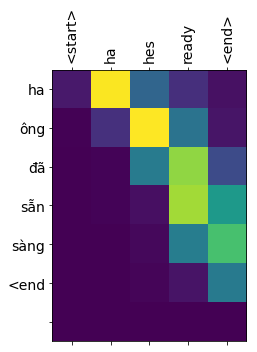


Input:  <start> potholes of course that can become a problem but we have a solution <end>
Groundtruth:  <start> ổ gà đương nhiên có thể trở thành một vấn đề nhưng chúng tôi có giải pháp <end>
Translation:  <start> ổ bánh đó có thể trở thành một vấn đề nhưng chúng ta có một giải pháp <end>
Bleu Score:  78.94736842105263

Input:  <start> here you see actually how the damage appears in this material <end>
Groundtruth:  <start> thật sự như bạn thấy ở đây vật liệu này có dấu hiệu bị hư hại ra sao <end>
Translation:  <start> đây là các bạn thấy rằng những tổn thương có thể xảy ra trong những vật liệu này <end>
Bleu Score:  50.0

Input:  <start> its a porous asphalt like i said so you have only a small amount of binder between the stones <end>
Groundtruth:  <start> nó là nhựa xốp như tôi đã nói bạn chỉ có một lượng nhỏ keo dính bám giữa các viên đá <end>
Translation:  <start> nó là một vòng nhựa đường kính như tôi nói vậy bạn chỉ có một lượng chất dẻo dai <end>
Bleu Score:  56.28111313046319

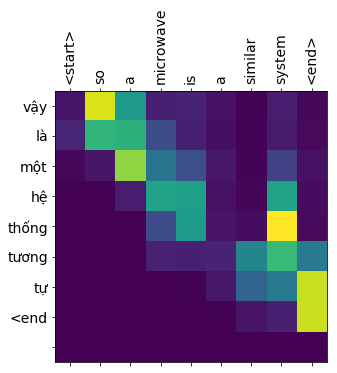


Input:  <start> so i put the specimen in which im now going to take out to see what happened <end>
Groundtruth:  <start> tôi đã để vật mẫu vào lò giờ tôi sẽ lấy nó ra để kiểm tra xem nó ra sao <end>
Translation:  <start> tôi đặt các mẫu vật liệu tôi sẽ lấy đi xem chuyện gì xảy ra <end>
Bleu Score:  43.83463629491062

Input:  <start> so this is the specimen coming out now <end>
Groundtruth:  <start> đây là vật mẫu được lấy ra <end>
Translation:  <start> đây là mẫu của chúng được chụp hình này <end>
Bleu Score:  54.54545454545454

Input:  <start> so i said we have such an industrial machine in the lab to heat up the specimens <end>
Groundtruth:  <start> tôi đã nói chúng tôi phát minh ra một cái máy công nghiệp như trên tại phòng thí nghiệm để đun nóng các vật mẫu <end>
Translation:  <start> tôi nói chúng tôi có một công cụ công nghiệp trong phòng thí nghiệm để làm nóng lên <end>
Bleu Score:  49.32816628030993

Input:  <start> we tested a lot of specimens there and then the government th

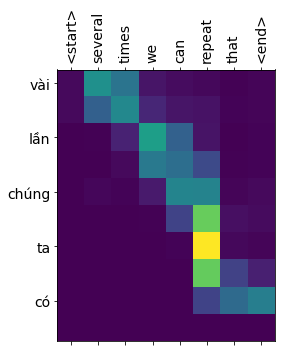


Input:  <start> so actually the conclusion from this research is that if we go on the road every four years with our healing machine this is the big version we have made to go on the real road if we go on the road every four years we can double the surface life of this road which of course saves a lot of money <end>
Groundtruth:  <start> và thật sự kết luận đưa ra từ nghiên cứu này là nếu chúng tôi bảo dưỡng con đường 4 năm một lần bằng máy hàn gắn đây là phiên bản kích thước lớn chúng tôi đã chế tạo nó để bảo dưỡng đường thật nếu cứ 4 năm chúng tôi bảo dưỡng con đường một lần thì chúng tôi có thể làm tăng gấp đôi tuổi thọ lớp mặt của con đường dĩ nhiên sẽ tiết kiệm được nhiều tiền <end>
Translation:  <start> nghiên cứu cách thức ăn hợp chất lượng con số bốn năm với nhau để chữa trị của chúng ta có thể làm ra nhiều bề mặt đất con số bốn năm chúng ta có thể tạo ra nhiều bề mặt đất con số bốn năm chúng ta có thể tạo ra nhiều bề mặt đất con số bốn năm
Bleu Score:  22.85963879878735

Inpu

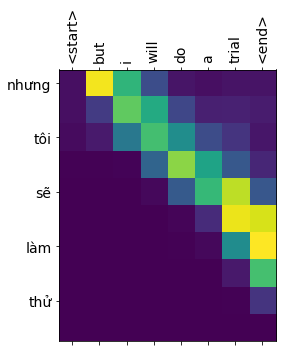


Input:  <start> lets see yeah it worked <end>
Groundtruth:  <start> xem nè vâng nó dính <end>
Translation:  <start> hãy xem nó làm việc đó <end>
Bleu Score:  50.0


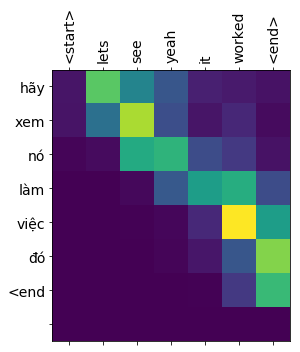


Input:  <start> thank you <end>
Groundtruth:  <start> xin cám ơn <end>
Translation:  <start> xin cảm ơn <end>
Bleu Score:  80.0


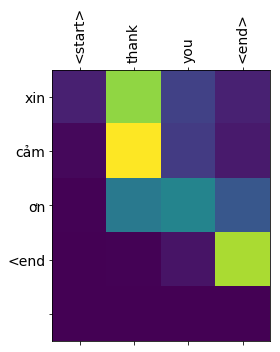


Input:  <start> im here today to talk about a disturbing question which has an equally disturbing answer <end>
Groundtruth:  <start> hôm nay tôi đến đây để nói về một câu hỏi bối rối mà câu trả lời cũng gấy bối rối không kém <end>
Translation:  <start> hôm nay tôi ở đây hôm nay tôi nói về một câu hỏi một chút hỏi sai lầm một cách hoàn toàn sai lầm <end>
Bleu Score:  42.30769230769231

Input:  <start> my topic is the secrets of domestic violence and the question im going to tackle is the one question everyone always asks why does she stay <end>
Groundtruth:  <start> chủ đề là bí mật của bạo lực gia đình và câu hỏi tôi đặt ra là câu hỏi mà mọi người luôn thắc mắc tại sao cô ấy ở lại <end>
Translation:  <start> chủ đề của tôi là bí mật của bạo lực và những câu chuyện tôi sẽ giải quyết được là một câu hỏi mọi người luôn hỏi tại sao cô ấy ở yên <end>
Bleu Score:  71.42857142857143

Input:  <start> why would anyone stay with a man who beats her <end>
Groundtruth:  <start> tại sao người phụ 

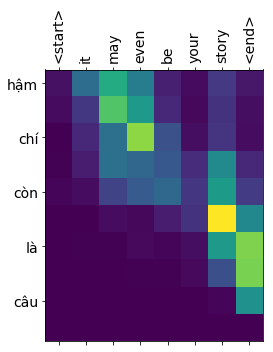


Input:  <start> i dont look like a typical domestic violence survivor <end>
Groundtruth:  <start> tôi không giống môt nhà tư vấn bạo lực gia đình <end>
Translation:  <start> tôi không giống như một tình trạng thiếu thốn như người sống động vật sống động vật <end>
Bleu Score:  26.31578947368421

Input:  <start> i have a b a in english from harvard college an mba in marketing from wharton business school <end>
Groundtruth:  <start> tôi có bằng cử nhân tiếng anh từ trường cao đẳng harvard và quản trị kinh doanh marketing từ trường kinh doanh wharton <end>
Translation:  <start> tôi có một bình luận ở anh từ đại học harvard đến trường đại học harvard business school of design từ trường đại học <end>
Bleu Score:  38.46153846153847

Input:  <start> ive spent most of my career working for fortune 500 companies including johnson amp amp johnson leo burnett and the washington post <end>
Groundtruth:  <start> tôi đã dàng hết sự nghiệp làm việc cho những công ty trong top 500 của mỹ như johnson a

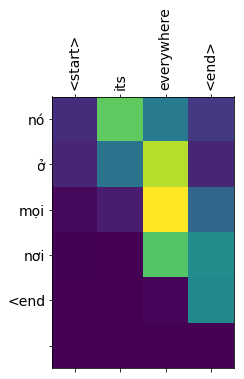


Input:  <start> and my second message is that everyone thinks domestic violence happens to women that its a womens issue <end>
Groundtruth:  <start> và điều thứ hai tôi muốn nói là mọi người nghĩ rằng bạo lực gia đình xảy ra với phụ nữ đó là vấn đề của phụ nữ <end>
Translation:  <start> và lời nhắn nhủ của tôi là người đều nghĩ về bạo lực của phụ nữ xảy ra phụ nữ đó là một vấn đề chính sách <end>
Bleu Score:  66.62793079486872

Input:  <start> not exactly <end>
Groundtruth:  <start> không đúng <end>
Translation:  <start> không phải chính xác <end>
Bleu Score:  50.0


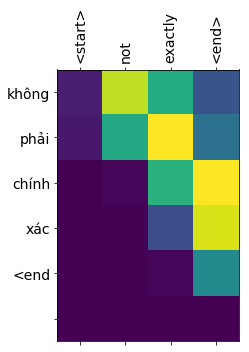


Input:  <start> over 85 percent of abusers are men and domestic abuse happens only in intimate interdependent long term relationships in other words in families the last place we would want or expect to find violence which is one reason domestic abuse is so confusing <end>
Groundtruth:  <start> hơn 85 phần trăm kẻ bạo hành là đàn ông và bạo lực gia đình xảy ra chỉ trong những mối quan hệ thân thiết ràng buộc lâu dài nói cách khác là trong gia đình nơi cuối cùng chúng ta mong muốn hoặc trông chờ tìn thấy bạo lực đó là một lí do khiến bạo hành gia đình là vấn đề gây bối rối <end>
Translation:  <start> hơn 85 trong lồng kẹo bạc và những vụ nổ ra tình trạng phụ thuộc lẫn nhau trong những khác nhau trong gia đình khác mà chúng ta muốn hoặc những điều kiện chống lại là những vụ bạo lực đó là một lý do chính trị gia đình khác mà chúng ta muốn hoặc những điều kiện chống lại
Bleu Score:  35.07876823296299

Input:  <start> i would have told you myself that i was the last person on earth who wou

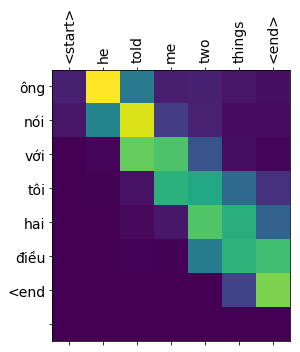


Input:  <start> one was that he too had just graduated from an ivy league school and that he worked at a very impressive wall street bank <end>
Groundtruth:  <start> một là anh ta cũng như tôi vừa tốt nghiệp trường ivy league và rằng anh ta làm việc tại một ngân hàng rất ấn tượng ở phố wall <end>
Translation:  <start> một là ông ấy vẫn chưa tốt nghiệp ở iraq cùng một hội đồng thời gian và ông đã làm việc tại một thị trấn ấn độ <end>
Bleu Score:  41.84022495190481

Input:  <start> but what made the biggest impression on me that first meeting was that he was smart and funny and he looked like a farm boy <end>
Groundtruth:  <start> nhưng điều gây ấn tương nhất với tôi ở cuộc gặp gỡ đầu tiên là anh ta thông minh là vui tính và trông anh ta có vẻ một cậu nhóc nông dân <end>
Translation:  <start> nhưng điều gì khiến tôi gặp gỡ tôi gặp gỡ tôi là người ta là thông minh và ông ấy trông giống như một nông dân <end>
Bleu Score:  47.28433325790672

Input:  <start> he had these big cheeks these bi

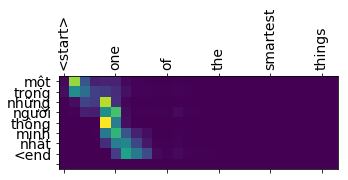


Input:  <start> he did this especially at the beginning by idolizing me <end>
Groundtruth:  <start> anh ta đã làm điều đặt biệt này lúc ban đầu bằng cách tôn sùng tôi <end>
Translation:  <start> ông ấy thực hiện điều này đặc biệt ở đây bắt đầu <end>
Bleu Score:  32.206169703226536

Input:  <start> we started dating and he loved everything about me that i was smart that id gone to harvard that i was passionate about helping teenage girls and my job <end>
Groundtruth:  <start> chúng tôi bắt đầu hẹn hò và anh ta yêu tôi về mọi mặt rằng tôi thông minh rằng tôi chọn học harvard rằng tôi nồng nhiệt giúp đỡ những cô gái mới lớn và công việc <end>
Translation:  <start> chúng tôi bắt đầu hẹn hò và ông yêu thích mọi thứ về tôi rằng tôi đã thông minh rằng tôi đã trở về harvard rằng tôi đã rất thích nghi với gia đình lớn tuổi của tôi <end>
Bleu Score:  57.49999999999999

Input:  <start> he wanted to know everything about my family and my childhood and my hopes and dreams <end>
Groundtruth:  <star

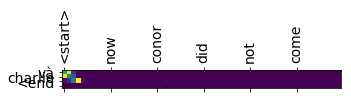


Input:  <start> instead conor came home one friday evening and he told me that he had quit his job that day his dream job and he said that he had quit his job because of me because i had made him feel so safe and loved that he didnt need to prove himself on wall street anymore and he just wanted to get out of the city and away from his abusive dysfunctional family and move to a tiny town in new england where he could start his life over with me by his side <end>
Groundtruth:  <start> thay vì vậy conor đã về nhà vào một tối thứ sáu và anh ấy nói với tôi rằng anh ấy nghỉ việc ngày hôm nay công việc mơ ước của anh ta và anh ta nói rằng anh ta bỏ việc vì tôi bởi vì tôi làm anh cảm thấy thật an toàn và được yêu thương rằng anh ta không cần chứng tỏ bản thân ở phố wall thêm nửa và anh ta chỉ muốn đi khỏi thành phố này xa rời gia đình bất thường và đầy ngược đãi của anh ta đi đến một thị trấn nhỏ ở new england nơi anh ta có thể bắt đầu lại cuộc sống của anh với tôi <end>
Translation:  <start

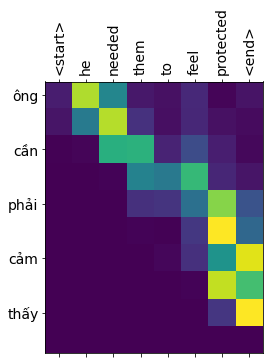


Input:  <start> but those guns were really a message for me and even though he hadnt raised a hand to me my life was already in grave danger every minute of every day <end>
Groundtruth:  <start> nhưng những cây súng này thật ra là một lời nhắn cho tôi và mặc dù anh ta chưa đưa cánh tay về phía tôi nhưng cuộc sống của tôi ở trong tình thế nguy hiểm từng phút mỗi ngày <end>
Translation:  <start> nhưng những người súng đạn này thực sự là một thông điệp cho tôi và thậm chí dù ông chưa từng nuôi dưỡng một cuộc sống của tôi đã bị đe doạ mọi thứ trong mỗi ngày <end>
Bleu Score:  49.85944269612471

Input:  <start> conor first physically attacked me five days before our wedding <end>
Groundtruth:  <start> conor đã tấn công vào tôi năm ngày trước đám cưới của chúng tôi <end>
Translation:  <start> tình cờ đầu tiên đã bị tấn công tôi năm lần trước khi cưới của chúng tôi <end>
Bleu Score:  63.1578947368421

Input:  <start> it was 7 a m i still had on my nightgown <end>
Groundtruth:  <start> đó là 

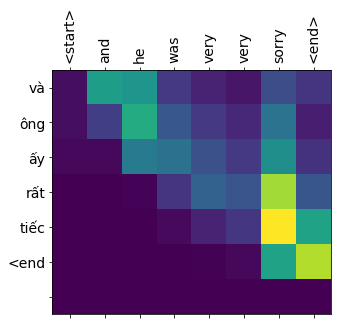


Input:  <start> he had just been really stressed out by the wedding and by becoming a family with me <end>
Groundtruth:  <start> anh ta đã thật sự rất căng thẳng vì đám cưới và việc lập gia đình với tôi <end>
Translation:  <start> ông đã từng bị áp dụng bởi vì đám cưới và trở thành một gia đình với tôi <end>
Bleu Score:  55.00000000000001

Input:  <start> it was an isolated incident and he was never going to hurt me again <end>
Groundtruth:  <start> đó là môt sự cố cá biệt và anh ta sẽ không bao giờ làm đau tôi nữa <end>
Translation:  <start> đó là một sự cố tình dục và ông ấy chưa bao giờ làm tổn thương tôi <end>
Bleu Score:  54.926443579899

Input:  <start> it happened twice more on the honeymoon <end>
Groundtruth:  <start> nó đã xảy ra thêm hai lần trong tuần trăng mật <end>
Translation:  <start> nó đã xảy ra gấp đôi khi chúng ta <end>
Bleu Score:  45.47743189500984

Input:  <start> the first time i was driving to find a secret beach and i got lost and he punched me in the side of 

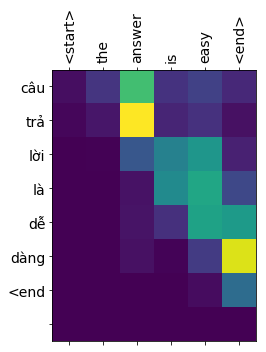


Input:  <start> i didnt know he was abusing me <end>
Groundtruth:  <start> tôi không biết anh ta đang bạo hành tôi <end>
Translation:  <start> tôi không biết ông ấy đang tiếp tục giữ tôi <end>
Bleu Score:  58.333333333333336

Input:  <start> even though he held those loaded guns to my head pushed me down stairs threatened to kill our dog pulled the key out of the car ignition as i drove down the highway poured coffee grinds on my head as i dressed for a job interview i never once thought of myself as a battered wife <end>
Groundtruth:  <start> thậm chí anh ta chĩa súng vào đầu tôi đẩy tôi xuống sàn đe doạ giết lũ chó của tôi rút chìa khoá ra khỏi xe khi tôi đang lái xe vào đường cao tốc đổ grinds cafe lên đầu tôi khi tôi đang mặc đồ cho buổi phỏng vấn tôi chưa bao giờ một lần nghĩ bản thân như một người vợ bị hành hạ <end>
Translation:  <start> ngay cả khi ông ấy giữ những khẩu súng vào đầu tôi lên xuống hạ thấp bị giết chết chó đi bộ phận làm việc làm phim <end>
Bleu Score:  11.68138

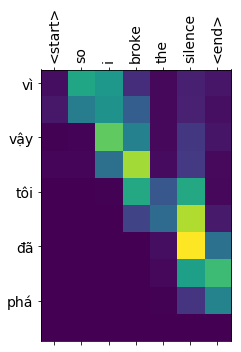


Input:  <start> i told everyone the police my neighbors my friends and family total strangers and im here today because you all helped me <end>
Groundtruth:  <start> tôi kể với mọi người cánh sát những người láng giềng bạn bè và gia đình tôi những người hoàn toàn xa lạ và tôi đứng đây hôm nay bởi vì bạn đều đang giúp tôi <end>
Translation:  <start> tôi nói với mọi người cảnh sát những người bạn bè của bạn bè và gia đình và người ở đây hôm nay bởi vì tất cả các bạn giúp đỡ tôi <end>
Bleu Score:  62.753630499019465

Input:  <start> we tend to stereotype victims as grisly headlines self destructive women damaged goods <end>
Groundtruth:  <start> chúng ta có quan niệm rập khuôn về nạn nhân như những tiêu đề đáng sợ những phụ nữ tự huỷ hoại mình những điều tốt bị làm tổn thương <end>
Translation:  <start> chúng ta có xu hướng về những nạn nhân như tạp chí popular king tự nhiên bị tàn tật <end>
Bleu Score:  33.84342950262245

Input:  <start> the question why does she stay <end>
Groundtruth:

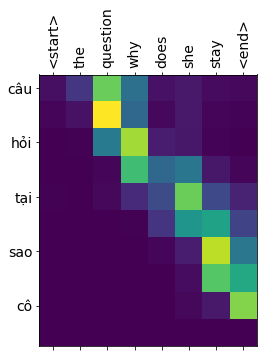


Input:  <start> is code for some people for its her fault for staying as if victims intentionally choose to fall in love with men intent upon destroying us <end>
Groundtruth:  <start> là lí lẽ của một số người đấy là lỗi của cô ấy khi ở lại như thể nạn nhân đã lựa chọn yêu đàn ông với ý định phá huỷ chúng ta <end>
Translation:  <start> có mã cho một số người cho con đường cho cô ấy vì khi nạn nhân chọn lọc yêu mến ông ta <end>
Bleu Score:  36.88630529419791

Input:  <start> but since publishing crazy love i have heard hundreds of stories from men and women who also got out who learned an invaluable life lesson from what happened and who rebuilt lives joyous happy lives as employees wives and mothers lives completely free of violence like me <end>
Groundtruth:  <start> nhưng từ khi xuất bản crazy love tôi đã nghe hàng trăm câu chuyện từ đàn ông và phụ nữ những người cũng đã bỏ đi những người học được một bài học cuộc sống vô giá từ nhưng điều đã xảy ra và những ai xây dựng lại cuộc sốn

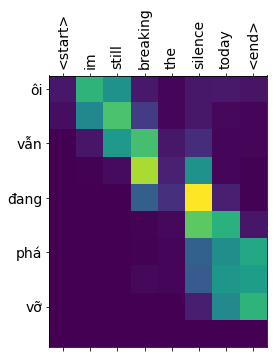


Input:  <start> its my way of helping other victims and its my final request of you <end>
Groundtruth:  <start> đây là cách tôi giúp những nạn nhân khác và đây là yêu cầu cuối cùng của tôi <end>
Translation:  <start> đó là cách tôi giúp đỡ những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác những người khác
Bleu Score:  11.475409836065573

Input:  <start> talk about what you heard here <end>
Groundtruth:  <start> hãy kể về những gì bạn được nghe ở đây <end>
Translation:  <start> nói về những gì bạn nghe <end>
Bleu Score:  53.07143272485543


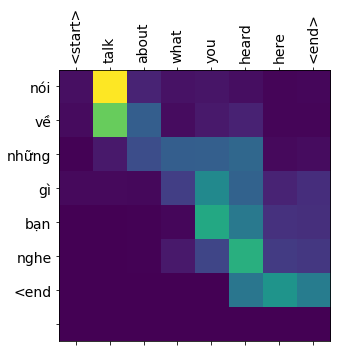


Input:  <start> abuse thrives only in silence <end>
Groundtruth:  <start> sự ngược đãi chỉ đáng sợ trong im lặng <end>
Translation:  <start> lạm dụng mạnh chỉ phát triển trong sự tĩnh lặng <end>
Bleu Score:  50.0

Input:  <start> you have the power to end domestic violence simply by shining a spotlight on it <end>
Groundtruth:  <start> bạn có sức mạnh để kết thúc bạo lực gia đình đơn giản bằng cách rọi vào đó một tia sáng <end>
Translation:  <start> bạn có quyền lực lượng bạo lực gia đình chỉ bằng tia sáng <end>
Bleu Score:  43.020722764069

Input:  <start> we victims need everyone <end>
Groundtruth:  <start> chúng ta những nạn nhân cần đến tất cả mọi người <end>
Translation:  <start> chúng ta là nạn nhân chúng ta đều có thể mọi người đều có thể <end>
Bleu Score:  47.05882352941176

Input:  <start> we need every one of you to understand the secrets of domestic violence <end>
Groundtruth:  <start> chúng ta cần các bạn để thấu hiểu bí mật của bạo lực gia đình <end>
Translation:  <start>

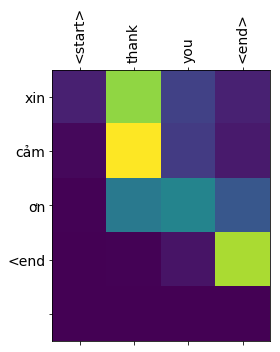


Input:  <start> i would like to talk to you about a very special group of animals <end>
Groundtruth:  <start> tôi muốn nói chuyện với các bạn về một nhóm động vật rất đặc biệt <end>
Translation:  <start> tôi muốn nói với các bạn về một nhóm đặc biệt <end>
Bleu Score:  73.51414805916845

Input:  <start> there are 10 000 species of birds in the world <end>
Groundtruth:  <start> hiện có khoảng 10 000 loài chim trên thế giới <end>
Translation:  <start> có 10 000 loài chim trong thế giới <end>
Bleu Score:  73.68576777701837


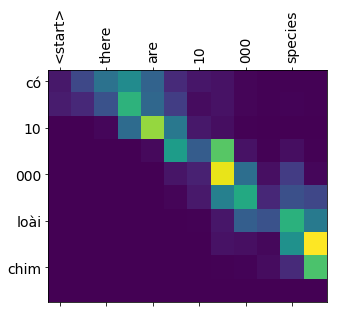


Input:  <start> vultures are amongst the most threatened group of birds <end>
Groundtruth:  <start> kền kền là một trong những nhóm chim bị đe doạ nghiêm trọng nhất <end>
Translation:  <start> chim nhại lại là những người bị đe doạ sát hại nhất của chim <end>
Bleu Score:  56.25

Input:  <start> when you see a vulture like this the first thing that comes to your mind is these are disgusting ugly greedy creatures that are just after your flesh associated with politicians <end>
Groundtruth:  <start> khi bạn thấy một con kền lền như thế này điều đầu tiên hiện ra trong đầu bạn đó là đây là những sinh vật thật kinh tởm xấu xí tham ăn và chỉ nhắm đến thịt bạn liên tưởng đến những chính trị gia nhỉ <end>
Translation:  <start> khi bạn thấy một cái gì đó như thế này đầu tiên là đầu tiên của bạn là những thứ tuyệt đẹp tình dục tuyệt vời như là khi bạn bị tổn thương nhất là khi bạn bị tổn thương nhất là khi bạn bị tổn thương nhất là khi bạn bị tổn thương nhất là khi bạn bị tổn
Bleu Score:  27.868

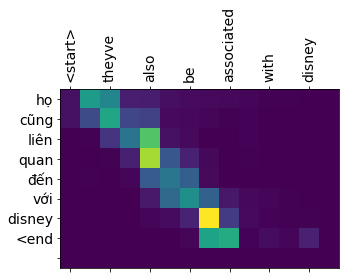


Input:  <start> more recently if youve been following the kenyan press these are the attributes that they associated the kenyan mps with but i want to challenge that <end>
Groundtruth:  <start> gần đây hơn nếu bạn đang theo dõi tin tức ở kenya đây là những thuộc tính đặc trưng mà gắn kết với những quân cảnh keya nhưng tôi muốn phản kháng lại điều đó <end>
Translation:  <start> gần đây nếu bạn đã theo dõi năm 1957 sẽ là những thuộc tính rằng chúng liên quan đến từ kenya với tôi nhưng tôi muốn thách thức đó <end>
Bleu Score:  47.84690106655459

Input:  <start> i want to challenge that do you know why <end>
Groundtruth:  <start> tôi muốn phản kháng lại vì bạn biết sao không <end>
Translation:  <start> tôi muốn thử thách mà bạn biết tại sao <end>
Bleu Score:  58.10640921796214

Input:  <start> because mps do not keep the environment clean <end>
Groundtruth:  <start> vì quân cảnh không giữ cho môi trường trong sạch <end>
Translation:  <start> bởi vì việc không làm cho môi trường sạch <end>

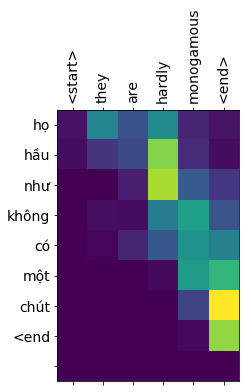


Input:  <start> they are far from being extinct <end>
Groundtruth:  <start> họ còn lâu mới bị tuyệt chủng <end>
Translation:  <start> chúng gần như bị bắt bị <end>
Bleu Score:  33.09363384692233


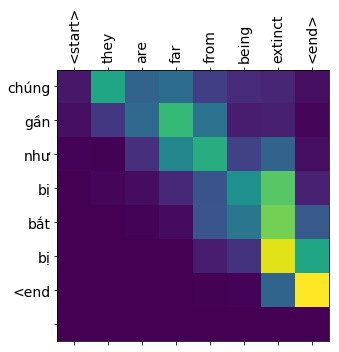


Input:  <start> and my favorite is vultures are better looking <end>
Groundtruth:  <start> và điều mà tôi thích nhất là những con kền kền trông được hơn nhiều <end>
Translation:  <start> và yêu thích của tôi là chim bồ câu hỏi chim nhại hơn <end>
Bleu Score:  40.84142155533755

Input:  <start> so theres two types of vultures in this planet <end>
Groundtruth:  <start> có hai loại kền kền trên hành tinh này <end>
Translation:  <start> vậy nên có hai loại thuốc săn chim ở thế giới này <end>
Bleu Score:  42.857142857142854

Input:  <start> there are the new world vultures that are mainly found in the americas like the condors and the caracaras and then the old world vultures where we have 16 species from these 16 11 of them are facing a high risk of extinction <end>
Groundtruth:  <start> những loại kền kền tân thế giới được tìm thấy chủ yếu tại mỹ giống như loài condor và caracaras tiếp đó kền kền cựu thế giới nơi mà có khoảng 16 loài trong số 16 loài này thì có 11 loài đối mặt với nguy c

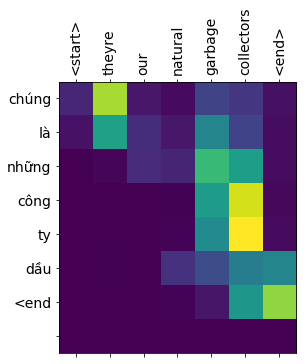


Input:  <start> they clean up carcasses right to the bone <end>
Groundtruth:  <start> chúng dọn sạch những xác chết đến tận xương <end>
Translation:  <start> họ dọn dẹp để xác là xương <end>
Bleu Score:  44.48541127315601


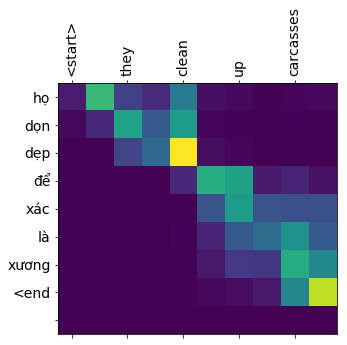


Input:  <start> they help to kill all the bacteria they help absorb anthrax that would otherwise spread and cause huge livestock losses and diseases in other animals <end>
Groundtruth:  <start> chúng giúp tiêu diệt vi khuẩn chúng giúp hấp thụ bệnh than mà đã có thể lan rộng và gây ra những mất mát to lớn cho ngành chăn nuôi gia súc và gây bệnh cho những loài vật khác <end>
Translation:  <start> họ giúp đỡ giết chết vi khuẩn này giúp hấp thụ những bệnh than phiền toái gì đó là những động vật và những bệnh khác <end>
Bleu Score:  34.65889484072191

Input:  <start> recent studies have shown that in areas where there are no vultures carcasses take up to three to four times to decompose and this has huge ramifications for the spread of diseases <end>
Groundtruth:  <start> những nghiên cứu gần nhất đã cho thấy tại những khu vực mà không có kền kền xác chết cần khoảng thời gian gấp 3 đến 4 lần để phân huỷ và hệ quả to lớn từ việc này là sự lây lan của bệnh tật <end>
Translation:  <start> nhữ

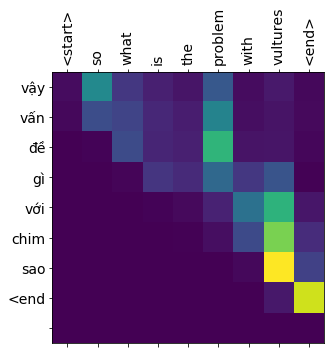


Input:  <start> we have eight species of vultures that occur in kenya of which six are highly threatened with extinction <end>
Groundtruth:  <start> chúng ta có 8 loài kền kền xuất hiện tại kenya trong đó có 6 loài bị đe doạ với nguy cơ tuyệt chủng cao <end>
Translation:  <start> chúng tôi có 8 loài chim chóc sẽ xảy ra ở kenya có 6 đe doạ nguy hiểm tuyệt chủng <end>
Bleu Score:  50.699311720493

Input:  <start> the reason is that theyre getting poisoned and the reason that theyre getting poisoned is because theres human wildlife conflicts the pastoral communities are using this poison to target predators and in return the vultures are falling victim to this <end>
Groundtruth:  <start> lí do là chúng đang bị đầu độc chúng bị đầu độc vì có những sự tranh giành giữa con người và thế giới hoang dã những cộng đồng mục đồng đang sử dụng chất độc này để nhằm vào các con vật săn mồi nhưng thay vì vậy những con kền kền lại là nạn nhân cho này <end>
Translation:  <start> lý do là chúng được tạo

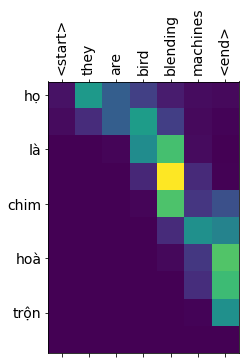


Input:  <start> in west africa theres a horrific trade of dead vultures to serve the witchcraft and the fetish market <end>
Groundtruth:  <start> tại tây phi có một ngành buôn bán kền kền chết thật kinh khủng để phục vụ cho thị trường ma thuật và bùa ngải <end>
Translation:  <start> ở tây phi có một sự nổi loạn về những người chết người chết do thái đánh cắp và thờ ơ và sai lệch <end>
Bleu Score:  29.60826813425406

Input:  <start> so whats being done well were conducting research on these birds were putting transmitters on them <end>
Groundtruth:  <start> vậy chúng tôi đã làm được gì chúng tôi đang tiến hành nghiên cứu về những chú chim này chúng tôi đang gắn máy phát tín hiệu vào chúng <end>
Translation:  <start> vậy nên làm gì chúng tôi đã được dạy chúng tôi đang dạy nghiên cứu trên những loài chim này đang truyền tải những gì chúng <end>
Bleu Score:  60.962675377190536

Input:  <start> were trying to determine their basic ecology and see where they go <end>
Groundtruth:  <start> c

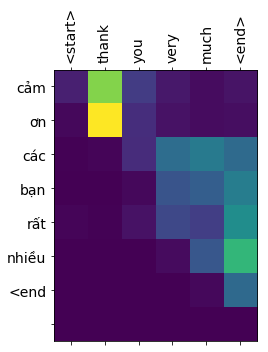


Input:  <start> when i was 11 i remember waking up one morning to the sound of joy in my house <end>
Groundtruth:  <start> khi tôi 11 tuổi tôi nhớ một buổi sáng tôi thức dậy khi nghe tiếng hân hoan trong căn nhà của tôi <end>
Translation:  <start> khi tôi 11 tuổi tôi nhớ về một sáng sớm cho một trong một trong một trong một trong một trong một ngôi mộ của tôi <end>
Bleu Score:  46.42857142857143

Input:  <start> my father was listening to bbc news on his small gray radio <end>
Groundtruth:  <start> bố tôi lúc ấy đang nghe tin tức bbc trên chiếc radio màu xám nhỏ của ông ấy <end>
Translation:  <start> bố tôi nghe nói về đài thông tin về radio <end>
Bleu Score:  29.94933194356787

Input:  <start> there was a big smile on his face which was unusual then because the news mostly depressed him <end>
Groundtruth:  <start> ông ấy nở một nụ cười rất lớn điều này rất bất thường vì tin tức thường làm ông ấy buồn rầu hơn <end>
Translation:  <start> có một nụ cười lớn lên trán của ông ta thấy thườ

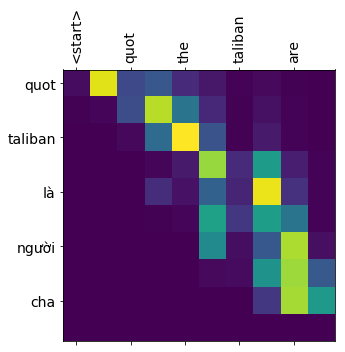


Input:  <start> i didnt know what it meant but i could see that my father was very very happy <end>
Groundtruth:  <start> lúc đó tôi không hiểu rõ nhưng tôi có thể thấy rằng bố tôi rất rất vui mừng <end>
Translation:  <start> tôi không biết nó có nghĩa là gì nhưng tôi có thể thấy rằng bố tôi rất hạnh phúc <end>
Bleu Score:  61.904761904761905

Input:  <start> quot you can go to a real school now he said <end>
Groundtruth:  <start> quot bây giờ con có thể thật sự đến trường rồi ông nói <end>
Translation:  <start> quot bạn có thể đến trường thật là anh ta nói <end>
Bleu Score:  59.35873286495364

Input:  <start> a morning that i will never forget <end>
Groundtruth:  <start> một buổi sáng mà tôi không thể nào quên được <end>
Translation:  <start> sáng nay tôi sẽ không bao giờ quên đi <end>
Bleu Score:  49.80549361539612

Input:  <start> a real school <end>
Groundtruth:  <start> một ngôi trường thật sự <end>
Translation:  <start> một trường học thực sự <end>
Bleu Score:  71.42857142857143

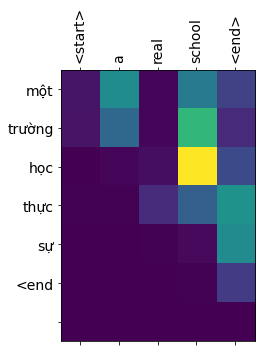


Input:  <start> you see i was six when the taliban took over afghanistan and made it illegal for girls to go to school <end>
Groundtruth:  <start> bạn biết không bọn taliban đến xâm lấn afghanistan từ khi tôi 6 tuổi và ngăn cấm các cô gái đi học <end>
Translation:  <start> bạn thấy đấy tôi 6 tuổi khi tôi đã vượt qua afghanistan và làm điều kiện bất kỳ những người mẹ đi đến trường <end>
Bleu Score:  42.30769230769231

Input:  <start> so for the next five years i dressed as a boy to escort my older sister who was no longer allowed to be outside alone to a secret school <end>
Groundtruth:  <start> trong 5 năm sau đó tôi đã ăn mặc như 1 thằng con trai để đi cùng với chị tôi tới một trường bí mật vì chị tôi bị cấm ra khỏi nhà môt mình <end>
Translation:  <start> vì thế trong năm năm tôi thức ăn mặc một cậu bé để tải lên người già đi tôi chưa từng được phép mình ngoài một mình một trường trung học <end>
Bleu Score:  37.581346851478465

Input:  <start> it was the only way we both could be ed

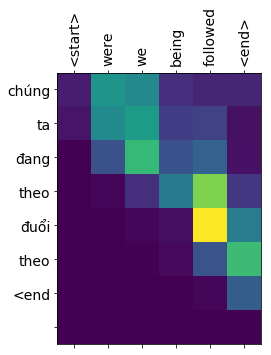


Input:  <start> do they know where we live <end>
Groundtruth:  <start> họ có biết chỗ chúng tôi ở không <end>
Translation:  <start> họ có biết chúng ta sống <end>
Bleu Score:  58.41005873035536


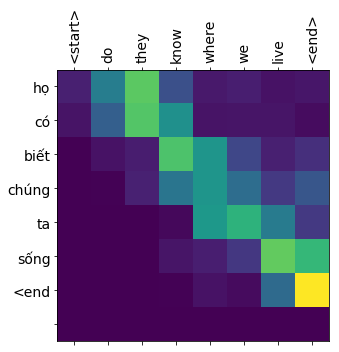


Input:  <start> we were scared but still school was where we wanted to be <end>
Groundtruth:  <start> chúng tôi đã rất sợ nhưng dù vậy chúng tôi vẫn muốn tới trường <end>
Translation:  <start> chúng tôi sợ hãi nhưng vẫn chưa học được là nơi chúng tôi muốn <end>
Bleu Score:  62.5

Input:  <start> i was very lucky to grow up in a family where education was prized and daughters were treasured <end>
Groundtruth:  <start> tôi rất may mắn được nuôi dạy trong một gia đình rất trân trọng việc học và con gái được quý trọng <end>
Translation:  <start> tôi rất may mắn được nuôi lớn trong gia đình nơi mà họ là những điểm cao và con gái <end>
Bleu Score:  58.10640921796214

Input:  <start> my grandfather was an extraordinary man for his time <end>
Groundtruth:  <start> ông ngoại của tôi là một người thật đáng khâm phục vào thời ấy <end>
Translation:  <start> ông nội tôi là một người đàn ông đặc biệt đối với thời gian <end>
Bleu Score:  50.0

Input:  <start> a total maverick from a remote province 

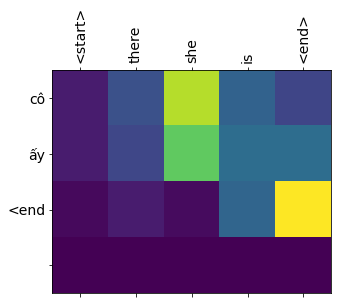


Input:  <start> she retired two years ago only to turn our house into a school for girls and women in our neighborhood <end>
Groundtruth:  <start> bà nghỉ hưu 2 năm về trước để dùng nhà của chúng tôi để mở trường cho bé gái và phụ nữ trong hàng xóm <end>
Translation:  <start> cô ấy nghỉ hưu trong khoảng 2 năm trước chỉ cần phải làm ngôi nhà của mình trong một ngôi trường cho các em gái và phụ nữ trong làng lân cận <end>
Bleu Score:  47.05882352941176

Input:  <start> and my father thats him he was the first ever in his family to receive an education <end>
Groundtruth:  <start> và đây là bố của tôi ông là người đầu tiên trong gia đình của ông ấy được giáo dục <end>
Translation:  <start> bố tôi là ông ấy là người đầu tiên trong gia đình nhận được một giáo dục <end>
Bleu Score:  76.4051279768426

Input:  <start> there was no question that his children would receive an education including his daughters despite the taliban despite the risks <end>
Groundtruth:  <start> không nghi ngờ rằng c

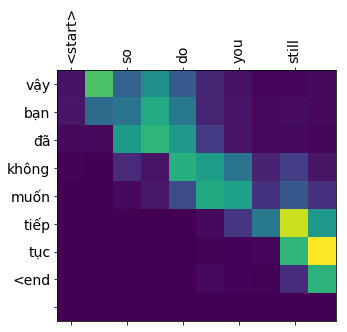


Input:  <start> today i am 22 <end>
Groundtruth:  <start> hôm nay tôi 22 tuổi <end>
Translation:  <start> hôm nay tôi là 22 tuổi <end>
Bleu Score:  87.5


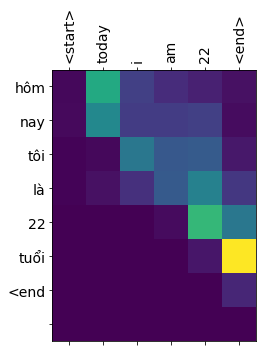


Input:  <start> i was raised in a country that has been destroyed by decades of war <end>
Groundtruth:  <start> tôi đã được lớn lên ở một quốc gia đã bị tiêu huỷ bởi bao thập niên chiến tranh <end>
Translation:  <start> tôi đã được nuôi lớn ở một đất nước đã bị phá huỷ bởi hàng thập niên chiến tranh <end>
Bleu Score:  76.19047619047619

Input:  <start> fewer than six percent of women my age have made it beyond high school and had my family not been so committed to my education i would be one of them <end>
Groundtruth:  <start> ít hơn 6 phụ nữ tuổi tôi được học sau trung học phổ thông và nếu gia đình tôi không cam kết về việc học của tôi tôi cũng trở thành một trong số họ <end>
Translation:  <start> ít hơn 6 người phụ nữ đã làm từ lâu dài và cao hơn là gia đình tôi tôi là một trong số họ <end>
Bleu Score:  40.309430423739926

Input:  <start> instead i stand here a proud graduate of middlebury college <end>
Groundtruth:  <start> nhưng mà tôi hãnh diện đứng đây là một sinh viên tốt nghiệ

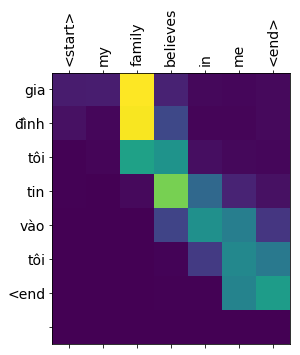


Input:  <start> i dream big but my family dreams even bigger for me <end>
Groundtruth:  <start> tôi mơ ước lớn nhưng gia đình tôi mong ước cho tôi còn lớn hơn <end>
Translation:  <start> tôi mơ ước lớn nhưng gia đình tôi thậm chí lớn hơn tôi <end>
Bleu Score:  75.84835431705545

Input:  <start> thats why i am a global ambassador for 10x10 a global campaign to educate women <end>
Groundtruth:  <start> vì thế tôi là đại sứ toàn cầu cho 10x10 đây là cuộc vận động toàn cầu để giáo dục phụ nữ <end>
Translation:  <start> đó là lý do tại sao tôi là một đại sứ toàn cầu về cuộc sống toàn cầu cho giáo dục <end>
Bleu Score:  62.44261096098136

Input:  <start> thats why i cofounded sola the first and perhaps only boarding school for girls in afghanistan a country where its still risky for girls to go to school <end>
Groundtruth:  <start> vì vậy tôi giúp thành lập sola ngôi trường đầu tiên và hẳn là duy nhất cho con gái ở afghanistan một đất nước mà vẫn còn nguy hiểm cho các cô gái đến trường học 

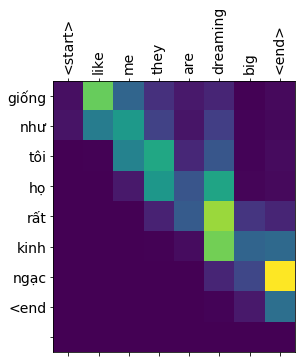


Input:  <start> thank you <end>
Groundtruth:  <start> cám ơn <end>
Translation:  <start> xin cảm ơn <end>
Bleu Score:  60.0


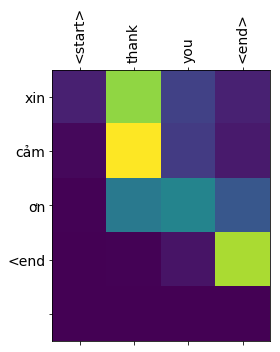


Input:  <start> hi this is my mobile phone <end>
Groundtruth:  <start> xin chào đây là chiếc điện thoại di động của tôi <end>
Translation:  <start> xin chào đây là điện thoại di động của tôi <end>
Bleu Score:  92.00444146293233

Input:  <start> a mobile phone can change your life and a mobile phone gives you individual freedom <end>
Groundtruth:  <start> một chiếc điện thoại di động có thể thay đổi cuộc sống của bạn và một chiếc điện thoại cũng mang lại cho bạn tự do cá nhân <end>
Translation:  <start> một chiếc điện thoại di động có thể thay đổi cuộc sống của bạn và một chiếc điện thoại di động cho bạn một tự do cá nhân <end>
Bleu Score:  90.0

Input:  <start> with a mobile phone you can shoot a crime against humanity in syria <end>
Groundtruth:  <start> với một chiếc điện thoại di động bạn có thể ghi lại hình ảnh những hành động xâm phạm nhân quyền ở syria <end>
Translation:  <start> với một chiếc điện thoại di động bạn có thể bắn một tội phạm chống lại trong syria <end>
Bleu Score:

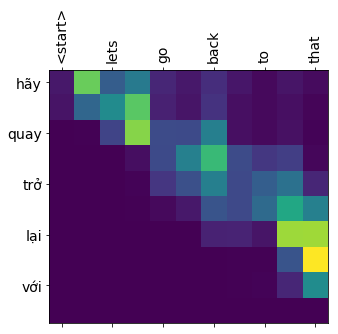


Input:  <start> here you can see how hundreds of thousands of people stood up and protested for change <end>
Groundtruth:  <start> bạn có thể thấy ở đây cách mà hàng ngàn người dân đứng lên và biểu tình cho sự thay đổi <end>
Translation:  <start> ở đây bạn có thể thấy hàng trăm ngàn người đứng lên và phản đối đối với sự thay đổi <end>
Bleu Score:  73.83896189345833

Input:  <start> this is autumn 1989 and imagine that all those people standing up and protesting for change had a mobile phone in their pocket <end>
Groundtruth:  <start> đó là vào mùa thu năm 1989 và hãy tưởng tượng những con người đã đứng lên và biểu tình đòi sự thay đổi đó có một chiếc điện thoại di động trong túi <end>
Translation:  <start> mùa hè năm 1989 và tưởng tượng rằng tất cả những người đứng lên và chống lại thay đổi một thiết bị điện thoại trong túi <end>
Bleu Score:  53.67694950537757

Input:  <start> who in the room has a mobile phone with you <end>
Groundtruth:  <start> những ai trong khán phòng có điện tho

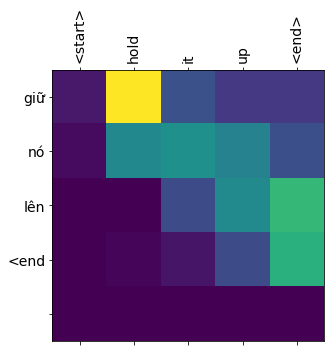


Input:  <start> hold your phones up hold your phones up <end>
Groundtruth:  <start> hãy giơ chiếc điện thoại của bạn lên hãy giơ cao chiếc điện thoại của bạn lên <end>
Translation:  <start> giữ điện thoại của bạn giơ tay điện thoại <end>
Bleu Score:  39.53659755189481

Input:  <start> hold it up an android a blackberry wow <end>
Groundtruth:  <start> hãy giơ cao nó lên một chiếc điện thoại android blackberry wow <end>
Translation:  <start> giữ nó lên một chiếc điện thoại cầu vồng <end>
Bleu Score:  55.36730085068172

Input:  <start> thats a lot almost everybody today has a mobile phone <end>
Groundtruth:  <start> rất nhiều ngày nay phần lớn chúng ta đều có một chiếc điện thoại di động <end>
Translation:  <start> đó là rất nhiều người tất cả mọi người ngày nay có một chiếc điện thoại di động <end>
Bleu Score:  65.0

Input:  <start> but today i will talk about me and my mobile phone and how it changed my life <end>
Groundtruth:  <start> nhưng hôm nay tôi sẽ nói về bản thân và chiếc điện

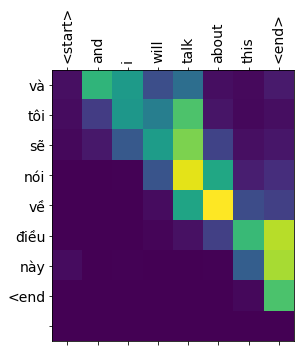


Input:  <start> these are 35 830 lines of information <end>
Groundtruth:  <start> có khoảng 35830 dãy thông tin <end>
Translation:  <start> đây là 35 đường ray này <end>
Bleu Score:  25.0


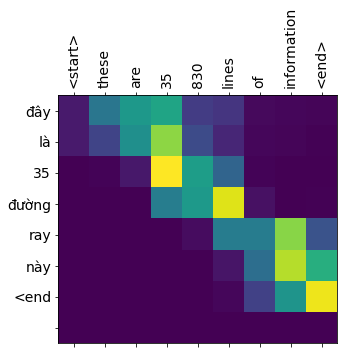


Input:  <start> raw data <end>
Groundtruth:  <start> những thông tin thuần sơ cấp <end>
Translation:  <start> dữ liệu thô sơ <end>
Bleu Score:  35.826565528689464


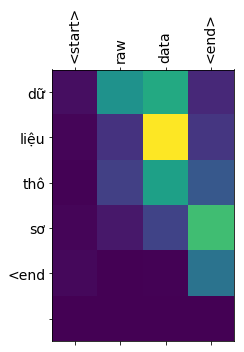


Input:  <start> and why are these informations there <end>
Groundtruth:  <start> nhưng tại sao những thông tin đó lại ở đây <end>
Translation:  <start> và tại sao những thông tin này <end>
Bleu Score:  55.73021304462805


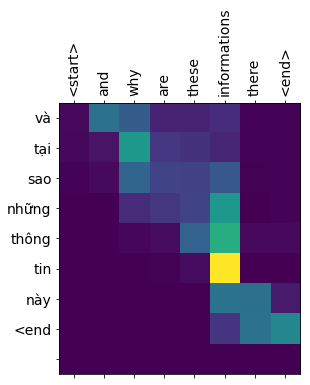


Input:  <start> because in the summer of 2006 the e u commission tabled a directive <end>
Groundtruth:  <start> nguyên nhân là do mùa hè năm 2006 uỷ ban châu âu đã đề xuất một chỉ thị chính thức <end>
Translation:  <start> bởi vì mùa hè năm 2006 của viện trợ cấp quốc <end>
Bleu Score:  23.096304016641696

Input:  <start> this directive 91 is 93 called data retention directive <end>
Groundtruth:  <start> nó được gọi là chỉ thị bảo lưu dữ liệu <end>
Translation:  <start> chiếc máy này được gọi là sự nhớ về sự phát quang học cổ xưa <end>
Bleu Score:  29.411764705882355

Input:  <start> this directive says that each phone company in europe each internet service company all over europe has to store a wide range of information about the users <end>
Groundtruth:  <start> chỉ thị này cho biết mỗi công ty viễn thông ở châu âu mỗi nhà cung cấp dịch vụ internet trên toàn lãnh thổ châu âu đều phải lưu trữ một lượng lớn thông tin về những người sử dụng <end>
Translation:  <start> chiếc máy này nói

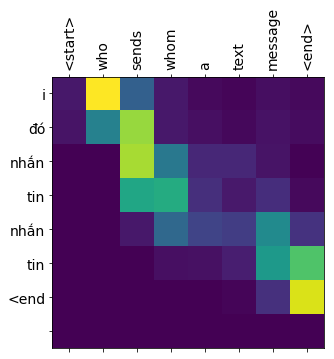


Input:  <start> and if you use your mobile phone where you are <end>
Groundtruth:  <start> và nếu bạn sử dụng điện thoại di động thì đây chính là nơi mà vấn đề tồn tại <end>
Translation:  <start> và nếu bạn sử dụng điện thoại di động bạn <end>
Bleu Score:  43.30026733459301

Input:  <start> all this information is stored for at least six months up to two years by your phone company or your internet service provider <end>
Groundtruth:  <start> tất cả những thông tin này đều được lưu trữ ít nhất trong sáu tháng cho tới hai năm bởi nhà mạng bạn đang sử dụng hoặc nhà cung cấp dịch vụ internet <end>
Translation:  <start> tất cả những thông tin này được lưu trữ ít nhất 6 tháng 2 năm bởi vì công ty truyền thông <end>
Bleu Score:  41.286086800419326

Input:  <start> and all over europe people stood up and said we dont want this <end>
Groundtruth:  <start> và ở khắp châu âu người dân đã đứng lên và nói chúng tôi không muốn như vậy <end>
Translation:  <start> và tất cả những người châu âu đứng 

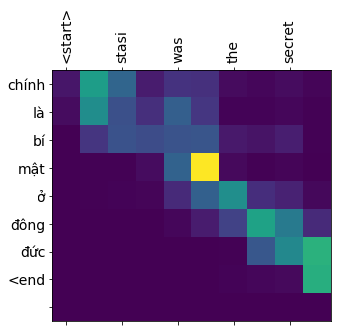


Input:  <start> and i also ask myself does it really work <end>
Groundtruth:  <start> tôi cũng đã từng tự hỏi thực tế nó có hoạt động không <end>
Translation:  <start> và tôi cũng tự hỏi bản thân thực sự làm việc đó <end>
Bleu Score:  46.553138985201144

Input:  <start> can they really store all this information about us <end>
Groundtruth:  <start> liệu họ có thể lưu lại toàn bộ thông tin của chúng ta không <end>
Translation:  <start> liệu chúng có thể lưu trữ tất cả chúng ta <end>
Bleu Score:  47.76875403825262

Input:  <start> every time i use my mobile phone <end>
Groundtruth:  <start> mỗi khi chúng ta sử dụng điện thoại di động của mình <end>
Translation:  <start> mỗi lần tôi sử dụng điện thoại di động <end>
Bleu Score:  62.28821345701695

Input:  <start> so i asked my phone company deutsche telekom which was at that time the largest phone company in germany and i asked them please send me all the information you have stored about me <end>
Groundtruth:  <start> do đó tôi đã yêu cầ

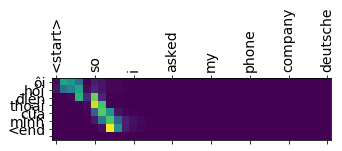


Input:  <start> and i asked them once and i asked them again and i got no real answer it was only blah blah answers <end>
Groundtruth:  <start> tôi đã yêu cầu họ hãy gửi cho tôi chỉ một lần thôi và tôi đã tiếp tục yêu cầu nhưng cái mà tôi nhận được chỉ là một câu trả lời không rõ ràng blah blah blah <end>
Translation:  <start> và tôi hỏi họ một lần tôi hỏi họ và tôi không có câu trả lời đúng không có câu trả lời đúng không <end>
Bleu Score:  29.182273907178708

Input:  <start> but then i said i want to have this information because this is my life you are protocoling <end>
Groundtruth:  <start> nhưng sau đó tôi đã nói tôi muốn có được những thông tin này bởi vì họ đang lưu trữ cuộc sống của tôi <end>
Translation:  <start> nhưng rồi tôi nói tôi muốn có thông tin này bởi vì đây là cuộc đời của bạn <end>
Bleu Score:  55.56136655112884

Input:  <start> so i decided to start a lawsuit against them because i wanted to have this information <end>
Groundtruth:  <start> và tôi đã quyết định sẽ

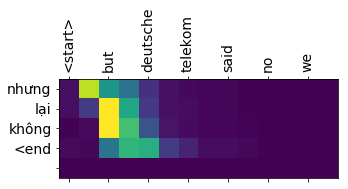


Input:  <start> so at the end i had a settlement with them <end>
Groundtruth:  <start> và cuối cùng tôi đã có một thoả thuận với họ <end>
Translation:  <start> cuối cùng tôi có một người với một người với chúng <end>
Bleu Score:  61.53846153846154

Input:  <start> ill put down the lawsuit and they will send me all the information i ask for <end>
Groundtruth:  <start> tôi sẽ huỷ đơn kiện và họ sẽ cung cấp cho tôi những thông tin tôi yêu cầu <end>
Translation:  <start> tôi sẽ đưa vào một vụ kiện và họ sẽ gửi tôi tất cả thông tin tôi yêu cầu <end>
Bleu Score:  66.66666666666666

Input:  <start> because in the mean time the german constitutional court ruled that the implementation of this e u directive into german law was unconstitutional <end>
Groundtruth:  <start> bởi vì tại thời điểm đó toà án hiến pháp liên bang đã quy định rằng chỉ thị của uỷ ban châu âu này không có hiệu lực trong hệ thống hiến pháp của nước đức <end>
Translation:  <start> bởi vì trong ý nghĩa là sự hiến pháp luật p

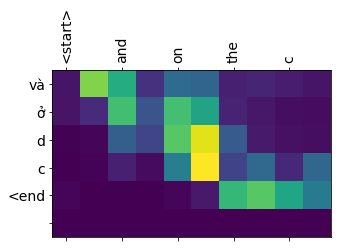


Input:  <start> thirty five thousand eight hundred thirty lines of information <end>
Groundtruth:  <start> 35830 dãy các thông tin <end>
Translation:  <start> 32 ngàn 7 trăm đường ray <end>
Bleu Score:  25.0


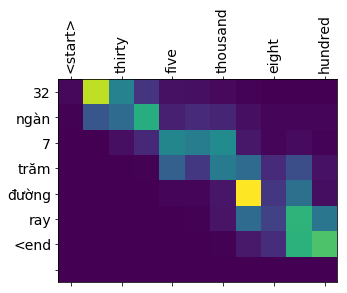


Input:  <start> at first i saw it and i said okay its a huge file okay <end>
Groundtruth:  <start> đầu tiên tôi nhìn nó và nói được rồi nó là một file dữ liệu lớn tốt <end>
Translation:  <start> trước tiên tôi thấy nó và nói okay đó là một tin tức lớn <end>
Bleu Score:  51.81431988627503

Input:  <start> but then after a while i realized this is my life <end>
Groundtruth:  <start> nhưng sau đó tôi đã nhận ra đây là toàn bộ cuộc sống của mình <end>
Translation:  <start> nhưng sau khi tôi nhận ra rằng cuộc sống của tôi <end>
Bleu Score:  56.54934466089882

Input:  <start> this is six months of my life into this file <end>
Groundtruth:  <start> đây là cuộc sống trong sáu tháng của tôi đã được ghi lại toàn bộ trong tệp dữ liệu này <end>
Translation:  <start> đây là 6 tháng tuổi của tôi vào cái này <end>
Bleu Score:  28.973213900471873

Input:  <start> so i was a little bit skeptical what should i do with it <end>
Groundtruth:  <start> sau đó tôi có băn khoăn một chút nên làm gì với nó đây

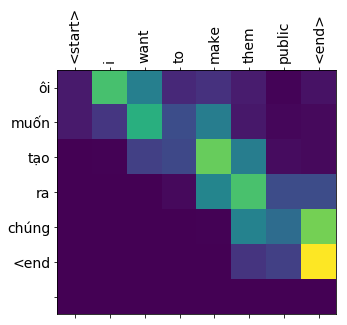


Input:  <start> because i want to show the people what does data retention mean <end>
Groundtruth:  <start> bởi lẽ tôi muốn cho mọi người thấy sự bảo lưu dữ liệu thật sự là như thế nào <end>
Translation:  <start> bởi vì tôi muốn cho các con người mà các dữ liệu ký ức được ký ức được <end>
Bleu Score:  42.80532410253213

Input:  <start> so together with zeit online and open data city i did this <end>
Groundtruth:  <start> do vậy đối với zeit online và open data city tôi cũng làm điều tương tự <end>
Translation:  <start> cùng với nhau với nhau <end>
Bleu Score:  8.903493734725751


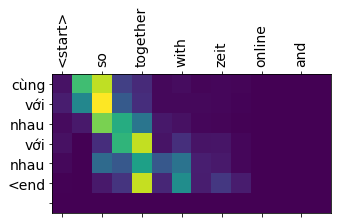


Input:  <start> this is a visualization of six months of my life <end>
Groundtruth:  <start> đây là những hình ảnh trực quan về cuộc sống trong sáu tháng đã được ghi lại của tôi <end>
Translation:  <start> đây là hình ảnh của một 6 tháng đầu đời tôi <end>
Bleu Score:  37.41459206445236

Input:  <start> you can zoom in and zoom out you can wind back and fast forward <end>
Groundtruth:  <start> bạn có thể phóng to hoặc thu nhỏ nó bạn cũng có thể tua ngược trở lại hoặc nhanh hơn về phía trước <end>
Translation:  <start> bạn có thể phóng to và phóng to và bạn sẽ có thể gió thổi nhanh và nhanh chóng <end>
Bleu Score:  43.29628482793628

Input:  <start> you can see every step i take <end>
Groundtruth:  <start> bạn có thể thấy từng bước đi của tôi <end>
Translation:  <start> bạn có thể thấy mỗi bước tôi <end>
Bleu Score:  71.1766580370496


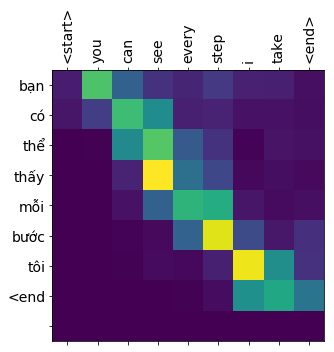


Input:  <start> and you can even see how i go from frankfurt by train to cologne and how often i call in between <end>
Groundtruth:  <start> bạn thậm chí có thể biết được tôi tới frankfurt bằng tàu hoả tới cologne như thế nào và cả tần suất tôi gọi điện liên lạc giữa hai địa điểm đó <end>
Translation:  <start> và bạn có thể thấy được cách nào bằng cách làm việc đào tạo để làm sao để làm sao và tôi thường gọi là giữa <end>
Bleu Score:  34.590760585945254

Input:  <start> all this is possible with this information <end>
Groundtruth:  <start> tất cả đều có thể với những thông tin này <end>
Translation:  <start> tất cả những điều này có thể là những thông tin này <end>
Bleu Score:  71.42857142857143

Input:  <start> thats a little bit scary <end>
Groundtruth:  <start> tôi đã có một chút sợ hãi <end>
Translation:  <start> đó là một chút đáng sợ <end>
Bleu Score:  55.156056411537215


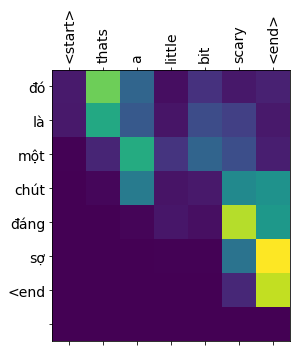


Input:  <start> but it is not only about me <end>
Groundtruth:  <start> nhưng những thông tin đó không chỉ nói về tôi <end>
Translation:  <start> nhưng nó không chỉ là tôi <end>
Bleu Score:  45.48979947844751


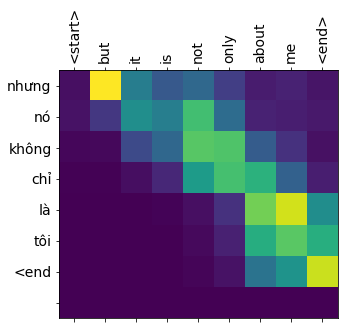


Input:  <start> its about all of us <end>
Groundtruth:  <start> nó là thông tin về tất cả chúng ta <end>
Translation:  <start> đó là về tất cả chúng ta <end>
Bleu Score:  71.1766580370496


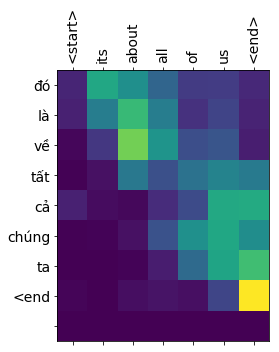


Input:  <start> first its only like i call my wife and she calls me and we talk to each other a couple of times <end>
Groundtruth:  <start> đầu tiên nó chỉ giống như thế này tôi gọi cho vợ tôi và cô ấy cũng gọi cho tôi chúng tôi nói chuyện với nhau vài ba lần <end>
Translation:  <start> thứ nhất chỉ là tôi gọi vợ tôi và tôi gọi tôi và nói chuyện với nhau <end>
Bleu Score:  41.980383957676636

Input:  <start> and then there are some friends calling me and they call each other <end>
Groundtruth:  <start> và sau đó là một vài người bạn gọi cho tôi họ gọi cho nhau nữa <end>
Translation:  <start> và có một số người bạn gọi tôi và nói chung và nói chung và nói chung và nói chung và nói chung lẫn nhau <end>
Bleu Score:  33.33333333333333

Input:  <start> and after a while you are calling you and you are calling you and you have this great communication network <end>
Groundtruth:  <start> một lúc sau đó bạn gọi cho bạn và bạn gọi cho bạn và bạn sẽ có được mạng lưới giao tiếp rộng lớn này <end

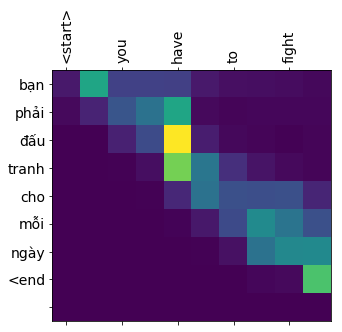


Input:  <start> so when you go home tell your friends that privacy is a value of the 21st century and its not outdated <end>
Groundtruth:  <start> sau đó khi bạn trở về nhà hãy nói với bạn bè của mình rằng quyền riêng tư là một giá trị của thế kỉ 21 và điều đó không hề lỗi thời <end>
Translation:  <start> vì vậy khi bạn đi về nhà bạn bè của riêng tư bản thân là một giá trị của thế kỷ 21 và không phải là lỗi thời <end>
Bleu Score:  62.07532649197836

Input:  <start> when you go home tell your representative only because companies and state agencies have the possibility to store certain information they dont have to do it <end>
Groundtruth:  <start> khi bạn trở về nhà hãy nói với chỉ người đại diện của mình rằng bởi các công ty và cơ quan chức năng có thể lưu giữ lại những thông tin cụ thể mặc dù họ không nhất thiết phải làm như thế <end>
Translation:  <start> khi bạn đi về nhà báo cáo của mình chỉ bởi vì các công ty và các cơ quan có khả năng để có thể lưu trữ một số thông tin mà không

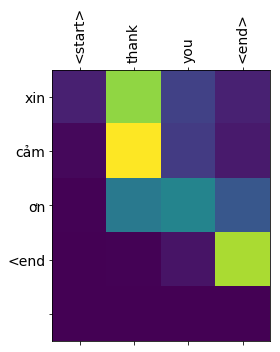


Input:  <start> photography has been my passion ever since i was old enough to pick up a camera but today i want to share with you the 15 most treasured photos of mine and i didnt take any of them <end>
Groundtruth:  <start> nhiếp ảnh là niềm đam mê của tôi kể từ khi tôi đủ lớn để cầm một chiếc máy ảnh nhưng hôm nay tôi muốn chia sẻ với các bạn 15 bức ảnh mà tôi trân trọng nhất và tôi không tự chụp cái nào trong số đó <end>
Translation:  <start> nhiếp ảnh đã được đam mê của tôi từ khi tôi già đi để lấy một máy ảnh nhưng hôm nay tôi muốn chia sẻ với bạn 15 phút cuối của tôi và tôi không lấy bất kỳ ai <end>
Bleu Score:  56.79122101283263

Input:  <start> there were no art directors no stylists no chance for reshoots not even any regard for lighting <end>
Groundtruth:  <start> không có đạo diễn nghệ thuật không có nhà tạo mẫu không chụp lại thậm chí không hề quan tâm tới ánh sáng <end>
Translation:  <start> không có một cuộc tranh cãi không có những chiếc bánh mì không có cà phê không có

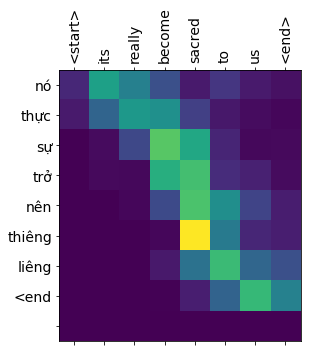


Input:  <start> this one was taken just weeks after 9 11 and i found myself trying to explain what had happened that day in ways a five year old could understand <end>
Groundtruth:  <start> bức này được chụp vài tuần sau sự kiện 11 9 và tôi đã cố gắng giải thích những việc xảy ra hôm đó theo những cách mà một đứa trẻ 5 tuổi có thể hiểu được <end>
Translation:  <start> đây là chụp 2 tháng 11 và tôi tìm thấy mình cố gắng giải thích những gì đã xảy ra ngày hôm qua năm tháng 5 tuổi có thể hiểu <end>
Bleu Score:  50.2201608555663

Input:  <start> so these photos are far more than proxies for a single moment or even a specific trip <end>
Groundtruth:  <start> những bức ảnh này không chỉ là vật đại diện cho một khoảnh khắc hay một chuyến đi đặc biệt nào đó <end>
Translation:  <start> những bức ảnh này đang hơn là giấy phép cho một khoảnh khắc hay thậm chí một cuộc hành động <end>
Bleu Score:  53.955951416679135

Input:  <start> theyre also ways for us to freeze time for one week in october a

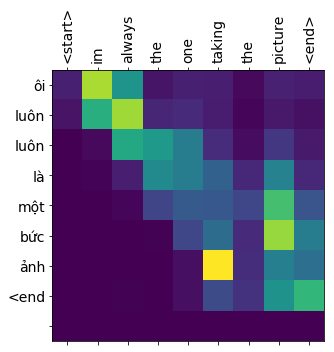


Input:  <start> so i want to encourage everyone today to get in the shot and dont hesitate to go up to someone and ask will you take our picture <end>
Groundtruth:  <start> vì vậy hôm nay tôi muốn động viên tất cả mọi người hãy có mặt trong bức ảnh và đừng ngần ngại bước tới chỗ một ai đó và hỏi bạn chụp ảnh giúp chúng tôi nhé <end>
Translation:  <start> vì vậy tôi muốn khuyến khích mọi người ngày nay để bị bắn và không thấy không bao giờ để đi đến một người nào đó hỏi bạn sẽ chụp hình của chúng tôi <end>
Bleu Score:  43.44654180194026

Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> xin cảm ơn <end>
Bleu Score:  80.0


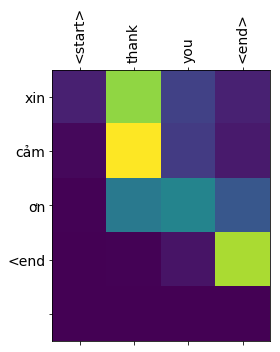


Input:  <start> i have never ever forgotten the words of my grandmother who died in her exile son resist gaddafi fight him <end>
Groundtruth:  <start> tôi chưa bao giờ quên những lời bà tôi dặn dò bà đã qua đời trong cảnh tha hương này cháu hãy chống lại gaddafi hãy chiến đấu chống lại hắn <end>
Translation:  <start> tôi chưa bao giờ quên mất từ bà tôi đã chết trong cuộc sống sót qua con gái tôi cưỡng hiếp ông ấy <end>
Bleu Score:  34.855153779537154

Input:  <start> but dont you ever turn into a gaddafi like revolutionary <end>
Groundtruth:  <start> nhưng đừng bao giờ biến thành một dạng người cách mạng kiểu gaddafi <end>
Translation:  <start> nhưng đừng làm gì hãy nghĩ đến như thế này <end>
Bleu Score:  25.960026102380162

Input:  <start> almost two years have passed since the libyan revolution broke out inspired by the waves of mass mobilization in both the tunisian and the egyptian revolutions <end>
Groundtruth:  <start> gần hai năm đã trôi qua từ khi cuộc khởi nghĩa ở libya nổ ra

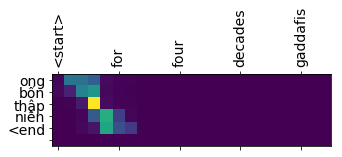


Input:  <start> aware of the devastation and the challenges i was keen among many other women to rebuild the libyan civil society calling for an inclusive and just transition to democracy and national reconciliation <end>
Groundtruth:  <start> nhận thức được sự huỷ hoại và những thách thức tôi cũng như bao nhiêu phụ nữ khác hăm hở tái xây dựng xã hội dân sự của libya kêu gọi sự toàn diện và quá trình chuyển tiếp sang nền dân chủ và hoà giải quốc gia <end>
Translation:  <start> nhận thức về sự tàn phá và những thách thức tôi rất thích thú với nhiều phụ nữ khác để tái tạo ra những hậu quả của xã hội nói của chúng ta gọi cho một nền dân số mạng xã hội <end>
Bleu Score:  39.660240584973806

Input:  <start> almost 200 organizations were established in benghazi during and immediately after the fall of gaddafi almost 300 in tripoli <end>
Groundtruth:  <start> gần 200 tổ chức được thiết lập tại benghazi trong suốt thời gian đó và ngay sau gaddafi sụp đổ gần 300 tại tripoli <end>
Translation: 

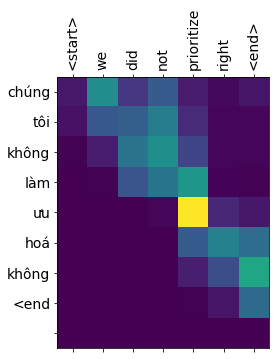


Input:  <start> for elections did not bring peace and stability and security in libya <end>
Groundtruth:  <start> vì những cuộc bầu cử không đem lại hoà bình sự ổn định hay an ninh cho libya <end>
Translation:  <start> đối với bầu cử không mang lại hoà bình và ổn định an ninh <end>
Bleu Score:  58.41005873035536

Input:  <start> did the zipper list and the alternation between female and male candidates bring peace and national reconciliation <end>
Groundtruth:  <start> liệu danh sách hình khoá kéo và sự dan xen giữa các ứng cử viên nam và nữ đã đem lại hoà bình và hoà giải cho đất nước chăng <end>
Translation:  <start> liệu có phải là danh sách và cả những con cái và nữ giới mang tính hoà bình và hoà giải <end>
Bleu Score:  38.218549230055295

Input:  <start> no it didnt <end>
Groundtruth:  <start> không không hề <end>
Translation:  <start> không không <end>
Bleu Score:  77.8800783071405


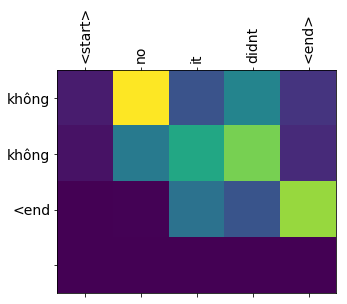


Input:  <start> what is it then <end>
Groundtruth:  <start> vậy cuối cùng nó đã giúp ích gì <end>
Translation:  <start> nó là gì <end>
Bleu Score:  29.430355293715387


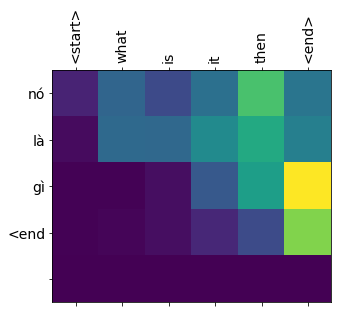


Input:  <start> why does our society continue to be polarized and dominated with selfish politics of dominance and exclusion by both men and women <end>
Groundtruth:  <start> tại sao xã hội chúng tôi tiếp tục là một xã hội phân cực và thống trị bởi những nền chính trị ích kỷ của sự thống trị và loại trừ bởi cả hai giới nam và nữ <end>
Translation:  <start> tại sao chúng ta lại tiếp tục tái phân cực và quá nguy cơ bản quyền và các dịch vụ bởi những đàn ông và phụ nữ <end>
Bleu Score:  35.39654485026018

Input:  <start> maybe what was missing was not the women only but the feminine values of compassion mercy and inclusion <end>
Groundtruth:  <start> có thể sự thiếu sót không chỉ là về mặt bình quyền của phụ nữ mà còn là những giá trị tính nữ về lòng trắc ẩn sự khoan dung và tính toàn diện <end>
Translation:  <start> có thể là những gì đã bị thiếu vắng mặt phụ nữ duy nhất nhưng nữ giới tính nữ tính của nó trở nên gắn liền và chia sẻ <end>
Bleu Score:  41.179594725930286

Input:  <start> 

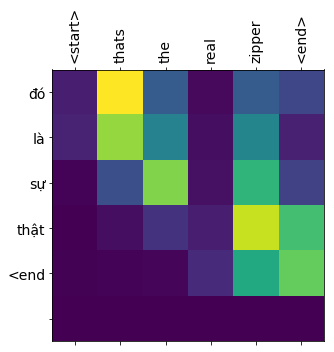


Input:  <start> and we need to establish that existentially before we do so sociopolitically <end>
Groundtruth:  <start> và chúng tôi cần thiết lập yếu tố sống còn đó trước khi thực hiện mặt chính trị xã hội <end>
Translation:  <start> và chúng ta cần thiết lập điều đó trước khi chúng ta làm vậy <end>
Bleu Score:  42.95557992443577

Input:  <start> according to a quranic verse salam peace is the word of the all merciful god raheem <end>
Groundtruth:  <start> theo một đoạn thơ trong kinh koran salam hoà bình là từ của chúa trời đầy lòng khoan dung raheem <end>
Translation:  <start> theo một người chơi nốt nhạc rock là một từ những trường hợp của thượng đế người đức xứ <end>
Bleu Score:  31.783231827782554

Input:  <start> in turn the word raheem which is known in all abrahamic traditions has the same root in arabic as the word rahem womb symbolizing the maternal feminine encompassing all humanity from which the male and the female from which all tribes all peoples have emanated from <e

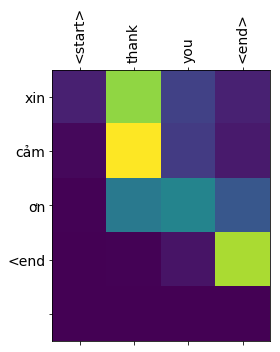


Input:  <start> five years ago i experienced a bit of what it must have been like to be alice in wonderland <end>
Groundtruth:  <start> 5 năm trước tôi đã trải qua 1 chuyện có chút giống như alice ở xứ thần tiên <end>
Translation:  <start> năm năm trước tôi đã trải qua một chút nó đã trở thành người đứng ở khu vực thiên nhiên <end>
Bleu Score:  45.45454545454545

Input:  <start> penn state asked me a communications teacher to teach a communications class for engineering students <end>
Groundtruth:  <start> trường penn state yêu cầu tôi một giáo viên dạy giao tiếp dạy một khoá giao tiếp cho sinh viên kỹ thuật <end>
Translation:  <start> grandma com hỏi tôi một nhà truyền thống giáo viên dạy cho một giáo dục cho kỹ sư kỹ thuật <end>
Bleu Score:  45.65503581411311

Input:  <start> and i was scared <end>
Groundtruth:  <start> tôi đã rất sợ <end>
Translation:  <start> tôi đã rất sợ <end>
Bleu Score:  100.0


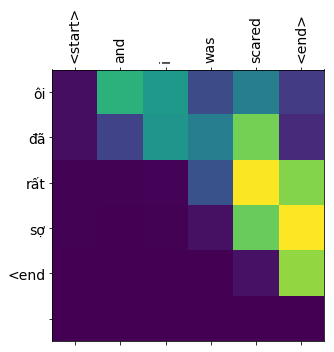


Input:  <start> really scared scared of these students with their big brains and their big books and their big unfamiliar words <end>
Groundtruth:  <start> thực sự sợ sợ những sinh viên to đầu những quyển sách to đùng và cả những ngôn từ lạ lẫm <end>
Translation:  <start> thật sợ rằng những đứa trẻ này với bộ não lớn và lớn những cuốn sách nổi tiếng <end>
Bleu Score:  30.124779174877013

Input:  <start> but as these conversations unfolded i experienced what alice must have when she went down that rabbit hole and saw that door to a whole new world <end>
Groundtruth:  <start> nhưng khi những cuộc trao đổi mở ra tôi đã trải nghiệm điều mà hẳn alice cũng trải qua khi cô bé rơi xuống hang thỏ và phát hiện cánh cửa dẫn đến 1 thế giới mới <end>
Translation:  <start> nhưng với những cuộc nói chuyện này diễn ra tôi đã trải qua những gì alice đã phải khi cô ấy đi đó một cái lỗ đó và thấy rằng cánh cửa một thế giới mới <end>
Bleu Score:  48.70137267101506

Input:  <start> thats just how i felt a

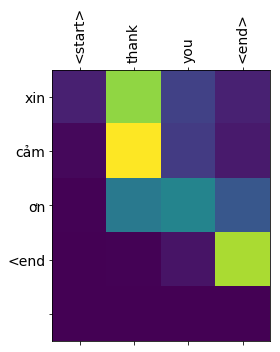


Input:  <start> hi my name is cameron russell and for the last little while ive been a model <end>
Groundtruth:  <start> xin chào tôi là cameron russell và trong khoảng thời gian ngắn ngủi vừa qua tôi là một người mẫu <end>
Translation:  <start> xin chào tên tôi là cameron sinclair và vì thế là lần tôi đã được mô hình <end>
Bleu Score:  44.944192927554475

Input:  <start> actually for 10 years <end>
Groundtruth:  <start> thật ra trong 10 năm <end>
Translation:  <start> thực ra 10 năm <end>
Bleu Score:  70.5401437408845


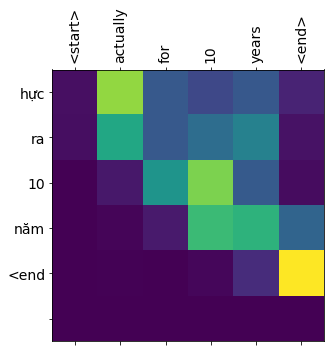


Input:  <start> and i feel like theres an uncomfortable tension in the room right now because i should not have worn this dress <end>
Groundtruth:  <start> và tôi cảm thấy có một áp lực không thoải mái trong phòng vào lúc này bởi vì đáng lẽ ra tôi không nên mặc cái đầm này <end>
Translation:  <start> và tôi cảm thấy như một chút khó khăn trong tình huống ngay trong phòng này ngay cả vì tôi nên không còn mặc quần áo này <end>
Bleu Score:  53.30234463589497

Input:  <start> so luckily i brought an outfit change <end>
Groundtruth:  <start> may mắn thay tôi có mang theo một bộ đồ khác <end>
Translation:  <start> may mắn tôi đã mang một loạt các phòng ăn <end>
Bleu Score:  53.669257520043864

Input:  <start> this is the first outfit change on the ted stage so you guys are pretty lucky to witness it i think <end>
Groundtruth:  <start> đây là lần đầu tiên có người thay đồ trên sân khấu của ted vậy nên tôi nghĩ các bạn rất may mắn khi được chứng kiến cảnh này đấy <end>
Translation:  <start> đ

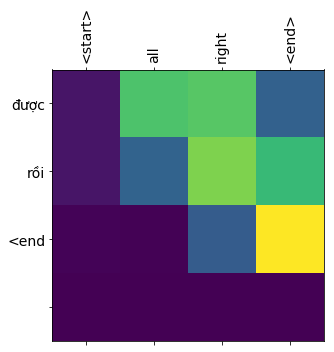


Input:  <start> so why did i do that <end>
Groundtruth:  <start> tại sao tôi lại làm như vậy <end>
Translation:  <start> vậy tại sao tôi làm như vậy <end>
Bleu Score:  88.88888888888889


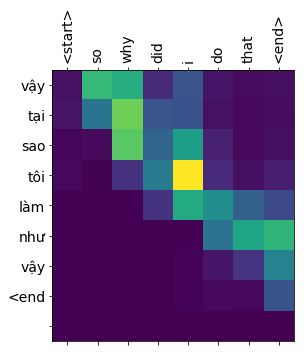


Input:  <start> that was awkward <end>
Groundtruth:  <start> nó thật là kì cục <end>
Translation:  <start> đó là một chút <end>
Bleu Score:  42.324086244530704


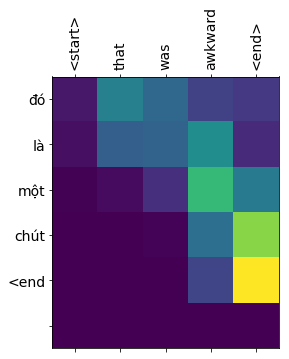


Input:  <start> well hopefully not as awkward as that picture <end>
Groundtruth:  <start> thật ra hy vọng là nó không đến nỗi kì cục như tấm hình này <end>
Translation:  <start> hy vọng là không phải là những kẻ xấu xa như thế này <end>
Bleu Score:  46.6759103489572

Input:  <start> image is powerful but also image is superficial <end>
Groundtruth:  <start> hình ảnh có sức mạnh rất lớn nhưng nó cũng rất là giả tạo <end>
Translation:  <start> hình ảnh là sức mạnh nhưng cũng là những hình ảnh <end>
Bleu Score:  54.963876310473545

Input:  <start> i just totally transformed what you thought of me in six seconds <end>
Groundtruth:  <start> tôi vừa mới thay đổi hoàn toàn những gì bạn nghĩ về tôi trong vòng 6 giây <end>
Translation:  <start> tôi hoàn toàn thay đổi nó cho tôi trong khoảng sáu giây <end>
Bleu Score:  49.9766098125093

Input:  <start> and in this picture i had actually never had a boyfriend in real life <end>
Groundtruth:  <start> và trong bức ảnh này thực ra tôi chưa hề có bạ

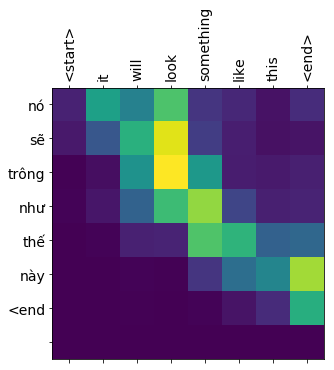


Input:  <start> hopefully less awkward than that one in the middle <end>
Groundtruth:  <start> hi vọng là nó ít kì cục hơn tấm hình ở giữa <end>
Translation:  <start> hy vọng ít hơn cả những gì đó trong một nơi <end>
Bleu Score:  35.61388764008908

Input:  <start> that was i dont know what happened there <end>
Groundtruth:  <start> tôi không biết điều gì xảy ra trong lúc đó nữa <end>
Translation:  <start> đó là tôi không biết chuyện gì đã xảy ra <end>
Bleu Score:  69.00333109719925

Input:  <start> unfortunately after youve gone to school and you have a résumé and youve done a few jobs you cant say anything anymore so if you say you want to be the president of the united states but your résumé reads underwear model 10 years people give you a funny look <end>
Groundtruth:  <start> thật đáng tiếc sau khi bạn học xong bạn viết résumé và từng làm một vài việc bạn không thể nói thêm điều gì nữa vì nếu bạn nói muốn trở thành tổng thống hoa kỳ nhưng résumé của bạn lại ghi người mẫu đồ lót 10

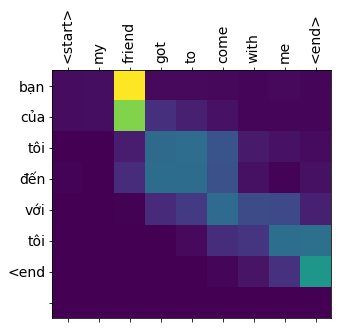


Input:  <start> heres me at a slumber party a few days before i shot french vogue <end>
Groundtruth:  <start> đây là tôi ở tiệc ngủ vài ngày trước khi chụp ảnh cho vogue pháp <end>
Translation:  <start> đây là tôi đang làm một bữa tiệc ngủ một vài ngày trước tôi đã lái xe <end>
Bleu Score:  52.63157894736842

Input:  <start> heres me on the soccer team and in v magazine <end>
Groundtruth:  <start> đây là tôi với đội bóng đá trong tạp chí v <end>
Translation:  <start> đây là tôi đang ở quần vợt và thư viện <end>
Bleu Score:  38.33518394288847

Input:  <start> and heres me today <end>
Groundtruth:  <start> và đây là tôi bây giờ <end>
Translation:  <start> và đây là tôi hôm nay <end>
Bleu Score:  75.0


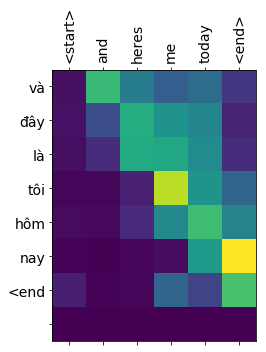


Input:  <start> and i hope what youre seeing is that these pictures are not pictures of me <end>
Groundtruth:  <start> tôi mong rằng bạn nhìn ra được những bức ảnh trên không phải là hình ảnh của tôi <end>
Translation:  <start> và tôi hi vọng các bạn đang thấy là những hình ảnh này không hình ảnh của tôi <end>
Bleu Score:  60.0

Input:  <start> they are constructions and they are constructions by a group of professionals by hairstylists and makeup artists and photographers and stylists and all of their assistants and pre production and post production and they build this thats not me <end>
Groundtruth:  <start> đó là những hình ảnh được dựng lên và nó được dựng nên bởi một nhóm các chuyên gia những nhà tạo mẫu tóc những chuyên gia trang điểm nhiếp ảnh gia và những nhà tạo phong cách và tất cả những người trợ lý của họ khâu tiền sản xuất và hậu sản xuất và họ tạo nên cái này đây đó không phải là tôi <end>
Translation:  <start> họ là cấu tạo và chúng được cấu tạo bởi một nhóm chuyên gia

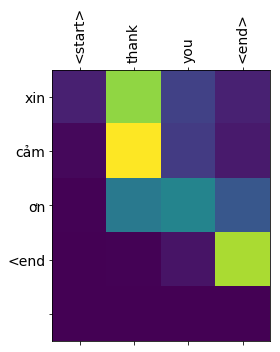


Input:  <start> there are a lot of ways the people around us can help improve our lives <end>
Groundtruth:  <start> có rất nhiều cách mà những người ở xung quanh chúng ta có thể giúp cải thiện cuộc sống của chúng ta <end>
Translation:  <start> có rất nhiều cách mà mọi người xung quanh chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng
Bleu Score:  26.229508196721312

Input:  <start> we dont bump into every neighbor so a lot of wisdom never gets passed on though we do share the same public spaces <end>
Groundtruth:  <start> chúng ta không đụng vào mỗi người xung quanh vì vậy có rất nhiều sự thông thái không bao giờ được biết tới dù chúng ta cùng chia sẻ những không gian công cộng <end>
Translation:  <start> chúng ta không có một ai nấy về những người hàng xóm rất nhiều người đức tin chưa bao giờ đi qua chúng ta chia sẻ cùng

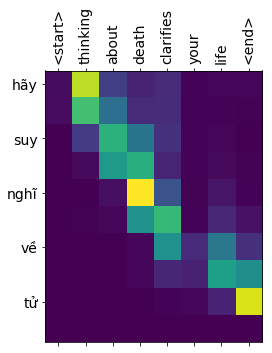


Input:  <start> our shared spaces can better reflect what matters to us as individuals and as a community and with more ways to share our hopes fears and stories the people around us can not only help us make better places they can help us lead better lives <end>
Groundtruth:  <start> những không gian được chia sẻ của chúng ta có thể tốt hơn được phản ánh về những điều xảy ra cho chúng ta như là những cá thể và như là một cộng đồng và với nhiều cách hơn để chia sẻ hy vọng nỗi sợ hãi và những câu chuyện những người xung quanh chúng ta không chỉ có thể giúp chúng ta làm những nơi tốt đẹp hơn họ có thể giúp chúng ta dẫn dắt cuộc sống tốt hơn <end>
Translation:  <start> những không gian của chúng ta có thể tưởng tượng điều gì về việc chúng ta như những người và như một cộng đồng và với nhiều cách để chia sẻ những người ta hơn những người ta xung quanh chúng ta không thể giúp chúng ta có thể giúp chúng ta có thể giúp chúng ta có thể giúp
Bleu Score:  51.987395791420056

Input:  <start> tha

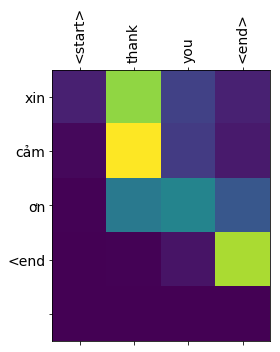


Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> xin cảm ơn <end>
Bleu Score:  80.0


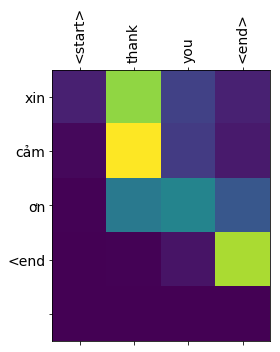


Input:  <start> so well i do applied math and this is a peculiar problem for anyone who does applied math is that we are like management consultants <end>
Groundtruth:  <start> vâng tôi làm toán học ứng dụng và đây là một vấn đề khác thường cho bất cứ ai làm toán học ứng dụng chính là chúng tôi giống như các nhà tư vấn quản lý <end>
Translation:  <start> vâng tôi đã chỉnh sửa và viết này là một vấn đề rất khác với bất cứ ai đó áp dụng toán học là chúng ta như là nhà tư vấn <end>
Bleu Score:  57.29365739256729

Input:  <start> no one knows what the hell we do <end>
Groundtruth:  <start> không ai biết chúng tôi làm cái quái gì <end>
Translation:  <start> không ai biết không biết gì chúng ta làm gì <end>
Bleu Score:  66.66666666666666

Input:  <start> so i am going to give you some attempt today to try and explain to you what i do <end>
Groundtruth:  <start> vì vậy hôm nay tôi sẽ thử cố gắng giải thích cho bạn việc tôi làm <end>
Translation:  <start> tôi sẽ cho bạn một lần thử thách thức

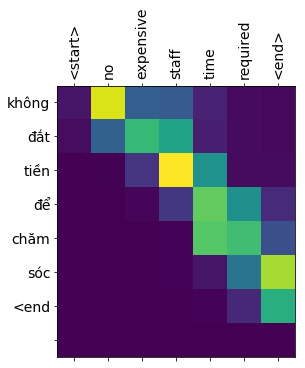


Input:  <start> takes about 300 by the way in the neurologists clinic to do it <end>
Groundtruth:  <start> chỉ tất khoảng 300 mà thôi để làm xét nghiệm này tại phòng khám bác sỹ chuyên khoa thần kinh <end>
Translation:  <start> lấy khoảng 300 đường ở phương tiện của trường học để làm điều đó <end>
Bleu Score:  25.773347954661457

Input:  <start> so what i want to propose to you as an unconventional way in which we can try to achieve this because you see in one sense at least we are all virtuosos like my friend jan stripling <end>
Groundtruth:  <start> vì vậy cái tôi muốn đề xuất cho bạn là một cách phi truyền thống qua đó ta có thể đạt được điều này vì như bạn thấy ít nhất theo một hướng nào đó chúng ta đều là những bậc thầy như jan stripling bạn tôi <end>
Translation:  <start> vậy tôi muốn đề xuất với các bạn nghe một cách lạ thường trong chúng ta có thể cố gắng đạt được điều này bởi vì bạn thấy trong một cảm giác ít nhất là chúng ta đều giống như bạn <end>
Bleu Score:  58.6584134450

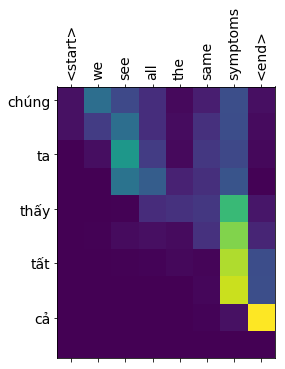


Input:  <start> we see vocal tremor weakness and rigidity <end>
Groundtruth:  <start> chúng ta thấy giọng run sự suy nhược và xơ cứng <end>
Translation:  <start> chúng ta thấy sự run tay yếu đuối và sự cứng <end>
Bleu Score:  69.23076923076923

Input:  <start> the speech actually becomes quieter and more breathy after a while and thats one of the example symptoms of it <end>
Groundtruth:  <start> lời nói trở nên trầm lắng hơn và nhiều giọng gió hơn sau một thời gian và đó là một trong các triệu chứng ví dụ về nó <end>
Translation:  <start> bài nói chuyện đã trở thành những tác động và hơn nữa <end>
Bleu Score:  13.667423885313019

Input:  <start> so these vocal effects can actually be quite subtle in some cases but with any digital microphone and using precision voice analysis software in combination with the latest in machine learning which is very advanced by now we can now quantify exactly where somebody lies on a continuum between health and disease using voice signals alone <end>

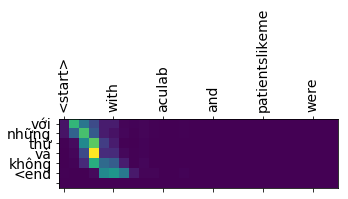


Input:  <start> we have local numbers accessible to three quarters of a billion people on the planet <end>
Groundtruth:  <start> chúng tôi có những cư dân địa phương có thể tiếp cận được với ba phần tư của một tỷ người trên hành tinh <end>
Translation:  <start> chúng ta có những địa phương cách sử dụng để có thể đến 3 đến một tỷ người dân trên hành tinh này <end>
Bleu Score:  61.49052410574869

Input:  <start> anyone healthy or with parkinsons can call in cheaply and leave recordings a few cents each and im really happy to announce that weve already hit six percent of our target just in eight hours <end>
Groundtruth:  <start> bất cứ ai khoẻ mạnh hoặc mắc bệnh parkinson có thể gọi tới với giá rẻ và để lại âm ghi vài xu mỗi lần và tôi thực sự vui mừng thông báo rằng chúng tôi đã đạt sáu phần trăm mục tiêu chỉ trong tám giờ <end>
Translation:  <start> bất cứ ai hay khoẻ hay không thể sánh với giá rẻ và để cho các xu hướng mỗi một chút và tôi thực sự hạnh phúc và thông báo rằng chúng tôi 

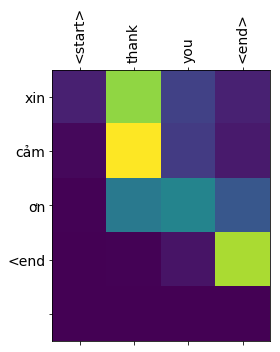


Input:  <start> so max by taking all these samples of lets say 10 000 people youll be able to tell whos healthy and whos not <end>
Groundtruth:  <start> tom rielly vậy max bằng cách lấy tất cả các mẫu cho là của 10 000 người đi bạn có thể cho biết ai khoẻ mạnh và ai không <end>
Translation:  <start> vì vậy bằng cách làm tất cả các mẫu vật này hãy nói 10 000 người bạn sẽ có thể nói với ai khoẻ mạnh và ai không <end>
Bleu Score:  67.70512703374042

Input:  <start> what are you going to get out of those samples <end>
Groundtruth:  <start> bạn sẽ kết luận được gì từ những mẫu này <end>
Translation:  <start> bạn sẽ ra từ những mẫu này <end>
Bleu Score:  63.691672051003486


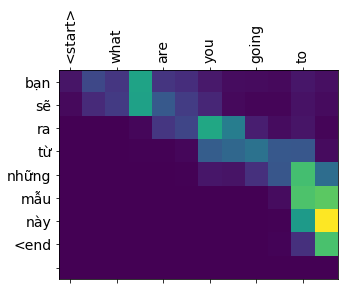


Input:  <start> yeah yeah so what will happen is that during the call you have to indicate whether or not you have the disease or not you see right <end>
Groundtruth:  <start> max little vâng vâng điều sẽ xảy ra là khi gọi bạn phải chỉ rõ bạn có bệnh hay không phải <end>
Translation:  <start> vâng đúng vậy điều gì sẽ xảy ra là trong cuộc gọi là bạn có một ai hay không có hay bệnh bạn không thấy <end>
Bleu Score:  55.55555555555556

Input:  <start> you see some people may not do it they may not get through it <end>
Groundtruth:  <start> bạn thấy đó một số người có thể không làm điều đó có thể họ không gọi tới được <end>
Translation:  <start> bạn thấy một số người không thể làm được nó không thể vượt qua nó <end>
Bleu Score:  60.43763952211456

Input:  <start> but well get a very large sample of data that is collected from all different circumstances and its getting it in different circumstances that matter because then we are looking at ironing out the confounding factors and looking f

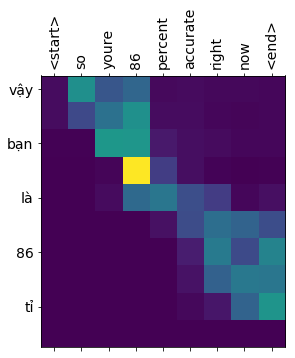


Input:  <start> its much better than that <end>
Groundtruth:  <start> hơn mức đó nhiều chứ <end>
Translation:  <start> nó tốt hơn thế <end>
Bleu Score:  42.324086244530704


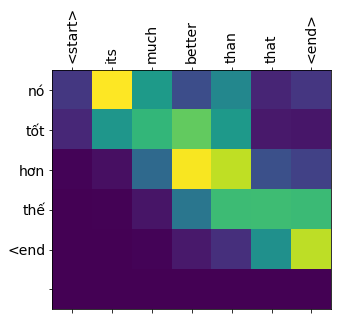


Input:  <start> actually my student thanasis i have to plug him because hes done some fantastic work and now he has proved that it works over the mobile telephone network as well which enables this project and were getting 99 percent accuracy <end>
Groundtruth:  <start> thực ra sinh viên của tôi thanasis tôi phải khen ngợi anh ta bởi vì anh ấy đã làm một số công việc tuyệt vời anh ta đã chứng minh được rằng điều này còn có thể thực hiện được qua mạng điện thoại di động nữa điều đó cho phép dự án này được thực hiện và độ chính xác đang đạt đến 99 phần trăm <end>
Translation:  <start> thực ra học sinh tôi phải cắm điện cho anh vì anh ta đã làm một công việc tuyệt vời và giờ ông đã chứng minh rằng nó hiệu quả trong việc điện thoại di động đó là cho phép dự án này và nó có thể hiện nay là dự án chính xác hơn và cho phép chúng cho
Bleu Score:  53.20044140903014

Input:  <start> ninety nine well thats an improvement <end>
Groundtruth:  <start> chín mươi chín vâng một tiến bộ tớn <end>
Trans

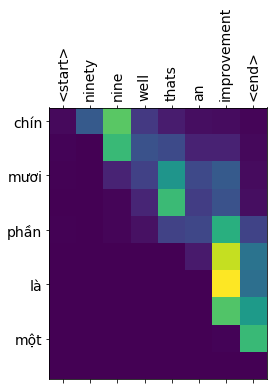


Input:  <start> so what that means is that people will be able to people will be able to call in from their mobile phones and do this test and people with parkinsons could call in record their voice and then their doctor can check up on their progress see where theyre doing in this course of the disease <end>
Groundtruth:  <start> vậy điều đó có nghĩa là mọi người sẽ có thể mọi người có thể gọi từ điện thoại di động của họ và làm bài kiểm tra này và những người có bệnh parkinson có thể gọi ghi âm giọng nói của họ và sau đó bác sĩ có thể kiểm tra sự tiến triển của họ xem tình trạng sức khoẻ của họ khi mang bệnh <end>
Translation:  <start> vậy điều đó có nghĩa là mọi người sẽ có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có
Bleu Score:  26.874941706221954

Input:  <start> absolutely <end>
Groundtruth:  <start> chính xác <end>
Translation:  <start> hoàn toàn <e

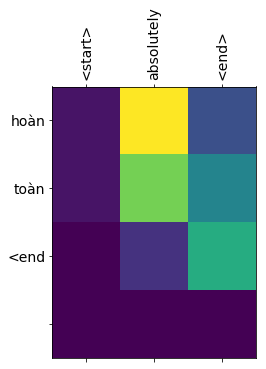


Input:  <start> thanks so much max little everybody <end>
Groundtruth:  <start> cảm ơn rất nhiều hoan nghênh max little nào mọi người <end>
Translation:  <start> cảm ơn rất nhiều người đều <end>
Bleu Score:  46.83537499541165


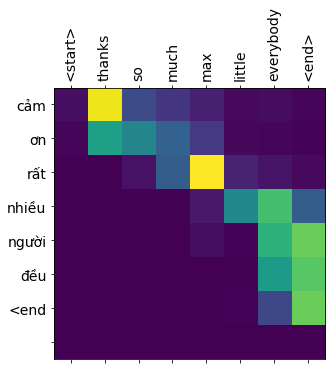


Input:  <start> thanks tom <end>
Groundtruth:  <start> cảm ơn nhiều tom <end>
Translation:  <start> xin chào <end>
Bleu Score:  30.326532985631673


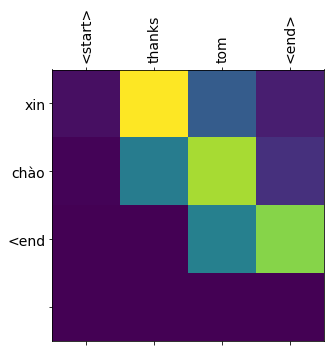


Input:  <start> i live in south central <end>
Groundtruth:  <start> tôi sống ở vùng trung nam <end>
Translation:  <start> tôi sống ở miền nam trung tâm <end>
Bleu Score:  77.77777777777779


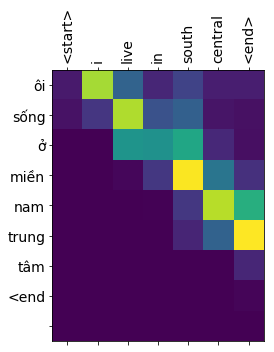


Input:  <start> this is south central liquor stores fast food vacant lots <end>
Groundtruth:  <start> đây là vùng trung nam cửa hàng rượu đồ ăn nhanh đất hoang <end>
Translation:  <start> đây là nam châm điện cho xe đạp rất nhanh <end>
Bleu Score:  38.94003915357025

Input:  <start> so the city planners they get together and they figure theyre going to change the name south central to make it represent something else so they change it to south los angeles like this is going to fix whats really going wrong in the city <end>
Groundtruth:  <start> vì vậy các nhà hoạch định thành phố họp lại với nhau và họ định thay cái tên nam trung để nó mang ý nghĩa khác vậy nên họ đổi thành vùng nam los langeles như thể việc đó sẽ giải quyết được những rắc rối đang thực sự diễn ra trong thành phố <end>
Translation:  <start> vậy thành phố nhà họ kết hợp lại và họ tìm ra chúng là thay đổi tên miền nam trung hoa để làm cho thấy một thứ khác nữa nên chúng thay đổi nó sẽ làm thay đổi nó thành phố <end>
Ble

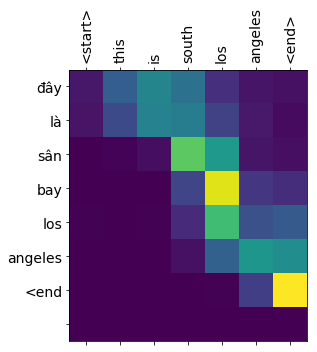


Input:  <start> liquor stores fast food vacant lots <end>
Groundtruth:  <start> cửa hàng rượu đồ ăn nhanh đất hoang <end>
Translation:  <start> vì vậy các nhà thiết kế mua sắm rất nhiều <end>
Bleu Score:  16.666666666666668

Input:  <start> just like 26 5 million other americans i live in a food desert south central los angeles home of the drive thru and the drive by <end>
Groundtruth:  <start> cũng giống như 26 5 triệu người mĩ khác tôi sống trong một sa mạc thức ăn vùng nam trung los angeles ngôi nhà của quầy phục vụ đồ ăn nhanh bên đường và gậy tai nạn rồi bỏ chạy <end>
Translation:  <start> chỉ như 26 5 triệu người mỹ sống ở một khu vực sa mạc trung tâm los angeles và nhà hoạt động loanh quanh <end>
Bleu Score:  33.2574151684021

Input:  <start> funny thing is the drive thrus are killing more people than the drive bys <end>
Groundtruth:  <start> điều thú vị là đồ ăn nhanh bên đường đang giết chết nhiều người hơn gây tai nạn rồi bỏ chạy <end>
Translation:  <start> buồn cười là điều

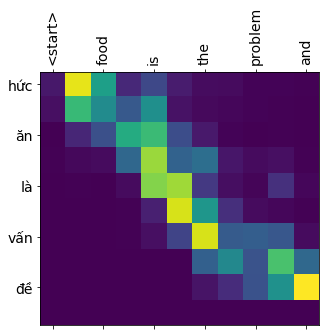


Input:  <start> plus i got tired of driving 45 minutes round trip to get an apple that wasnt impregnated with pesticides <end>
Groundtruth:  <start> với lại tôi cũng cảm thấy mệt mỏi với việc phải lái xe 45 phút chỉ để mua một quả táo không nhiễm thuộc trừ sâu <end>
Translation:  <start> thêm vào đó tôi đã đau đớn đến 45 phút để đi một cái apple một con không phải là không phải là không phải là không phải là không phải là không phải là không phải là không phải là không phải là không phải là không phải là không phải là không phải là không phải là không
Bleu Score:  13.11475409836066

Input:  <start> so what i did i planted a food forest in front of my house <end>
Groundtruth:  <start> điều mà tôi đã làm là trồng một rừng thực phẩm ở trước nhà <end>
Translation:  <start> vậy nên tôi đã làm tôi trồng một khu vườn thực tế ở phía nhà tôi <end>
Bleu Score:  55.55555555555556

Input:  <start> it was on a strip of land that we call a parkway <end>
Groundtruth:  <start> nó nằm trên một dải đất

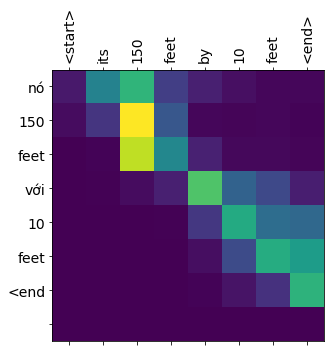


Input:  <start> thing is its owned by the city <end>
Groundtruth:  <start> vấn đề là mảnh đất đó thuộc về thành phố <end>
Translation:  <start> điều đó là sở hữu bằng thành phố <end>
Bleu Score:  49.12384518467891


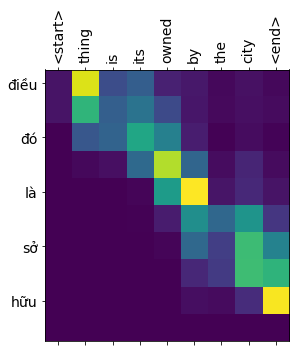


Input:  <start> but you have to maintain it <end>
Groundtruth:  <start> nhưng bạn phải trông giữ nó <end>
Translation:  <start> nhưng bạn phải giữ gìn nó <end>
Bleu Score:  87.5


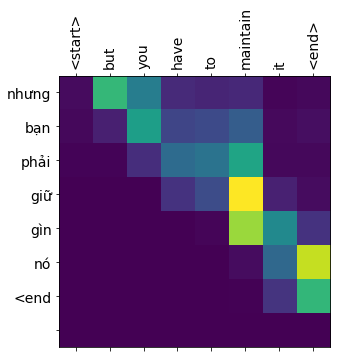


Input:  <start> so im like cool i can do whatever the hell i want since its my responsibility and i gotta maintain it <end>
Groundtruth:  <start> nên tôi nghĩ tuyệt tôi có thể làm việc gì tôi muốn bởi vì đó là trách nhiệm của tôi và tôi phải trông giữ nó <end>
Translation:  <start> tôi rất thích tôi có thể làm bất cứ thứ gì tôi sẽ muốn kể cả trách nhiệm của mình và tôi phải giữ nó <end>
Bleu Score:  64.2426962867524

Input:  <start> and this is how i decided to maintain it <end>
Groundtruth:  <start> và đây là cách mà tôi trông giữ mảnh đất đó <end>
Translation:  <start> và đây là cách tôi quyết định giữ nó <end>
Bleu Score:  60.63657586001313

Input:  <start> so me and my group l a green grounds we got together and we started planting my food forest fruit trees you know the whole nine vegetables <end>
Groundtruth:  <start> tôi cùng với nhóm của tôi những mảnh đất xanh l a chúng tôi tụ họp lại và bắt đầu trồng khu rừng thực phẩm cây ăn quả bạn biết đấy cả chín loại rau quả <end>
Trans

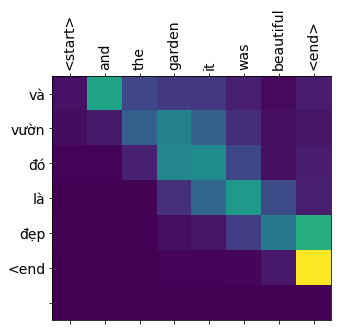


Input:  <start> and then somebody complained <end>
Groundtruth:  <start> rồi sau đó có người than phiền <end>
Translation:  <start> và rồi ai đó phàn nàn <end>
Bleu Score:  44.124845129229776


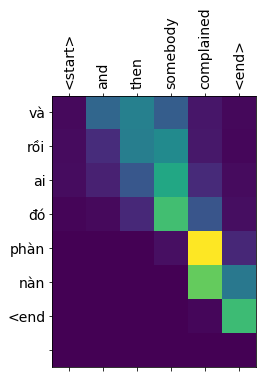


Input:  <start> the city came down on me and basically gave me a citation saying that i had to remove my garden which this citation was turning into a warrant <end>
Groundtruth:  <start> thành phố tới gặp tôi và đại khái là đưa cho tôi một công văn yêu cầu tôi phải phá bỏ mảnh vườn công văn đó sau này trở thành trát của toà <end>
Translation:  <start> thành phố đã xuống xuống tôi và tôi cho tôi một trích dẫn tôi rằng tôi phải tháo máy vườn mà tôi trích dẫn của tôi đã nhấn chìm vào một bài viết <end>
Bleu Score:  37.142857142857146

Input:  <start> and im like come on really <end>
Groundtruth:  <start> và tôi như thể thôi nào thật à <end>
Translation:  <start> và tôi muốn nói chuyện đó <end>
Bleu Score:  38.94003915357025


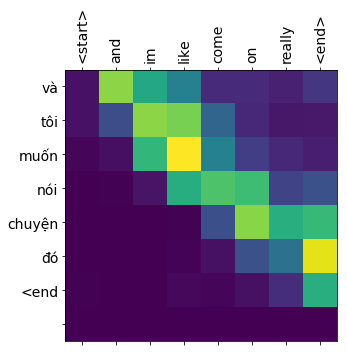


Input:  <start> a warrant for planting food on a piece of land that you could care less about <end>
Groundtruth:  <start> một trát hầu toà vì trồng cây trên mảnh đất mà các người không thèm quan tâm sao <end>
Translation:  <start> một buổi thuyết phục cho việc trồng thức ăn trên một mảnh đất mà bạn có thể quan tâm ít hơn <end>
Bleu Score:  43.47826086956522

Input:  <start> and i was like cool bring it <end>
Groundtruth:  <start> và tôi nói rằng được mang tới đây <end>
Translation:  <start> và tôi thích thú với nó <end>
Bleu Score:  38.94003915357025


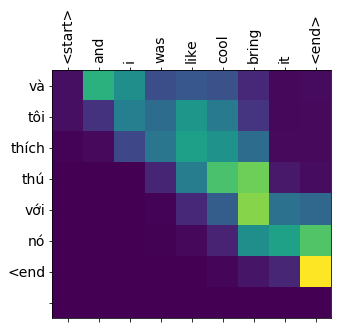


Input:  <start> because this time it wasnt coming up <end>
Groundtruth:  <start> vì lần này thì chuyện này không tới đâu <end>
Translation:  <start> bởi vì lần này không phải đi lên <end>
Bleu Score:  54.290245082157575


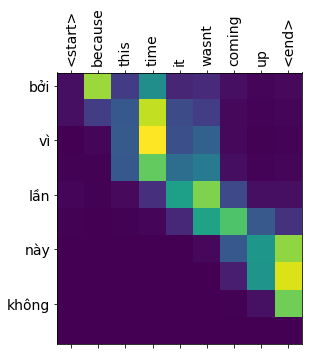


Input:  <start> so l a times got ahold of it steve lopez did a story on it and talked to the councilman and one of the green grounds members they put up a petition on change org and with 900 signatures we were a success <end>
Groundtruth:  <start> rồi tờ l a times nhận được tin steve lopez viết một bài báo về nó và bàn với uỷ viên hội đồng rồi một trong các thành viên của những mảnh đất xanh gửi một tờ đơn kiến nghị trên change org và với 900 chữ ký chúng tôi đã thành công <end>
Translation:  <start> vậy l a có một thời gian ở ted fellow tại ted đã làm một câu chuyện về chuyện và nói về những câu chuyện và nói về một cái màu xanh lá cây chúng ta được một kế hoạch định thay đổi bánh mì và chúng ta là một thành công <end>
Bleu Score:  30.903855975257805

Input:  <start> we had a victory on our hands <end>
Groundtruth:  <start> chúng tôi đã có được một chiến thắng trong tay <end>
Translation:  <start> chúng tôi có một chiến thắng trong tay <end>
Bleu Score:  81.87307530779819


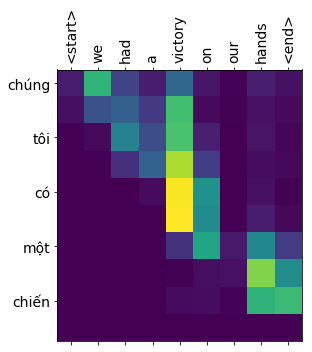


Input:  <start> my councilman even called in and said how they endorse and love what were doing <end>
Groundtruth:  <start> uỷ viên hội đồng đó thậm chí còn gọi tới và nói rằng họ tán thành và thích việc mà chúng tôi đang làm <end>
Translation:  <start> tôi tình của tôi gọi là nói và làm thế nào và quan tâm và những gì chúng tôi đang làm <end>
Bleu Score:  38.1614666644427

Input:  <start> i mean come on why wouldnt they <end>
Groundtruth:  <start> ý tôi là thôi nào tại sao lại không chứ <end>
Translation:  <start> ý tôi là tại sao lại không <end>
Bleu Score:  71.65313105737893


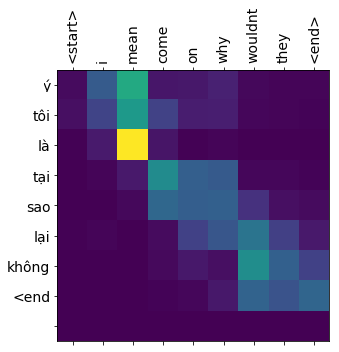


Input:  <start> l a leads the united states in vacant lots that the city actually owns <end>
Groundtruth:  <start> l a dẫn đầu nước mỹ về diện tích đất hoang mà thành phố sở hữu <end>
Translation:  <start> l a đến mỹ và rất nhiều thành phố <end>
Bleu Score:  33.677212640912295

Input:  <start> they own 26 square miles of vacant lots <end>
Groundtruth:  <start> họ sở hữu 42 kilomet vuông đất bỏ hoang <end>
Translation:  <start> họ hành động đất nước của những người đàn ông rất nhiều <end>
Bleu Score:  28.57142857142857

Input:  <start> thats 20 central parks <end>
Groundtruth:  <start> tương đương với 20 lần công viên trung tâm <end>
Translation:  <start> đó là 20 công viên <end>
Bleu Score:  40.33700871483995


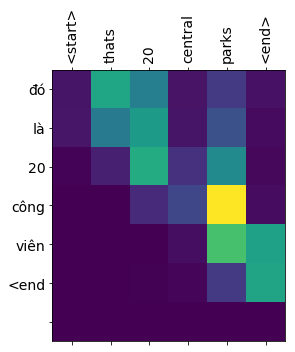


Input:  <start> thats enough space to plant 725 million tomato plants <end>
Groundtruth:  <start> đủ để trồng 725 triệu cây cà chua <end>
Translation:  <start> đó là không gian xây dựng hàng triệu đô la <end>
Bleu Score:  25.0

Input:  <start> why in the hell would they not okay this <end>
Groundtruth:  <start> làm sao họ có thể không đồng tình chứ <end>
Translation:  <start> tại sao nó sẽ không ổn rồi <end>
Bleu Score:  35.5883290185248


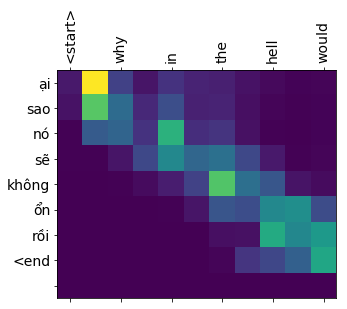


Input:  <start> growing one plant will give you 1 000 10 000 seeds <end>
Groundtruth:  <start> trồng một cây sẽ cho bạn 1 000 10 000 hạt giống <end>
Translation:  <start> trồng một cây trồng sẽ cho bạn 1 000 con <end>
Bleu Score:  70.5401437408845

Input:  <start> when one dollars worth of green beans will give you 75 dollars worth of produce <end>
Groundtruth:  <start> khi lượng đậu xanh có giá 1 đô la sẽ cho bạn lượng sản phẩm tương đương với 75 đô la <end>
Translation:  <start> khi một đô la cho pin xanh lá sẽ cho bạn 75 000 đô la sản phẩm <end>
Bleu Score:  59.69583310028407

Input:  <start> its my gospel when im telling people grow your own food <end>
Groundtruth:  <start> đó là đức tin của tôi khi tôi nói với mọi người hãy tự trồng lấy thực phẩm cho mình <end>
Translation:  <start> đó là tác giả của tôi khi tôi nói với con người lớn lên thực phẩm của mình <end>
Bleu Score:  63.338619262517156

Input:  <start> growing your own food is like printing your own money <end>
Groundtrut

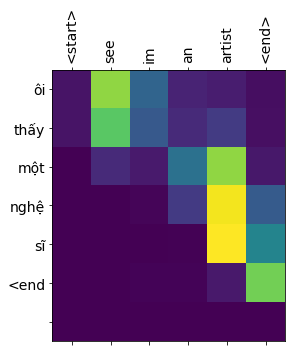


Input:  <start> gardening is my graffiti i grow my art <end>
Groundtruth:  <start> làm vườn là nghệ thuật của tôi tôi trồng ra tác phẩm của mình <end>
Translation:  <start> đóng vai trò của tôi là tôi đã nuôi tôi nghệ thuật của tôi <end>
Bleu Score:  56.25

Input:  <start> just like a graffiti artist where they beautify walls me i beautiful lawns parkways <end>
Groundtruth:  <start> cũng giống như một hoạ sĩ người tô điểm cho các bức tường tôi tôi tô điểm cho những bãi cỏ lối đi dạo <end>
Translation:  <start> giống như một nghệ sĩ graffiti họ vẽ những bức tường tôi xinh đẹp <end>
Bleu Score:  33.453839282436896

Input:  <start> i use the garden the soil like its a piece of cloth and the plants and the trees thats my embellishment for that cloth <end>
Groundtruth:  <start> tôi sử dụng mảnh vườn đất trồng như một tấm vải và cây trồng và cây xanh là những gì tôi tô điểm cho tấm vải đó <end>
Translation:  <start> tôi sử dụng khu vườn đất như thế này là một mảnh vải và cây cối và đó là cá

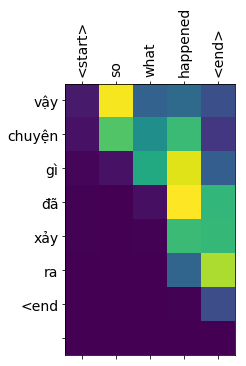


Input:  <start> i have witnessed my garden become a tool for the education a tool for the transformation of my neighborhood <end>
Groundtruth:  <start> tôi đã chứng kiến mảnh vườn của mình trở thành một công cụ giáo dục một công cụ cho sự chuyển đổi của vùng đất tôi sống <end>
Translation:  <start> tôi đã chứng kiến vườn của tôi trở thành một công cụ cho công cụ cho sự kiện cho sự nghiệp của tôi <end>
Bleu Score:  64.76292796143206

Input:  <start> to change the community you have to change the composition of the soil <end>
Groundtruth:  <start> để thay đổi cộng đồng bạn phải thay đổi thành phần của đất <end>
Translation:  <start> để thay đổi cộng đồng mà bạn phải thay đổi thành phần của đất <end>
Bleu Score:  93.75

Input:  <start> we are the soil <end>
Groundtruth:  <start> chúng ta là đất <end>
Translation:  <start> chúng ta là đất <end>
Bleu Score:  100.0


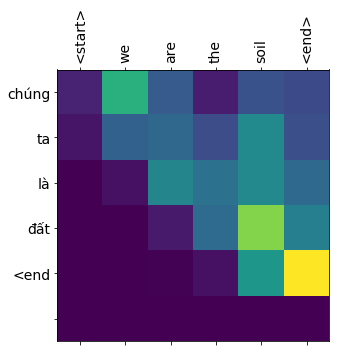


Input:  <start> youd be surprised how kids are affected by this <end>
Groundtruth:  <start> bạn sẽ ngạc nhiên khi thấy cách mà những đứa trẻ bị ảnh hưởng <end>
Translation:  <start> bạn sẽ ngạc nhiên làm thế nào trẻ em bị ảnh hưởng bởi điều này <end>
Bleu Score:  58.82352941176471

Input:  <start> gardening is the most therapeutic and defiant act you can do especially in the inner city <end>
Groundtruth:  <start> làm vườn là công việc có tính trị liệu nhất và thách thức nhất mà bạn có thể làm đặc biệt là ở trong nội thành <end>
Translation:  <start> chính là làm là phương pháp chữa trị và bệnh nhân bạn có thể làm được đặc biệt trong thành phố <end>
Bleu Score:  52.47489510817519

Input:  <start> plus you get strawberries <end>
Groundtruth:  <start> với lại bạn còn thu được dâu nữa <end>
Translation:  <start> cộng thêm bạn có dâu <end>
Bleu Score:  37.225089001774606


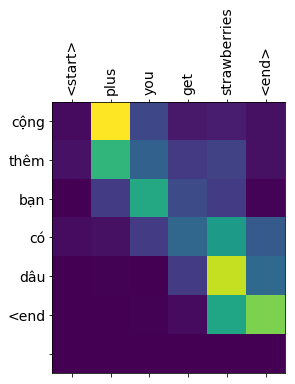


Input:  <start> i remember this time there was this mother and a daughter came it was like 10 30 at night and they were in my yard and i came out and they looked so ashamed <end>
Groundtruth:  <start> tôi nhớ có một lần có một người mẹ và con gái tới lúc đó là khoảng 10 30 tối và họ ở trong vườn của tôi rồi tôi đi ra ngoài và họ rất xấu hổ <end>
Translation:  <start> tôi nhớ lần này đây là mẹ và con gái đó là một lần nữa chỉ khoảng 10 30 đêm và tôi đã đi và họ phải ngượng ngùng <end>
Bleu Score:  49.84163799103921

Input:  <start> so im like man it made me feel bad that they were there and i told them you know you dont have to do this like this <end>
Groundtruth:  <start> tôi nghĩ trời ạ tôi cảm thấy rất tệ vì họ ở đó và tôi nói với họ rằng hai người biết đấy không cần phải làm như vậy <end>
Translation:  <start> tôi rất thích người đàn ông ấy khiến tôi cảm thấy rằng những người xấu hổ vì tôi nói với bạn biết bạn không biết phải không <end>
Bleu Score:  51.495661479267454

Input:  <st

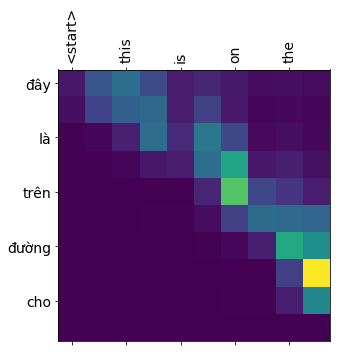


Input:  <start> it made me feel ashamed to see people that were this close to me that were hungry and this only reinforced why i do this and people asked me fin arent you afraid people are going to steal your food <end>
Groundtruth:  <start> tôi cảm thấy xấu hổ khi nhìn thấy có người ở gần tôi đến vậy mà vẫn bị đói và việc đó chỉ càng củng cố thêm lý do để tôi làm việc này mọi người hỏi tôi fin anh không sợ là người ta sẽ ăn trộm thực phẩm của anh sao <end>
Translation:  <start> nó khiến tôi cảm thấy xấu hổ khi nhìn thấy người ta là người này gần như tôi đang đói và điều này là những người ta yêu cầu tôi không làm ngươi làm như thế này và người ta yêu cầu tôi không làm ngươi làm như thế này và người ta yêu cầu tôi không làm ngươi làm
Bleu Score:  37.704918032786885

Input:  <start> and im like hell no i aint afraid theyre gonna steal it <end>
Groundtruth:  <start> tôi trả lời tất nhiên là không tôi không sợ họ sẽ ăn trộm <end>
Translation:  <start> và tôi không thể tôi không sợ rằng m

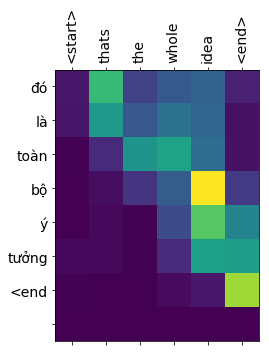


Input:  <start> i want them to take it but at the same time i want them to take back their health <end>
Groundtruth:  <start> tôi muốn họ lấy chúng nhưng cùng lúc đó tôi muốn họ có lại được sức khoẻ của mình <end>
Translation:  <start> tôi muốn họ muốn nó nhưng cùng lúc đó tôi muốn họ trở lại sức khoẻ của mình <end>
Bleu Score:  80.85450108256069

Input:  <start> theres another time when i put a garden in this homeless shelter in downtown los angeles <end>
Groundtruth:  <start> có một lần khác khi tôi làm vườn tại một khu vô gia cư ở trung tâm los angeles <end>
Translation:  <start> có một thời gian khác tôi đặt một khu vườn thú những người vô gia cư ở khu phố los angeles <end>
Bleu Score:  65.21739130434783

Input:  <start> these are the guys they helped me unload the truck <end>
Groundtruth:  <start> có mấy người đàn ông họ giúp tôi dỡ đồ từ xe tải <end>
Translation:  <start> đây là những người này đã giúp tôi giảm tải đường xe tải <end>
Bleu Score:  46.666666666666664

Input:  <sta

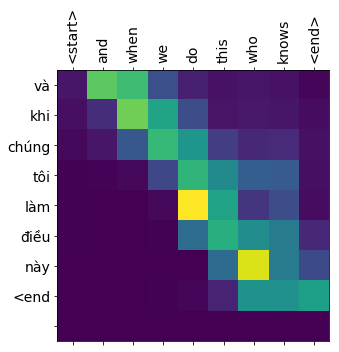


Input:  <start> we might produce the next george washington carver <end>
Groundtruth:  <start> có thể ta sẽ sản sinh ra george washington carver tiếp theo <end>
Translation:  <start> chúng ta có thể sản xuất ra tiếng anh đã được phát hiện ra tiếng anh đã được chứng minh <end>
Bleu Score:  31.818181818181817

Input:  <start> but if we dont change the composition of the soil we will never do this <end>
Groundtruth:  <start> nhưng nếu ta không thay đổi thành phần của đất ta sẽ không bao giờ làm được việc đó <end>
Translation:  <start> nhưng nếu chúng ta không thay đổi phần của các vùng đất chúng ta sẽ không bao giờ làm điều này <end>
Bleu Score:  73.91304347826086

Input:  <start> now this is one of my plans this is what i want to do <end>
Groundtruth:  <start> đây là một trong những kế hoạch của tôi đây là điều mà tôi muốn làm <end>
Translation:  <start> đây là một trong những kế hoạch của tôi đây là điều tôi muốn làm <end>
Bleu Score:  94.28731438548749

Input:  <start> i want to plant

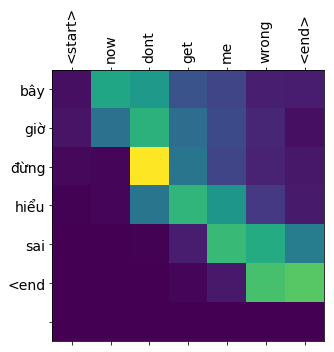


Input:  <start> im not talking about no free shit because free is not sustainable <end>
Groundtruth:  <start> tôi không nói về những thứ miễn phí bởi miễn phí thì không bền vững <end>
Translation:  <start> tôi không nói về việc không có vẻ bất ngờ không miễn phí không phải là bền vững <end>
Bleu Score:  55.00000000000001

Input:  <start> the funny thing about sustainability you have to sustain it <end>
Groundtruth:  <start> điều thú vị về sự bền vững đó là bạn phải duy trì nó <end>
Translation:  <start> điều thú vị về sự bền vững bạn phải vươn tới nó <end>
Bleu Score:  74.303819978587

Input:  <start> what im talking about is putting people to work and getting kids off the street and letting them know the joy the pride and the honor in growing your own food opening farmers markets <end>
Groundtruth:  <start> tôi đang nói về việc giao công việc cho mọi người và kéo bọn trẻ ra khỏi phố và cho chúng biết niềm vui niềm tự hào và niềm vinh dự khi tự trồng thực phẩm cho mình mở chợ cho nông

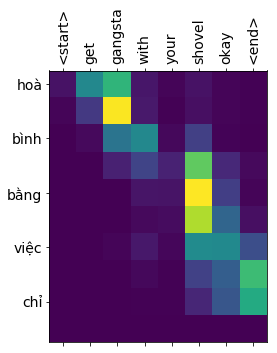


Input:  <start> and let that be your weapon of choice <end>
Groundtruth:  <start> và hãy biến nó thành vũ khí bạn chọn <end>
Translation:  <start> và để chúng tôi là lựa chọn của bạn lựa chọn <end>
Bleu Score:  38.46153846153847

Input:  <start> so basically if you want to meet with me you know if you want to meet dont call me if you want to sit around in cushy chairs and have meetings where you talk about doing some shit where you talk about doing some shit <end>
Groundtruth:  <start> căn bản là nếu bạn muốn gặp tôi bạn biết đấy nếu bạn muốn gặp đừng gọi tôi nếu bạn muốn ngồi không trên những chiếc ghế êm ái và tham gia những cuộc họp nơi bạn nói về làm này làm nọ nơi bạn nói về làm này làm nọ vớ vẩn <end>
Translation:  <start> vì vậy cơ bản nếu bạn muốn gặp nhau tôi biết nếu bạn muốn gặp tôi nếu tôi muốn ngồi quanh giường êm đẹp và có những cuộc sống <end>
Bleu Score:  31.23414448174732

Input:  <start> if you want to meet with me come to the garden with your shovel so we can plant 

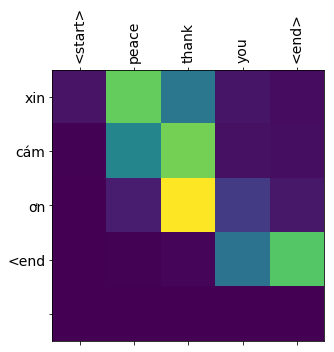


Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> xin cảm ơn <end>
Bleu Score:  80.0


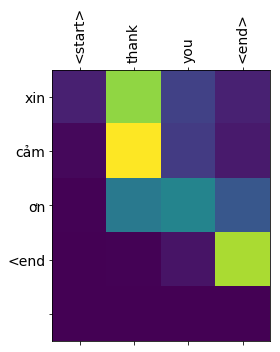


Input:  <start> this is where i live i live in kenya at the south parts of the nairobi national park <end>
Groundtruth:  <start> đây là nơi tôi sống tôi sống ở kenya phía nam công viên quốc gia nairobi <end>
Translation:  <start> đây là nơi tôi sống ở kenya ở miền nam giới <end>
Bleu Score:  52.36249217872195

Input:  <start> those are my dads cows at the back and behind the cows thats the nairobi national park <end>
Groundtruth:  <start> phía sau tôi là đàn bò của bố tôi và phía sau đàn bò là công viên quốc gia nairobi <end>
Translation:  <start> đó là những người bạn đang ở đâu và sau đó là những công viên quốc gia <end>
Bleu Score:  44.944192927554475

Input:  <start> nairobi national park is not fenced in the south widely which means wild animals like zebras migrate out of the park freely <end>
Groundtruth:  <start> công viên quốc gia nairobi không được rào chắn trên diện rộng ở khu vực phía nam điều đó có nghĩa là các động vật hoang dã như ngựa vằn thoát ra khỏi công viên một các

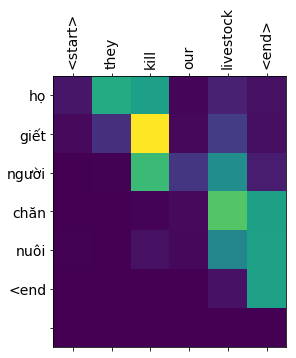


Input:  <start> this is one of the cows which was killed at night and i just woke up in the morning and i found it dead and i felt so bad because it was the only bull we had <end>
Groundtruth:  <start> đây là một trong số những con bò đã bị giết vào buổi tối và khi thức dậy vào buổi sáng tôi tìm thấy nó đã chết và tôi đã cảm thấy rất buồn bởi vì đó là con bò đực duy nhất mà chúng tôi có <end>
Translation:  <start> đây là một con bò mà bị giết vào ban đêm và tôi nhận ra nó và tôi cảm thấy xấu vì nó chỉ là con bò tót <end>
Bleu Score:  38.92675970788102

Input:  <start> my community the maasai we believe that we came from heaven with all our animals and all the land for herding them and thats why we value them so much <end>
Groundtruth:  <start> cộng đồng của tôi người maasai tin rằng chúng tôi đến từ thiên đường cùng với tất cả các con vật của mình và tất cả đất đai để chăn giữ chúng đó là lý do vì sao chúng tôi rất coi trọng chúng <end>
Translation:  <start> cộng đồng của tôi cộng đồn

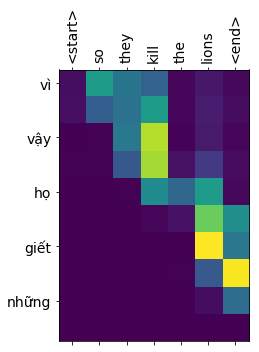


Input:  <start> its one of the six lions which were killed in nairobi <end>
Groundtruth:  <start> đây là một trong sáu con sư tử đã bị giết ở nairobi <end>
Translation:  <start> đó là một trong những con sư tử mà chúng tôi đã giết trong nairobi <end>
Bleu Score:  64.70588235294117

Input:  <start> and i think this is why the nairobi national park lions are few <end>
Groundtruth:  <start> và tôi nghĩ đây là lý do mà sư tử ở công viên quốc gia nairobi còn rất ít <end>
Translation:  <start> và tôi nghĩ đây là lý do tại các công ty của những nhà sư tử đang được phân chia <end>
Bleu Score:  54.54545454545454

Input:  <start> so a boy from six to nine years old in my community is responsible for his dads cows and thats the same thing which happened to me <end>
Groundtruth:  <start> mỗi đứa con trai từ 6 đến 9 tuổi trong cộng đồng của tôi chịu trách nhiệm chăn giữ những con bò của bố mình và tôi cũng phải làm điều tương tự <end>
Translation:  <start> vì vậy một cậu bé từ 6 9 tuổi trong cộng 

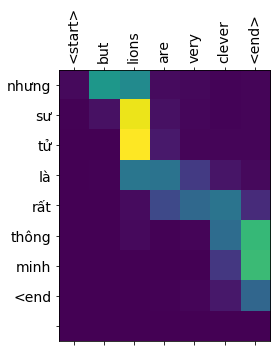


Input:  <start> they will come the first day and they see the scarecrow and they go back but the second day theyll come and they say this thing is not moving here its always here <end>
Groundtruth:  <start> chúng tới ngày đầu tiên và nhìn thấy con bù nhìn và rồi chúng quay về nhưng ngày thứ 2 chúng đến và nói rằng thứ này không hề chuyển động nó luôn luôn chỉ ở đó <end>
Translation:  <start> họ sẽ đến ngày đầu tiên và họ nhìn thấy và nhìn thấy và họ quay trở lại thứ hai họ sẽ đến và nói rằng điều này không phải di chuyển ở đây <end>
Bleu Score:  51.11357859051796

Input:  <start> so he jumps in and kills the animals <end>
Groundtruth:  <start> và rồi sư tử nhảy vào và giết gia súc <end>
Translation:  <start> vậy nên ông nhảy xuống và giết chết động vật <end>
Bleu Score:  41.66666666666667

Input:  <start> so one night i was walking around the cowshed with a torch and that day the lions didnt come <end>
Groundtruth:  <start> vì thế vào một đêm tôi cầm một cây đuốc đi xung quanh chuồng 

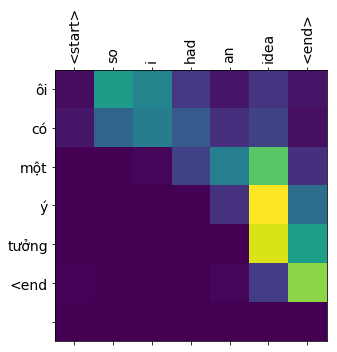


Input:  <start> since i was a small boy i used to work in my room for the whole day and i even took apart my moms new radio and that day she almost killed me but i learned a lot about electronics <end>
Groundtruth:  <start> từ khi còn nhỏ tôi đã từng làm việc ở trong phòng mình cả ngày và tôi thậm chí đã mở tung chiếc radio mới mua của mẹ vào hôm đó bà gần như giết tôi nhưng tôi đã học được nhiều điều về điện <end>
Translation:  <start> từ khi tôi là một cậu bé tôi đã từng làm việc trong phòng trong phòng cho tôi và cả khi tôi đã đi xa những bà mẹ tôi và những bà ấy đã biết tôi biết nhiều về điện tử <end>
Bleu Score:  48.73712355792674

Input:  <start> so i got an old car battery an indicator box its a small device found in a motorcycle and it helps motorists when they want to turn right or left it blinks <end>
Groundtruth:  <start> thế nên tôi đã lấy một bình ắc quy xe ô tô cũ một hộp đồng hồ đo nó là một thiết bị nhỏ được tìm thấy ở xe mô tô và nó giúp người lái mô tô ra hiệu khi họ

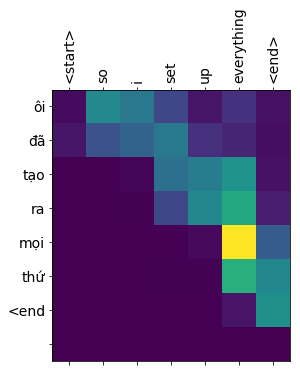


Input:  <start> as you can see the solar panel charges the battery and the battery supplies the power to the small indicator box i call it a transformer <end>
Groundtruth:  <start> như các bạn có thể thấy tấm pin mặt trời dùng để xạc ắc quy và bình ắc quy cung cấp năng lượng cho hộp đồng hồ đo tôi gọi nó là máy biến thế <end>
Translation:  <start> như bạn có thể thấy mặt trời điện hạt nhân và pin dụng điện hạt nhân và năng lượng điện năng lượng nhỏ cho tôi có thể nó <end>
Bleu Score:  42.23411020462836

Input:  <start> and the indicator box makes the lights flash <end>
Groundtruth:  <start> và chiếc hộp đồng hồ đo làm cho đèn chớp tắt <end>
Translation:  <start> và chiếc xe tải này làm đèn sáng <end>
Bleu Score:  44.449093240903075


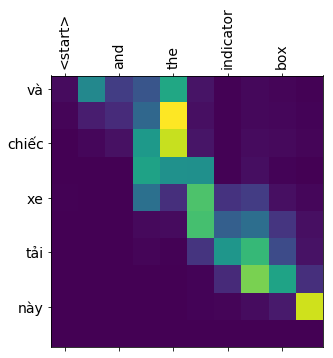


Input:  <start> as you can see the bulbs face outside because thats where the lions come from <end>
Groundtruth:  <start> như các bạn thấy đó các bóng đèn hướng ra phía ngoài bởi vì đó là hướng sư tử tiến vào <end>
Translation:  <start> như bạn có thể thấy bóng đèn bên ngoài bởi vì đó là nơi mà sư tử đến từ <end>
Bleu Score:  60.6104295251142

Input:  <start> and thats how it looks to lions when they come at night <end>
Groundtruth:  <start> và đó là cách mà ánh sáng chiếu về phía sư tử khi chúng đến vào đêm khuya <end>
Translation:  <start> và đó là cách mà chúng ta để sư tử khi chúng đến đêm <end>
Bleu Score:  63.27756362455165

Input:  <start> the lights flash and trick the lions into thinking i was walking around the cowshed but i was sleeping in my bed <end>
Groundtruth:  <start> các bóng đèn chớp tắt và đánh lừa sư tử làm cho chúng nghĩ rằng tôi đang đi xung quanh chuồng bò nhưng thực ra là tôi đang ngủ trên giường của mình <end>
Translation:  <start> ánh sáng loé và những con s

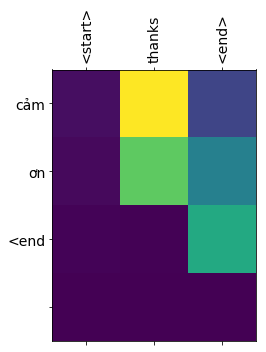


Input:  <start> so i set it up in my home two years ago and since then we have never experienced any problem with lions <end>
Groundtruth:  <start> tôi đã lắp đặt nó ở nhà mình 2 năm trước kể từ đó chúng tôi không hề gặp phải bất cứ vấn đề nào với sư tử cả <end>
Translation:  <start> vì vậy tôi lập trình bày tại nhà tôi trong 2 năm trước và sau đó chúng tôi chưa bao giờ trải qua bất cứ vấn đề gì với sư tử <end>
Bleu Score:  51.515151515151516

Input:  <start> and my neighboring homes heard about this idea <end>
Groundtruth:  <start> các gia đình hàng xóm nghe kể về ý tưởng này <end>
Translation:  <start> và những người nhà của tôi đã nghe về ý tưởng này <end>
Bleu Score:  50.0

Input:  <start> one of them was this grandmother <end>
Groundtruth:  <start> một trong số đó là người bà này <end>
Translation:  <start> một trong số đó là người bà này <end>
Bleu Score:  100.0


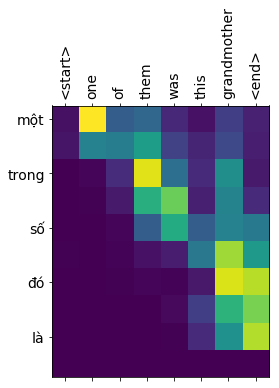


Input:  <start> she had a lot of her animals being killed by lions and she asked me if i could put the lights for her <end>
Groundtruth:  <start> bà có nhiều gia súc đã bị sư tử giết và bà đã hỏi tôi liệu tôi có thể giúp bà lắp các bóng điện <end>
Translation:  <start> cô ấy có rất nhiều con cá voi bị giết bởi sư tử và cô ấy hỏi tôi nếu tôi có thể bật đèn cho cô ấy <end>
Bleu Score:  48.275862068965516

Input:  <start> and i said yes <end>
Groundtruth:  <start> tôi trả lời vâng <end>
Translation:  <start> và tôi trả lời vâng <end>
Bleu Score:  85.71428571428571


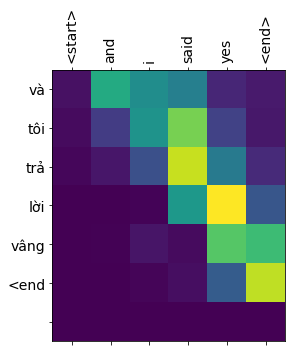


Input:  <start> so i put the lights you can see at the back those are the lion lights <end>
Groundtruth:  <start> thế là tôi lắp đặt các bóng đèn các bạn có thể nhìn thấy ở đằng sau chúng là các bóng đèn sư tử <end>
Translation:  <start> vì vậy tôi đặt đèn sáng bạn có thể thấy ở đây là những chiếc lều sư tử <end>
Bleu Score:  48.153184344311676

Input:  <start> since now ive set up seven homes around my community and theyre really working <end>
Groundtruth:  <start> cho đến nay tôi đã giúp lắp đặt cho 7 hộ gia đình trong cộng đồng của mình và chúng đều hoạt động hiệu quả <end>
Translation:  <start> kể từ bây giờ tôi đã lên 7 7 nhà tôi và họ thực sự đang thực sự <end>
Bleu Score:  21.1406426915614

Input:  <start> and my idea is also being used now all over kenya for scaring other predators like hyenas leopards and its also being used to scare elephants away from peoples farms <end>
Groundtruth:  <start> hiện nay ý tưởng của tôi đã được sử dụng trên khắp kenya để xua đuổi các động vật 

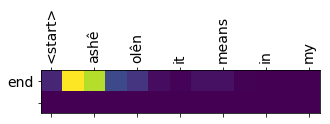


Input:  <start> you have no idea how exciting it is to hear a story like yours <end>
Groundtruth:  <start> cháu không biết là thật là thú vị biết bao khi nghe câu chuyện của cháu <end>
Translation:  <start> bạn không biết không thể nghe về một câu chuyện như là của riêng của bạn <end>
Bleu Score:  50.0

Input:  <start> so you got this scholarship yep <end>
Groundtruth:  <start> vậy là cháu đã có học bổng này vâng <end>
Translation:  <start> vậy nên bạn có một số học bổng này <end>
Bleu Score:  63.63636363636363

Input:  <start> youre working on other electrical inventions <end>
Groundtruth:  <start> cháu đang làm những phát minh về điện khác <end>
Translation:  <start> bạn đang làm việc tạo ra các loại hình thức khác <end>
Bleu Score:  38.46153846153847

Input:  <start> whats the next one on your list <end>
Groundtruth:  <start> phát minh nào tiếp theo trong danh sách của cháu <end>
Translation:  <start> cái gì tiếp theo của bạn <end>
Bleu Score:  37.908166232039584


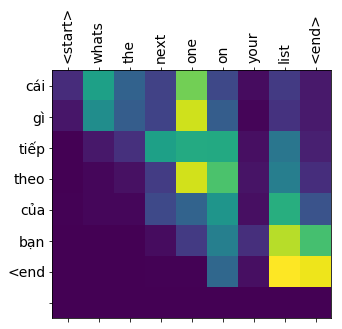


Input:  <start> my next invention is i want to make an electric fence electric fence <end>
Groundtruth:  <start> phát minh sắp tới của cháu cháu muốn làm một hàng rào điện hàng rào điện sao <end>
Translation:  <start> tôi phát triển một cái máy giặt phim <end>
Bleu Score:  16.26278638962396


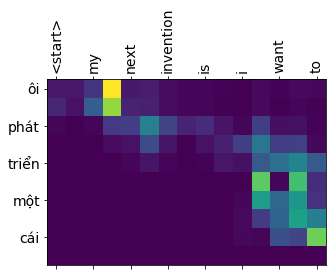


Input:  <start> but i know electric fences are already invented but i want to make mine <end>
Groundtruth:  <start> cháu biết là hàng rào điện đã được phát minh rồi nhưng cháu muốn làm cái của riêng mình <end>
Translation:  <start> nhưng tôi biết đấy những cánh đồng được đưa ra nhưng tôi muốn tạo ra tôi <end>
Bleu Score:  28.2160574963538

Input:  <start> you already tried it once right and you i tried it before but i stopped because it gave me a shock <end>
Groundtruth:  <start> cháu đã thử đúng không và cháu cháu đó thử trước đây nhưng cháu đã dừng lại vì bị giật điện <end>
Translation:  <start> bạn đã thử nó đã từng và tôi cố gắng thử trước nhưng tôi dừng lại vì tôi cho tôi một cú sốc <end>
Bleu Score:  48.0

Input:  <start> in the trenches richard turere you are something else <end>
Groundtruth:  <start> richard turere cháu thật khác biệt <end>
Translation:  <start> trong những năm đó là ông là một thứ khác <end>
Bleu Score:  25.0

Input:  <start> were going to cheer you on every 

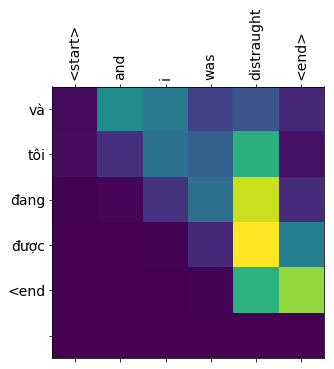


Input:  <start> i thought age 21 that we italians were good people and we were doing good work in africa <end>
Groundtruth:  <start> mới 21 tuổi đời tôi nghĩ người ý là người tốt và chúng tôi đang làm việc tốt tại châu phi <end>
Translation:  <start> tôi nghĩ đến tuổi 21 chúng tôi đã làm chúng tôi là người tốt và chúng tôi đang làm việc tốt trong châu phi <end>
Bleu Score:  69.23076923076923

Input:  <start> instead everything we touched we killed <end>
Groundtruth:  <start> nhưng thay vì thế chúng tôi giết chết mọi thứ mà chúng tôi đụng vào <end>
Translation:  <start> thay vào mọi thứ chúng ta chạm vào chúng ta đã giết <end>
Bleu Score:  51.88614087891787

Input:  <start> our first project the one that has inspired my first book ripples from the zambezi was a project where we italians decided to teach zambian people how to grow food <end>
Groundtruth:  <start> dự án đầu tiên cái đã truyền cảm hứng cho cuốn sách đầu tiên của tôi những cơn sóng nhẹ từ zambezi là một dự án trong đó ngườ

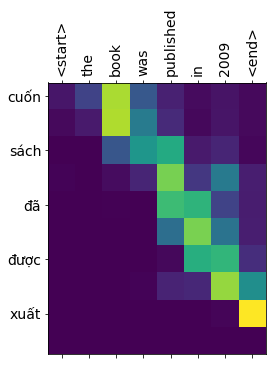


Input:  <start> we western donor countries have given the african continent two trillion american dollars in the last 50 years <end>
Groundtruth:  <start> chúng ta những quốc gia viện trợ tây phương đã mang đến lục địa châu phi 2 tỉ tỉ mỹ kim trong vòng 50 năm qua <end>
Translation:  <start> chúng tôi phương tây đã được đưa ra châu phi 2 triệu tỷ đô la trong 50 năm qua <end>
Bleu Score:  44.35670017837744

Input:  <start> im not going to tell you the damage that that money has done <end>
Groundtruth:  <start> tôi sẽ không nói với bạn những thiệt hại mà số tiền đó đã gây ra <end>
Translation:  <start> tôi sẽ không nói với các bạn bị tổn thương mà tiền đã được làm <end>
Bleu Score:  61.009438720021315

Input:  <start> just go and read her book <end>
Groundtruth:  <start> hãy tìm đọc cuốn sách của bà ấy <end>
Translation:  <start> chỉ cần đọc và đọc cuốn sách của cô <end>
Bleu Score:  54.54545454545454

Input:  <start> read it from an african woman the damage that we have done <end>
Grou

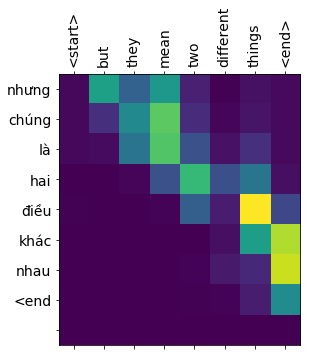


Input:  <start> paternalistic i treat anybody from a different culture as if they were my children i love you so much <end>
Groundtruth:  <start> bảo hộ là tôi đối xử với bất cứ người nào đến từ nền văn hoá khác như thể họ là con tôi tôi yêu chúng quá <end>
Translation:  <start> tôi không đối xử với bất cứ ai đó khác biệt như thể chúng là con cái tôi yêu quý vị <end>
Bleu Score:  53.591749397714494

Input:  <start> patronizing i treat everybody from another culture as if they were my servants <end>
Groundtruth:  <start> bảo trợ tôi đối xử với tất cả mọi người từ nền văn hoá khác như đầy tớ của mình <end>
Translation:  <start> tôi là đối xử với tôi mọi người khác của văn hoá khác nếu như trong gia đình tôi <end>
Bleu Score:  59.02600196588189

Input:  <start> thats why the white people in africa are called bwana boss <end>
Groundtruth:  <start> đó là lí do tại sao người da trắng tại châu phi được gọi là bwana ông chủ <end>
Translation:  <start> đó là lý do tại sao người da trắng ở châu

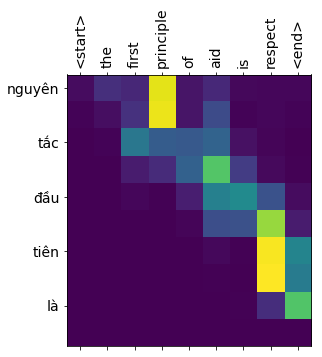


Input:  <start> this morning the gentleman who opened this conference lay a stick on the floor and said can we can you imagine a city that is not neocolonial <end>
Groundtruth:  <start> sáng nay người tổ chức buổi họp này đặt một cây gậy ra sàn nhà và nói liệu chúng ta có thể hình dung về một thành phố mà không phải là chủ nghĩa thực dân mới không <end>
Translation:  <start> sáng nay người đàn ông này mở cửa hàng này một cái máy bay trên sàn nhà và nói có thể có thể tưởng tượng một thành phố mà không <end>
Bleu Score:  43.80754404776652

Input:  <start> i decided when i was 27 years old to only respond to people and i invented a system called enterprise facilitation where you never initiate anything you never motivate anybody but you become a servant of the local passion the servant of local people who have a dream to become a better person <end>
Groundtruth:  <start> khi 27 tuổi tôi đã quyết định chỉ hưởng ứng với mọi người và tôi đã tạo ra một hệ thống gọi là enterprise facilitation

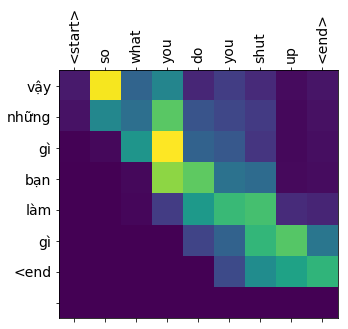


Input:  <start> you never arrive in a community with any ideas and you sit with the local people <end>
Groundtruth:  <start> đừng bao giờ mang đến một cộng đồng với những ý tưởng bạn ngồi với người bản địa <end>
Translation:  <start> bạn chưa bao giờ đến một cộng đồng với bất kỳ ý tưởng và bạn ngồi với những người dân địa <end>
Bleu Score:  73.91304347826086

Input:  <start> we dont work from offices <end>
Groundtruth:  <start> chúng tôi không làm việc từ những văn phòng <end>
Translation:  <start> chúng ta không làm việc từ văn phòng <end>
Bleu Score:  81.43536762323636


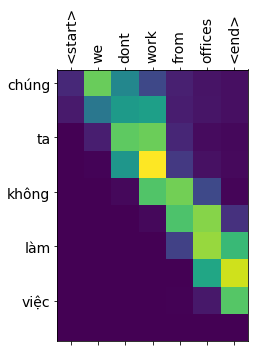


Input:  <start> we meet at the cafe we meet at the pub <end>
Groundtruth:  <start> chúng tôi gặp gỡ tại quán cà phê quán rượu <end>
Translation:  <start> chúng ta gặp nhau ở quán cafe chúng tôi gặp nhau ở quán rượu <end>
Bleu Score:  50.0

Input:  <start> we have zero infrastructure <end>
Groundtruth:  <start> chúng tôi không có bất cứ cơ sở hạ tầng nào <end>
Translation:  <start> chúng ta có 0 cơ sở hạ tầng <end>
Bleu Score:  59.26545765453744


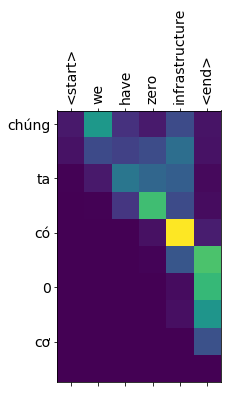


Input:  <start> and what we do we become friends and we find out what that person wants to do <end>
Groundtruth:  <start> và cái chúng tôi làm là trở thành bạn của nhau và tìm ra cái mà người đó muốn làm <end>
Translation:  <start> và những gì chúng tôi làm gì để trở thành bạn bè và tìm ra những người muốn làm gì <end>
Bleu Score:  68.18181818181817

Input:  <start> the most important thing is passion <end>
Groundtruth:  <start> cái quan trọng nhất là khát vọng <end>
Translation:  <start> điều quan trọng nhất là đam mê <end>
Bleu Score:  66.66666666666666


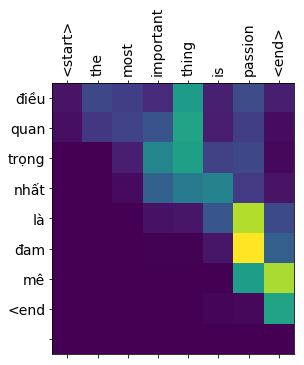


Input:  <start> you can give somebody an idea <end>
Groundtruth:  <start> bạn có thể cho ai đó một ý tưởng <end>
Translation:  <start> bạn có thể cho ai đó một ý tưởng <end>
Bleu Score:  100.0

Input:  <start> if that person doesnt want to do it what are you going to do <end>
Groundtruth:  <start> nếu người đó không muốn làm vậy thì bạn phải làm sao <end>
Translation:  <start> nếu người đó không muốn làm điều đó là bạn sẽ làm gì <end>
Bleu Score:  66.66666666666666

Input:  <start> the passion that the person has for her own growth is the most important thing <end>
Groundtruth:  <start> cái khát vọng của người phụ nữ có cho sự phát triển của bản thân là thứ quan trọng nhất <end>
Translation:  <start> niềm đam mê của người đã giúp đỡ của tôi là sự quan trọng nhất <end>
Bleu Score:  43.83463629491062

Input:  <start> the passion that that man has for his own personal growth is the most important thing <end>
Groundtruth:  <start> cái khát vọng của nam giới có cho sự phát triển của cá nhâ

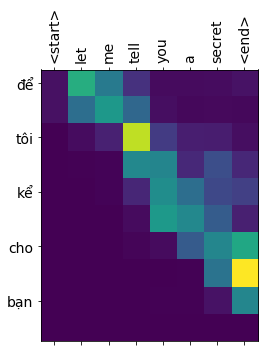


Input:  <start> there is a problem with community meetings <end>
Groundtruth:  <start> có một vần đề trong những cuộc họp cộng đồng <end>
Translation:  <start> có một vấn đề với cộng đồng <end>
Bleu Score:  55.73021304462805


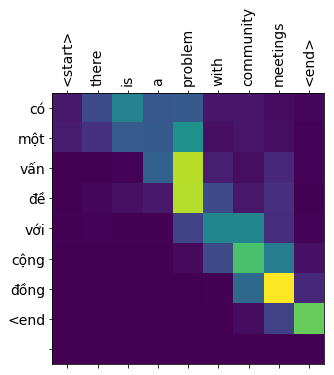


Input:  <start> entrepreneurs never come and they never tell you in a public meeting what they want to do with their own money what opportunity they have identified <end>
Groundtruth:  <start> những doanh nhân chẳng bao giờ đến dự và họ chẳng đời nào cho bạn biết trong buổi họp cộng đồng cái họ muốn làm với tiền của mình cái cơ hội mà họ mới tìm ra <end>
Translation:  <start> doanh nghiệp không bao giờ đến và họ chưa bao giờ nói với bạn trong một cuộc họp công việc họ muốn làm gì với cơ hội họ có thể xác định <end>
Bleu Score:  45.701110424710954

Input:  <start> so planning has this blind spot <end>
Groundtruth:  <start> vậy nên hoạch định có một điểm mù này <end>
Translation:  <start> kế hoạch hoá ra được không thấy không <end>
Bleu Score:  27.145122541078788


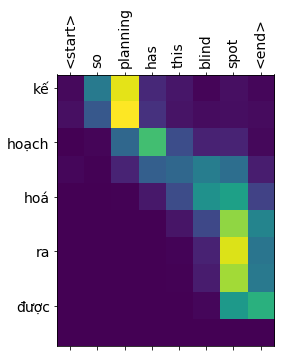


Input:  <start> the smartest people in your community you dont even know because they dont come to your public meetings <end>
Groundtruth:  <start> những người thông thái nhất trong cộng đồng bạn chẳng bao giờ biết được vì họ chẳng đời nào đến dự những buổi họp công cộng <end>
Translation:  <start> những người thông minh nhất trong cộng đồng bạn không biết vì họ không đến với công việc <end>
Bleu Score:  50.27400345267294

Input:  <start> what we do we work one on one and to work one on one you have to create a social infrastructure that doesnt exist <end>
Groundtruth:  <start> cái chúng tôi làm là làm việc một đối một và để làm điều đó bạn phải tạo ra một cấu trúc xã hội hiện không tồn tại <end>
Translation:  <start> chúng tôi làm gì chúng tôi làm việc trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong một trong

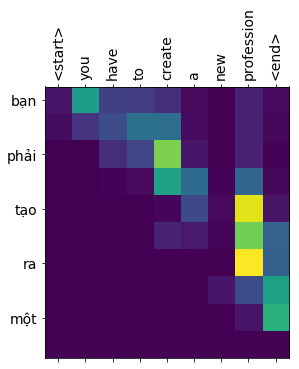


Input:  <start> the profession is the family doctor of enterprise the family doctor of business who sits with you in your house at your kitchen table at the cafe and helps you find the resources to transform your passion into a way to make a living <end>
Groundtruth:  <start> một chuyên ngành mới như một bác sỹ gia đình cho doanh nghiệp bác sỹ gia đình cho công việc làm ăn người ngồi với bạn trong nhà bạn tại bàn cơm trong bếp tại quán cà phê và giúp bạn tìm ra những nguồn tài nguyên để biến khát vọng của bạn thành một phương cách kiếm sống <end>
Translation:  <start> nghề nghiệp là nhà bác sĩ của doanh nghiệp gia đình người trong nhà bạn ở nhà bếp của bạn ở nhà bếp của bạn ở nhà bếp của bạn ở nhà bếp của bạn ở nhà bếp của bạn ở nhà bếp của bạn ở nhà bếp của bạn ở nhà bếp của bạn ở nhà bếp của bạn
Bleu Score:  24.590163934426226

Input:  <start> i started this as a tryout in esperance in western australia <end>
Groundtruth:  <start> tôi đã bắt đầu như một sự thử nghiệm tại esperance t

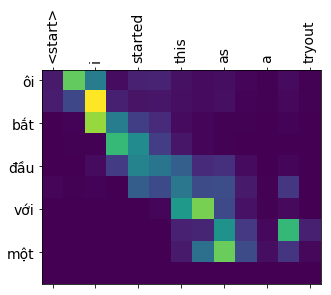


Input:  <start> i was a doing a ph d at the time trying to go away from this patronizing bullshit that we arrive and tell you what to do <end>
Groundtruth:  <start> tôi đang theo học tiến sỹ triết học tại thời điểm đó cố gắng tránh xa khỏi cái phương thức bảo hộ vớ vẩn đó là đến và bảo cho bạn biết phải làm gì <end>
Translation:  <start> tôi là một thí nghiệm tại thời gian cố gắng đi từ những điều này <end>
Bleu Score:  14.511302018662661

Input:  <start> and so what i did in esperance that first year was to just walk the streets and in three days i had my first client and i helped this first guy who was smoking fish from a garage was a maori guy and i helped him to sell to the restaurant in perth to get organized and then the fishermen came to me to say you the guy who helped maori can you help us <end>
Groundtruth:  <start> vậy nên cái mà tôi làm trong năm đầu tiên tại esperance là chỉ bách bộ trên đường và trong 3 ngày tôi có khách hàng đầu tiên một người làm nghề hun khói cá trong

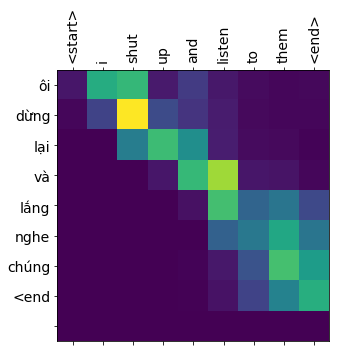


Input:  <start> so so the government says do it again <end>
Groundtruth:  <start> vậy nên vậy nên chính phủ nói với tôi cứ làm tiếp nhé <end>
Translation:  <start> vậy nên chính phủ nói rằng nó lại <end>
Bleu Score:  42.45714617988433


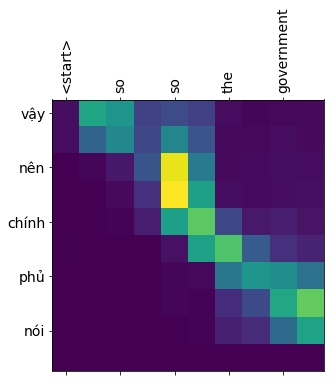


Input:  <start> weve done it in 300 communities around the world <end>
Groundtruth:  <start> chúng tôi đã làm thế tại 300 cộng đồng trên khắp thế giới <end>
Translation:  <start> chúng tôi đã làm nó ở 300 triệu người xung quanh thế giới <end>
Bleu Score:  60.0

Input:  <start> we have helped to start 40 000 businesses <end>
Groundtruth:  <start> chúng tôi đã giúp khởi động 40 000 công việc làm ăn <end>
Translation:  <start> chúng tôi đã bắt đầu tăng cường 40 000 nhà kinh doanh <end>
Bleu Score:  50.0

Input:  <start> there is a new generation of entrepreneurs who are dying of solitude <end>
Groundtruth:  <start> có một thế hệ doanh nhân mới những người đang kiệt quệ vì sự cô lập <end>
Translation:  <start> có một thế hệ mới của những người doanh nghiệp là những người đang chết vì sự độc lập <end>
Bleu Score:  66.66666666666666

Input:  <start> peter drucker one of the greatest management consultants in history died age 96 a few years ago <end>
Groundtruth:  <start> peter drucker một t

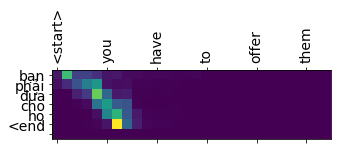


Input:  <start> in a community of 10 000 people we get 200 clients <end>
Groundtruth:  <start> với một cộng đồng 10 000 người chúng ta có thể có khoảng 200 khách hàng <end>
Translation:  <start> trong một cộng đồng 10 000 người chúng tôi có 200 người <end>
Bleu Score:  59.04464445591533

Input:  <start> can you imagine a community of 400 000 people the intelligence and the passion <end>
Groundtruth:  <start> bạn có thể tượng tưởng một cộng đồng 400 000 người vối trí thông minh và khát vọng <end>
Translation:  <start> bạn có thể hình dung một cộng đồng của 400 000 người thông minh và niềm đam mê <end>
Bleu Score:  70.0

Input:  <start> which presentation have you applauded the most this morning <end>
Groundtruth:  <start> bài thuyết trình nào bạn vỗ tay nhiều nhất trong sáng nay <end>
Translation:  <start> bài nói chuyện này bạn có đủ pháo tay <end>
Bleu Score:  34.60456303167608

Input:  <start> local passionate people thats who you have applauded <end>
Groundtruth:  <start> người bản

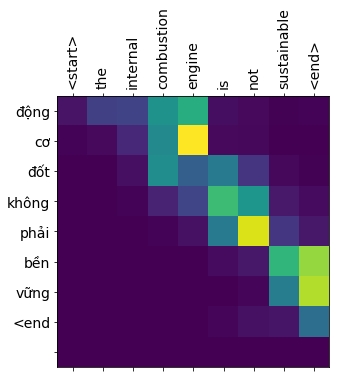


Input:  <start> freon way of maintaining things is not sustainable <end>
Groundtruth:  <start> đường lối freon để lưu trữ các thứ là không bền vững <end>
Translation:  <start> hãy nghĩ về cách duy trì được không thể bền vững <end>
Bleu Score:  35.61388764008908

Input:  <start> what we have to look at is at how we feed cure educate transport communicate for seven billion people in a sustainable way <end>
Groundtruth:  <start> cái mà chúng ta phải nhìn đến đó là chúng ta làm thế nào để nuôi dưỡng chữa trị giáo dục di chuyển và liên lạc cho 7 tỉ người theo hướng bền vững <end>
Translation:  <start> chúng ta phải nhìn vào là cách chúng ta nuôi dưỡng cho hệ thống giáo dục giao tiếp với 7 tỷ người trong một cách bền vững <end>
Bleu Score:  48.75787893444336

Input:  <start> the technologies do not exist to do that <end>
Groundtruth:  <start> không có công nghệ nào làm được điều đó <end>
Translation:  <start> công nghệ không tồn tại với việc đó <end>
Bleu Score:  54.290245082157575


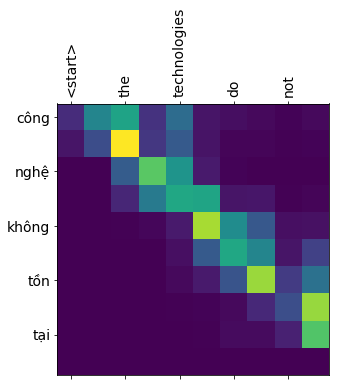


Input:  <start> who is going to invent the technology for the green revolution universities forget about it <end>
Groundtruth:  <start> người nào sẽ sáng chế ra cái công nghệ cho cuộc cách mạng xanh các trường đại học ư quên đi <end>
Translation:  <start> ai sẽ phát minh ra công nghệ cho cuộc cách mạng công nghệ đại học đầu tư hãy quên đi nó <end>
Bleu Score:  60.86956521739131

Input:  <start> government forget about it <end>
Groundtruth:  <start> chính phủ ư quên đi <end>
Translation:  <start> chính phủ quên mất nó <end>
Bleu Score:  71.42857142857143


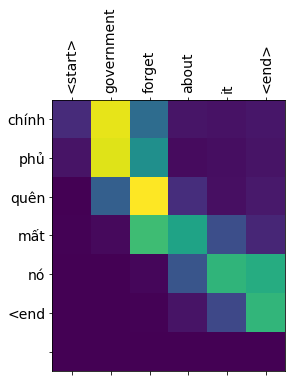


Input:  <start> it will be entrepreneurs and theyre doing it now <end>
Groundtruth:  <start> đó sẽ là các danh nhân và họ đang thực hiện điều đó ngay hiện nay <end>
Translation:  <start> nó sẽ là một nhà kinh doanh và chúng đang làm việc này <end>
Bleu Score:  32.749230123119276

Input:  <start> theres a lovely story that i read in a futurist magazine many many years ago <end>
Groundtruth:  <start> có một câu chuyện rất vui mà tôi đọc được trên một tờ tạp chí vị lai nhiều năm về trước <end>
Translation:  <start> có một câu chuyện rất tuyệt vời mà tôi đọc trong một tạp chí rất nhiều năm trước <end>
Bleu Score:  68.85663811400462

Input:  <start> there was a group of experts who were invited to discuss the future of the city of new york in 1860 <end>
Groundtruth:  <start> có một nhóm chuyên gia được mời đến để thảo luận về tương lai của thành phố new york năm 1860 <end>
Translation:  <start> có một nhóm chuyên gia được mời đến thảo luận về tương lai của thành phố new york vào năm 1995 <

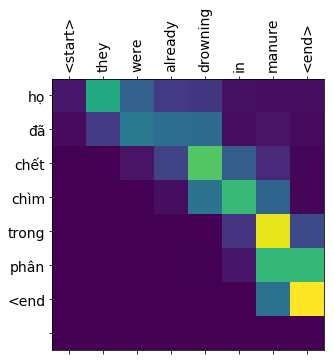


Input:  <start> so 1860 they are seeing this dirty technology that is going to choke the life out of new york <end>
Groundtruth:  <start> vậy nên vào năm 1860 họ nhìn thấy cái công nghệ nhem nhuốc này cái mà làm cho cuộc sống ở thành phố new york ngộp thở <end>
Translation:  <start> năm 1985 họ đang thấy những công nghệ xanh này sẽ bị tổn hại cả đời sống new york <end>
Bleu Score:  35.78721261630681

Input:  <start> so what happens in 40 years time in the year 1900 in the united states of america there were 1 001 car manufacturing companies 1 001 <end>
Groundtruth:  <start> vậy điều gì đã xảy ra trong vòng 40 năm tới thời điểm 1900 tại mỹ có khoảng 1 001 công ty sản xuất xe hơi 1 001 <end>
Translation:  <start> vậy thì điều gì xảy ra 40 năm trước năm 1900 ở mỹ ở mỹ có 1 cái xe đạp siêu sao thổ <end>
Bleu Score:  45.84892217236699

Input:  <start> the idea of finding a different technology had absolutely taken over and there were tiny tiny little factories in backwaters <end>
Groundtru

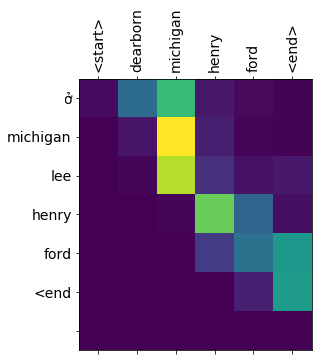


Input:  <start> however there is a secret to work with entrepreneurs <end>
Groundtruth:  <start> tuy nhiên có một bí mật để làm việc với các doanh nhân <end>
Translation:  <start> tuy nhiên có một bí mật để làm việc với doanh nhân <end>
Bleu Score:  93.10627797040229

Input:  <start> first you have to offer them confidentiality <end>
Groundtruth:  <start> trước tiên bạn phải mang đến cho họ sự bảo mật <end>
Translation:  <start> đầu tiên bạn phải trả lời họ <end>
Bleu Score:  42.74535922866364


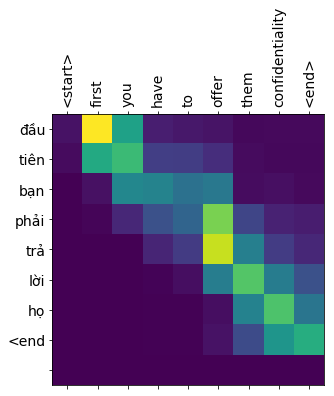


Input:  <start> otherwise they dont come and talk to you <end>
Groundtruth:  <start> không thì họ sẽ chẳng tìm đến mà nói chuyện với bạn <end>
Translation:  <start> nếu không có họ không đến và nói chuyện với các bạn <end>
Bleu Score:  64.28571428571429

Input:  <start> then you have to offer them absolute dedicated passionate service to them <end>
Groundtruth:  <start> sau đó bạn phải mang đến cho họ một dịch vụ tuyệt đối riêng biệt và say mê <end>
Translation:  <start> rồi bạn phải đưa cho họ yêu cầu hoàn toàn thương mại cho họ <end>
Bleu Score:  29.20502936517768

Input:  <start> and then you have to tell them the truth about entrepreneurship <end>
Groundtruth:  <start> và sau đó bạn phải nói với họ sự thật về kinh doanh <end>
Translation:  <start> và rồi bạn phải nói với họ là sự thật về kinh doanh <end>
Bleu Score:  86.66666666666667

Input:  <start> the smallest company the biggest company has to be capable of doing three things beautifully the product that you want to sell has 

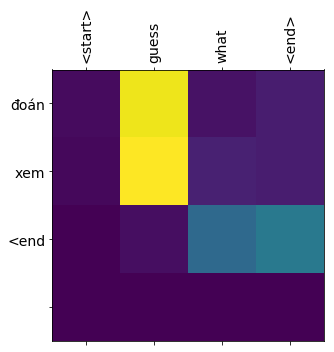


Input:  <start> we have never met a single human being in the world who can make it sell it and look after the money <end>
Groundtruth:  <start> chúng ta chưa bao giờ gặp một cá nhân nào trên thế giới người mà vừa có thể làm ra bán nó và quản lí tiền bạc cùng lúc <end>
Translation:  <start> chúng ta chưa bao giờ gặp một con người trong thế giới có thể làm cho nó bán nó và nhìn vào tiền <end>
Bleu Score:  59.78371744105806

Input:  <start> it doesnt exist <end>
Groundtruth:  <start> điều đó không tồn tại <end>
Translation:  <start> nó không tồn tại <end>
Bleu Score:  70.5401437408845


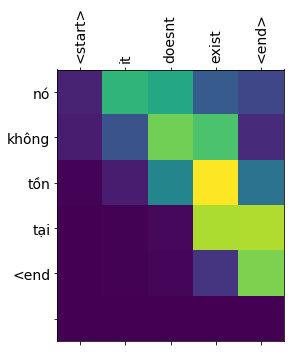


Input:  <start> this person has never been born <end>
Groundtruth:  <start> nhân vật này chưa bao giờ được sinh ra <end>
Translation:  <start> người này chưa bao giờ được sinh ra <end>
Bleu Score:  81.43536762323636


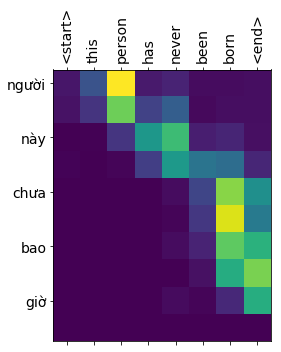


Input:  <start> weve done the research and we have looked at the 100 iconic companies of the world carnegie westinghouse edison ford all the new companies google yahoo <end>
Groundtruth:  <start> chúng tôi đã làm một nghiên cứu và xem xét 100 công ty tiêu biểu trên thế giới carnegie westinghouse edison ford tất cả công ty mới google yahoo <end>
Translation:  <start> chúng tôi đã làm việc nghiên cứu và chúng tôi đã nhìn vào một công ty mới nhất định thế giới <end>
Bleu Score:  46.057936088987375

Input:  <start> theres only one thing that all the successful companies in the world have in common only one none were started by one person <end>
Groundtruth:  <start> chỉ có một điều mà tất cả mọi công ty thành công trên thế giới đều có chỉ một mà thôi đó là không một công ty nào bắt đầu chỉ với một người <end>
Translation:  <start> chỉ có một điều duy nhất thành công trong thế giới có một trong một điều mà chúng ta bắt đầu từ người <end>
Bleu Score:  43.794476633653616

Input:  <start> now 

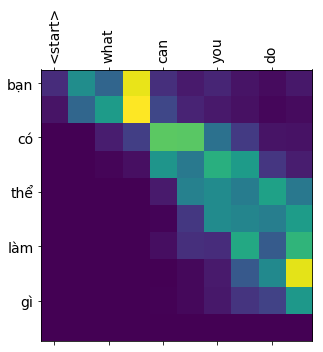


Input:  <start> okay can you sell it can you look after the money <end>
Groundtruth:  <start> okay bạn có thể bán nó không bạn có thể quản lí tiền bạc không <end>
Translation:  <start> được rồi bạn có thể bán nó có thể nhìn thấy tiền <end>
Bleu Score:  57.651267643242086

Input:  <start> quot oh no i cannot do this would you like me to find you somebody <end>
Groundtruth:  <start> quot oh không tôi không thể làm được điều này bạn có muốn tôi tìm ai khác cho bạn không <end>
Translation:  <start> quot ồ không tôi không thể làm được điều này tôi có thể tôi có thể tôi có thể tôi tìm được một người khác <end>
Bleu Score:  55.55555555555556

Input:  <start> we activate communities <end>
Groundtruth:  <start> chúng tôi kích hoạt những cộng đồng <end>
Translation:  <start> chúng ta kích hoạt các cộng đồng <end>
Bleu Score:  77.77777777777779


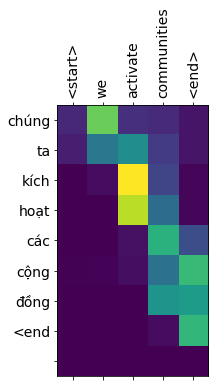


Input:  <start> we have groups of volunteers supporting the enterprise facilitator to help you to find resources and people and we have discovered that the miracle of the intelligence of local people is such that you can change the culture and the economy of this community just by capturing the passion the energy and imagination of your own people <end>
Groundtruth:  <start> chúng tôi có những nhóm tình nguyện viên trợ giúp cho enterprise facilitator họ giúp tìm kiếm những nguồn tài nguyên và con người và chúng tôi khám phá ra rằng cái phép lạ từ trí thông minh của người bản địa như cái gì đó giống như là bạn có thể thách thức nền văn hoá và kinh tế của cộng đồng này chỉ bằng cách nắm được cái khát vọng nguồn năng lượng và trí tưởng tượng như thể của người dân của bạn <end>
Translation:  <start> chúng tôi có những nhóm tình nguyện ủng hộ trợ doanh nghiệp nhân tạo để giúp đỡ bạn tìm ra các nguồn lực và mọi người và chúng tôi đã khám phá ra văn hoá và sức mạnh mẽ của người dân <end>
Ble

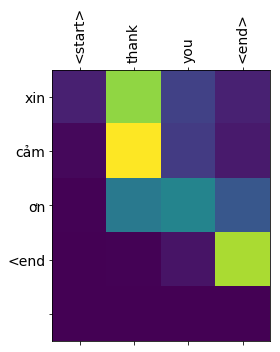


Input:  <start> before march 2011 i was a photographic retoucher based in new york city <end>
Groundtruth:  <start> cho đến tháng ba 2011 tôi làm thợ chỉnh sửa ảnh tại thành phố new york <end>
Translation:  <start> trước năm 2011 tôi sinh ra một nhiếp ảnh hưởng từ new york <end>
Bleu Score:  38.20743514363916

Input:  <start> were pale gray creatures <end>
Groundtruth:  <start> chúng tôi là những sinh vật xanh xao <end>
Translation:  <start> chúng ta đang suy nghĩ về những sinh vật xám <end>
Bleu Score:  50.0

Input:  <start> we hide in dark windowless rooms and generally avoid sunlight <end>
Groundtruth:  <start> ẩn trong bóng tối căn phòng không cửa sổ và nói chung là tránh ánh nắng mặt trời <end>
Translation:  <start> chúng ta lẩn trốn trong phòng ngoại ô và những vết thương ánh sáng mặt trời <end>
Bleu Score:  39.77063630286087

Input:  <start> we make skinny models skinnier perfect skin more perfect and the impossible possible and we get criticized in the press all the time but s

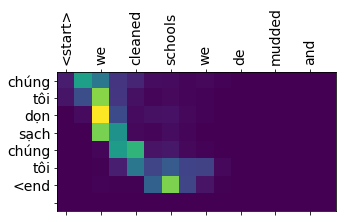


Input:  <start> we cleared tons and tons of stinking rotting fish carcasses from the local fish processing plant <end>
Groundtruth:  <start> chúng tôi dọn sạch hàng tấn xác cá mục nát và hôi thối từ nhà máy chế biến cá tại địa phương <end>
Translation:  <start> chúng tôi đã làm sạch và hàng tấn hàng của con cá voi essex từ hạt nhân địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa phương và địa
Bleu Score:  18.0327868852459

Input:  <start> we got dirty and we loved it <end>
Groundtruth:  <start> chúng tôi lem luốc nhưng ai cũng vui <end>
Translation:  <start> chúng tôi có màu bẩn thỉu và yêu thích nó <end>
Bleu Score:  33.33333333333333

Input:  <start> for weeks all the volunteers and locals alike had been finding similar things <end>
Groundtruth:  <start> trong nhiều tuần các tình nguyện viên và người dân địa phương cùng tìm kiếm một thứ <end>
Tran

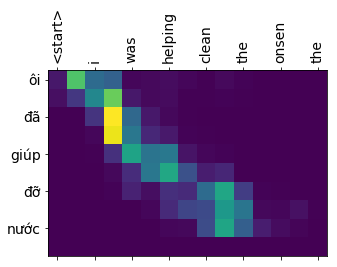


Input:  <start> this happened to also be a place in the town where the evacuation center was collecting the photos <end>
Groundtruth:  <start> nơi đây cũng là nơi mà trung tâm di tản đã thu thập các bức ảnh <end>
Translation:  <start> điều này xảy ra ở chỗ ở thành phố nơi mà nó đã đặt các bức ảnh <end>
Bleu Score:  42.10526315789473

Input:  <start> this is where people were handing them in and i was honored that day that they actually trusted me to help them start hand cleaning them <end>
Groundtruth:  <start> đây là nơi người dân bàn giao chúng và hôm đó tôi lấy làm vinh dự vì họ tin tưởng tôi cho phép tôi giúp họ lau sạch các bức ảnh <end>
Translation:  <start> đây là nơi mà họ đang phân bố và tôi đã rất vinh dự khi họ đã tin tưởng tôi phải giúp đỡ họ bắt tay và lau dọn sạch <end>
Bleu Score:  51.49051558155578

Input:  <start> now it was emotional and it was inspiring and ive always heard about thinking outside the box but it wasnt until i had actually gotten outside of my box tha

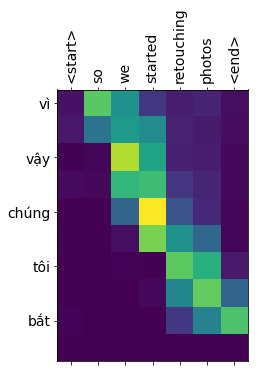


Input:  <start> this was the very first <end>
Groundtruth:  <start> đây là tấm đầu tiên <end>
Translation:  <start> đây là cái đầu tiên <end>
Bleu Score:  85.71428571428571


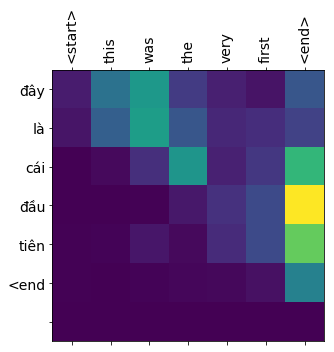


Input:  <start> not terribly damaged but where the water had caused that discoloration on the girls face had to be repaired with such accuracy and delicacy <end>
Groundtruth:  <start> không bị hư hỏng trầm trọng nhưng chỗ bị thấm nước khiến đổi màu khuôn mặt cô gái phải được sửa chữa với độ chính xác và tinh vi cao <end>
Translation:  <start> không có bị phá huỷ nhưng nơi mà nước có gây ra điều đó ở trên giường bệnh này có thể sửa chữa trị một cách rõ ràng và tốt <end>
Bleu Score:  28.125

Input:  <start> otherwise that little girl isnt going to look like that little girl anymore and surely thats as tragic as having the photo damaged <end>
Groundtruth:  <start> nếu không bé gái trong hình sẽ không còn trông giống em nữa và chắc chắn điều đó cũng tồi tệ như việc tấm ảnh bị hư hại vậy <end>
Translation:  <start> nếu không một cô bé gái sẽ không nhìn nó trông giống như thế này nữa và chắc chắn là như là ảnh hưởng bị hư hỏng <end>
Bleu Score:  57.93261916417589

Input:  <start> over time 

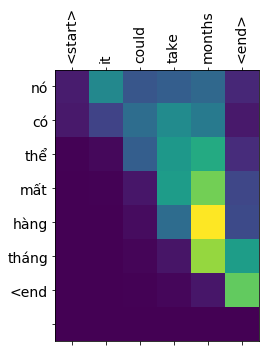


Input:  <start> the kimono in this shot pretty much had to be hand drawn or pieced together picking out the remaining parts of color and detail that the water hadnt damaged <end>
Groundtruth:  <start> chiếc kimono trong bức ảnh này gần như phải được vẽ lại bằng tay hoặc chắp ghép từ các phần màu sắc và chi tiết còn lại chưa bị nước làm hư hại <end>
Translation:  <start> phụ nữ trung bình này đã bị lôi cuốn và hay không gian khác nhau và những chi tiết khác không phải bị huỷ hoại <end>
Bleu Score:  22.031617161656484

Input:  <start> it was very time consuming <end>
Groundtruth:  <start> nó rất tốn thời gian <end>
Translation:  <start> thời gian rất nhiều thời gian <end>
Bleu Score:  62.5


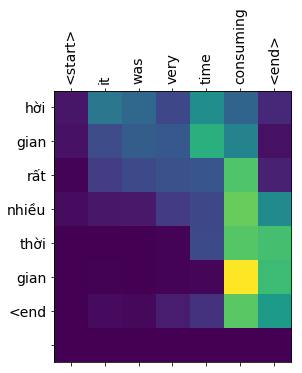


Input:  <start> now all these photos had been damaged by water submerged in salt water covered in bacteria in sewage sometimes even in oil all of which over time is going to continue to damage them so hand cleaning them was a huge part of the project <end>
Groundtruth:  <start> bấy giờ tất cả những hình ảnh này đã bị nước làm hư hại bị nhấn chìm trong nước muối bị bao phủ bởi vi khuẩn trong nước thải đôi khi cả trong dầu suốt một quãng thời gian nên chúng sẽ tiếp tục thêm hư hại thế nên lau sạch chúng là một phần rất lớn của dự án <end>
Translation:  <start> tất cả những bức ảnh này đã bị phá huỷ bởi nước muối từ nước trong các vi khuẩn trong khi vi khuẩn đó là tiếp tục làm tổn thương chúng ta có một phần lớn của dự án <end>
Bleu Score:  42.380944002928686

Input:  <start> we couldnt retouch the photo unless it was cleaned dry and reclaimed <end>
Groundtruth:  <start> chúng tôi không thể chỉnh sửa nếu ảnh không được làm sạch phơi khô và cải tạo <end>
Translation:  <start> chúng ta khô

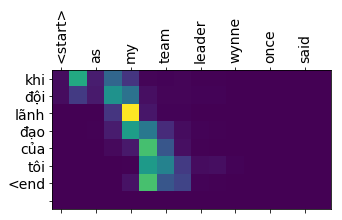


Input:  <start> you dont get a chance to mess it up <end>
Groundtruth:  <start> bạn không có cơ hội phạm sai lầm <end>
Translation:  <start> bạn không có cơ hội để làm hỏng nó <end>
Bleu Score:  63.63636363636363

Input:  <start> the lady who brought us these photos was lucky as far as the photos go <end>
Groundtruth:  <start> người phụ nữ mang cho chúng tôi những tấm ảnh này đã gặp may khi chúng có thể được phục hồi đến vậy <end>
Translation:  <start> người phụ nữ mang chúng tôi những tấm hình này rất may mắn như những bức ảnh <end>
Bleu Score:  49.89351780435818

Input:  <start> she had started hand cleaning them herself and stopped when she realized she was doing more damage <end>
Groundtruth:  <start> cô ấy đã tự lau sạch chúng và dừng lại khi nhận ra mình đang làm nó bị hư hại nhiều hơn <end>
Translation:  <start> cô ấy bắt đầu dọn dẹp sạch và họ dừng lại khi bà ấy nhận ra cô ấy đang làm việc làm tổn thương hơn <end>
Bleu Score:  51.85185185185185

Input:  <start> she also had du

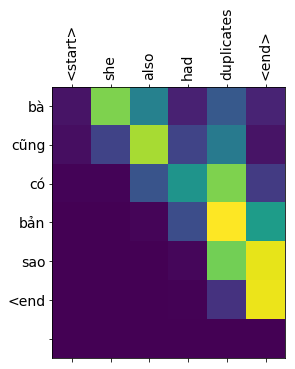


Input:  <start> areas like her husband and her face which otherwise would have been completely impossible to fix we could just put them together in one good photo and remake the whole photo <end>
Groundtruth:  <start> nếu không những chỗ như chồng và khuôn mặt cô sẽ không bao giờ có thể được khắc phục chỉ có thể đặt họ gần nhau trong một bức ảnh lành khác và làm lại toàn bộ bức hình <end>
Translation:  <start> những khu vực như chồng chồng và bà ấy và nói chuyện đó có thể sẽ không thể sửa chữa chúng với một trong một bức ảnh đẹp và sửa lại bức ảnh <end>
Bleu Score:  43.32653699743395

Input:  <start> when she collected the photos from us she shared a bit of her story with us <end>
Groundtruth:  <start> khi nhận lại các bức ảnh từ chúng tôi cô ấy đã chia sẻ một chút câu chuyện của mình <end>
Translation:  <start> khi cô ấy thu thập những bức ảnh từ những gì tôi từ một câu chuyện với bà <end>
Bleu Score:  54.290245082157575

Input:  <start> her photos were found by her husbands colleagu

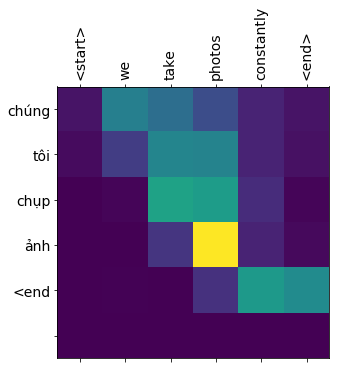


Input:  <start> a photo is a reminder of someone or something a place a relationship a loved one <end>
Groundtruth:  <start> mỗi bức ảnh gợi nhắc về ai đó hoặc một cái gì đó một nơi một mối quan hệ một người thân yêu <end>
Translation:  <start> một bức ảnh là một sự nhắc nhở của một ai đó là một nơi nào đó là một nơi mà một mối quan hệ tình yêu <end>
Bleu Score:  58.620689655172406

Input:  <start> theyre our memory keepers and our histories the last thing we would grab and the first thing youd go back to look for <end>
Groundtruth:  <start> chúng là những vật lưu giữ kỉ niệm và câu chuyện của chúng ta là điều cuối cùng chúng ta còn bám víu lấy và cũng là thứ đầu tiên ta quay lại kiếm tìm <end>
Translation:  <start> chúng là ký ức và lịch sử của lịch sử của chúng tôi và lịch sử của chúng tôi và lịch sử của chúng tôi chúng ta sẽ đặt và điều đầu tiên bạn sẽ quay trở lại <end>
Bleu Score:  37.5

Input:  <start> thats all this project was about about restoring those little bits of humanit

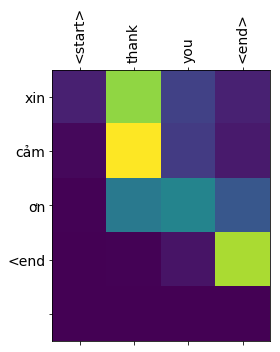


Input:  <start> im 150 feet down an illegal mine shaft in ghana <end>
Groundtruth:  <start> tôi ở độ sâu gần 50m dưới 1 hầm mỏ bất hợp pháp tại ghana <end>
Translation:  <start> tôi 150 feet xuống một công nghiệp y tế ở ghana <end>
Bleu Score:  28.27467233044941

Input:  <start> the air is thick with heat and dust and its hard to breathe <end>
Groundtruth:  <start> không khí đặc quánh bụi và hơi nóng và rất khó thở <end>
Translation:  <start> không khí dày đặc và nhiệt và nó rất khó để thở <end>
Bleu Score:  71.42857142857143

Input:  <start> i can feel the brush of sweaty bodies passing me in the darkness but i cant see much else <end>
Groundtruth:  <start> tôi có thể cảm nhận sự va chạm từ những thân thể bóng nhẫy mồ hôi lướt qua trong bóng tối nhưng chẳng thể thấy gì hơn <end>
Translation:  <start> tôi có thể cảm thấy những cái răng mồ hôi những người ta có thể đi qua tôi trong bóng tối nhưng tôi không thể thấy được nhiều <end>
Bleu Score:  56.666666666666664

Input:  <start> i hea

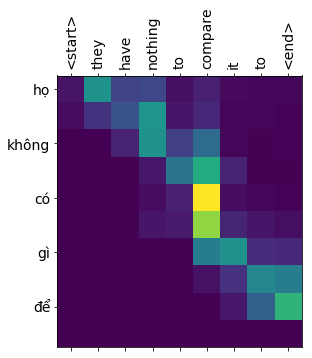


Input:  <start> when these villagers claimed their freedom the slaveholders burned down all of their houses <end>
Groundtruth:  <start> khi người dân làng này đòi tự do những chủ nô đốt sạch nhà của họ <end>
Translation:  <start> khi những người dân dân israel sự tự do của họ <end>
Bleu Score:  52.36249217872195

Input:  <start> i mean these people had nothing and they were so petrified they wanted to give up but the woman in the center rallied for them to persevere and abolitionists on the ground helped them get a quarry lease of their own so that now they do the same back breaking work but they do it for themselves and they get paid for it and they do it in freedom <end>
Groundtruth:  <start> những người này không có gì họ chết điếng họ muốn đầu hàng nhưng người phụ nữ ở giữa trấn tĩnh và kêu gọi mọi người kiên trì và những người theo chủ nghĩa bãi nô tại hiện trường giúp họ lấy được hợp đồng cho thuê mỏ đá của chính mình để giờ đây họ vẫn làm công việc gãy lưng ấy nhưng làm cho chí

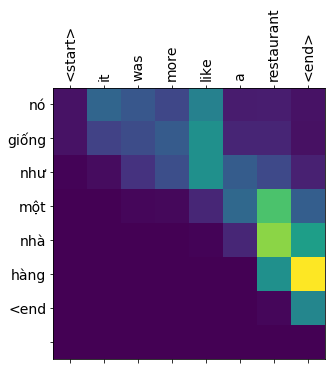


Input:  <start> cabin restaurants as theyre known in the trade are venues for forced prostitution <end>
Groundtruth:  <start> những nhà hàng phân buồng như được biết đến trong ngành là những địa điểm của nạn mại dâm cưỡng ép <end>
Translation:  <start> nhà hàng như họ được biết trong ngành thương mại là những vụ kiện cho việc buôn bán dâm mại dâm <end>
Bleu Score:  56.52173913043478

Input:  <start> each has small private rooms where the slaves women along with young girls and boys some as young as seven years old are forced to entertain the clients encouraging them to buy more food and alcohol <end>
Groundtruth:  <start> mỗi nơi có phòng riêng nhỏ nơi các nô lệ phụ nữ cùng trẻ em trai và gái một số mới 7 tuổi bị buộc giải khuây cho khách hàng dụ họ mua thêm rượu và đồ ăn <end>
Translation:  <start> mỗi người có một căn phòng riêng biệt nơi mà người phụ nữ ở những phụ nữ trẻ em bé và những đứa trẻ nhỏ như 7 tuổi trẻ bị già để buộc phải mua những thức ăn kiêng với họ tham gia mua những

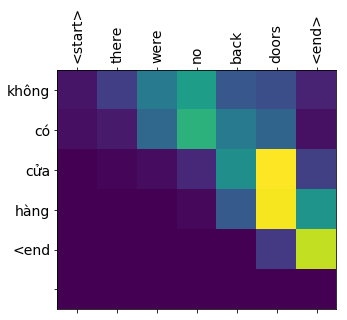


Input:  <start> there were no windows large enough to climb through <end>
Groundtruth:  <start> chẳng có cửa sổ đủ lớn mà chui lọt <end>
Translation:  <start> không có cửa sổ đủ lớn để leo lên <end>
Bleu Score:  63.63636363636363

Input:  <start> these people have no escape at all and as we take in such a difficult subject its important to note that slavery including sex trafficking occurs in our own backyard as well <end>
Groundtruth:  <start> những người này không có lối thoát nào khi ta đề cập về chủ đề khó khăn như thế cần nhớ rằng nô lệ bao gồm nô lệ của nạn mua bán tình dục cũng xảy ra tại nơi chúng ta đang sống <end>
Translation:  <start> những người này không có ai thoát khỏi những gì và chúng ta lấy một tình huống khó khăn để quan trọng mà giờ là tình dục an ninh ở nơi chúng tôi <end>
Bleu Score:  32.206169703226536

Input:  <start> tens of hundreds of people are enslaved in agriculture in restaurants in domestic servitude and the list can go on <end>
Groundtruth:  <start> hà

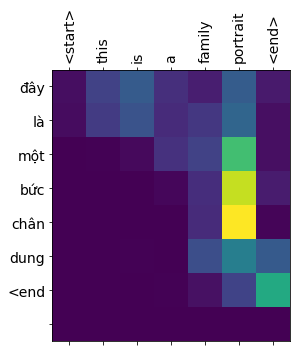


Input:  <start> the dyed black hands are the father while the blue and red hands are his sons <end>
Groundtruth:  <start> đôi tay nhuộm đen là người cha những bàn tay xanh và đỏ là con trai ông ấy <end>
Translation:  <start> tên là màu đen là người cha và trong màu xanh lá cây này là con trai của ông <end>
Bleu Score:  57.14285714285714

Input:  <start> they mix dye in these big barrels and they submerge the silk into the liquid up to their elbows but the dye is toxic <end>
Groundtruth:  <start> họ trộn thuốc nhuộm trong những thùng lớn và nhúng lụa vào dung dịch đó ngập đến khuỷ tay dù thuốc nhuộm rất độc <end>
Translation:  <start> chúng trộn lẫn với các thùng dầu và chúng va vào lụa vào chất lỏng vào mũi lên nhưng mũi bột là chất độc <end>
Bleu Score:  30.769230769230766

Input:  <start> my interpreter told me their stories <end>
Groundtruth:  <start> người phiên dịch của tôi kể chuyện của họ <end>
Translation:  <start> phiên dịch của tôi kể chuyện của họ <end>
Bleu Score:  90.4837

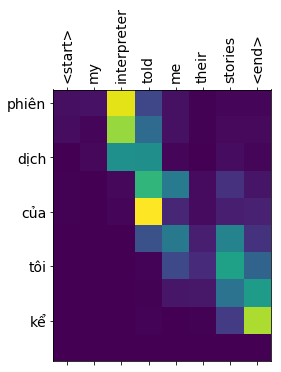


Input:  <start> quot we have no freedom they said <end>
Groundtruth:  <start> họ nói chúng tôi không có tự do <end>
Translation:  <start> quot chúng ta không có tự do họ nói <end>
Bleu Score:  81.81818181818183

Input:  <start> quot we hope still though that we could leave this house someday and go someplace else where we actually get paid for our dyeing <end>
Groundtruth:  <start> nhưng vẫn hi vọng ngày nào đó có thể rời khỏi căn nhà này và đi nơi khác nơi chúng tôi được trả công nhuộm vải <end>
Translation:  <start> quot chúng tôi hi vọng rằng chúng tôi có thể rời khỏi một ngày một ngày nào đó chúng tôi thực sự được trả tiền từ trên bản đồ <end>
Bleu Score:  48.38709677419355

Input:  <start> its estimated that more than 4 000 children are enslaved on lake volta the largest man made lake in the world <end>
Groundtruth:  <start> ước lượng rằng có hơn 4 000 trẻ em đang làm nô lệ ở hồ volta chiếc hồ nhân tạo lớn nhất thế giới <end>
Translation:  <start> ước tính được khoảng hơn 4000 tr

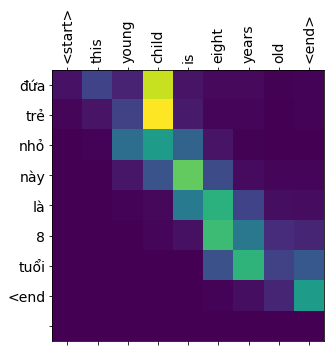


Input:  <start> he was trembling when our boat approached frightened it would run over his tiny canoe <end>
Groundtruth:  <start> em run rẩy khi thuyền của chúng tôi đến gần cứ sợ thuyền đè qua cái canoe bé xíu của em <end>
Translation:  <start> ông ta lắc đầu của chúng tôi tiếp tục hoảng sợ nó sẽ chạy trong những chiếc xuồng nhỏ của ông <end>
Bleu Score:  30.43478260869566

Input:  <start> he was petrified he would be knocked in the water <end>
Groundtruth:  <start> cậu bé khiếp đảm vì sợ rơi xuống nước <end>
Translation:  <start> ông chết đuối ông ấy bị ngã trong nước <end>
Bleu Score:  27.27272727272727

Input:  <start> the skeletal tree limbs submerged in lake volta often catch the fishing nets and weary frightened children are thrown into the water to untether the lines <end>
Groundtruth:  <start> những cành cây gãy tụ vào hồ volta thường vướng vào lưới đánh cá và những đứa trẻ vừa mệt lử vừa sợ hãi bị đẩy xuống nước để gỡ lưỡi câu <end>
Translation:  <start> xương vật thể được n

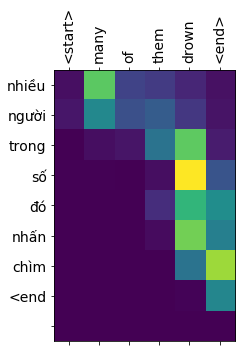


Input:  <start> for as long as he can recall hes been forced to work on the lake <end>
Groundtruth:  <start> những gì cậu bé nhớ được là em bị bắt làm việc ở hồ <end>
Translation:  <start> với khoảng thời gian dài như ông ấy đã bắt đầu làm việc ở trên hồ <end>
Bleu Score:  38.88888888888889

Input:  <start> terrified of his master he will not run away and since hes been treated with cruelty all his life he passes that down to the younger slaves that he manages <end>
Groundtruth:  <start> quá sợ người chủ em không dám chạy trốn và vì bị đối xử tàn tệ từ nhỏ em tiếp diễn điều đó xuống những nô lệ nhỏ hơn mà em quản lý <end>
Translation:  <start> sợ hãi ông ta sẽ không chạy trốn khỏi đó ông đã được chữa trị độc hại của cuộc đời ông ấy đã vượt qua đó là nô lệ lâu đời ông ấy <end>
Bleu Score:  25.71428571428571

Input:  <start> i met these boys at five in the morning when they were hauling in the last of their nets but they had been working since 1 a m <end>
Groundtruth:  <start> tôi gặp n

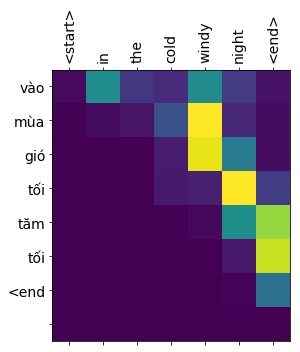


Input:  <start> and its important to note that these nets weigh more than a thousand pounds when theyre full of fish <end>
Groundtruth:  <start> cần lưu ý rằng những chiếc lưới này nặng gần 500kgs khi chúng đầy cá <end>
Translation:  <start> và quan trọng để ý nghĩa với những chiếc điện toán này hơn 1000 pound khi chúng là cá <end>
Bleu Score:  42.857142857142854

Input:  <start> i want to introduce you to kofi <end>
Groundtruth:  <start> tôi muốn giới thiệu kofi với bạn <end>
Translation:  <start> tôi muốn giới thiệu với các bạn phải vò đầu <end>
Bleu Score:  66.66666666666666

Input:  <start> kofi was rescued from a fishing village <end>
Groundtruth:  <start> kofi được cứu từ 1 làng chài <end>
Translation:  <start> kofi annan đã được giải cứu một làng đánh bắt cá <end>
Bleu Score:  46.15384615384615

Input:  <start> i met him at a shelter where free the slaves rehabilitates victims of slavery <end>
Groundtruth:  <start> tôi gặp cậu bé ở khu cứu trợ mà tổ chức giải phóng nô lệ phục h

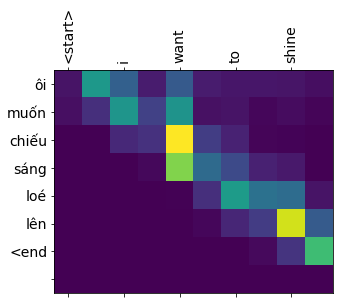


Input:  <start> when i was working in the field i brought lots of candles with me and with the help of my interpreter i imparted to the people i was photographing that i wanted to illuminate their stories and their plight so when it was safe for them and safe for me i made these images <end>
Groundtruth:  <start> khi làm việc trong lãnh vực này tôi mang theo rất nhiều nến với sự giúp đỡ của người phiên dịch tôi truyền đạt với những người mà mình chụp hình rằng tôi muốn soi sáng câu chuyện và hoàn cảnh của họ rồi khi họ và tôi được an toàn tôi chụp những tấm hình này <end>
Translation:  <start> khi tôi làm việc trong lĩnh vực tôi mang rất nhiều cây nến với tôi và với tôi về mặt tôi đã được truyền hình tôi tôi chiếu sáng những câu chuyện của họ và cả chúng ta cảm thấy điều này là vì an toàn và họ cảm thấy tôi <end>
Bleu Score:  55.5997267531427

Input:  <start> they knew their image would be seen by you out in the world <end>
Groundtruth:  <start> họ biết hình của họ sẽ được xem bởi nhữ

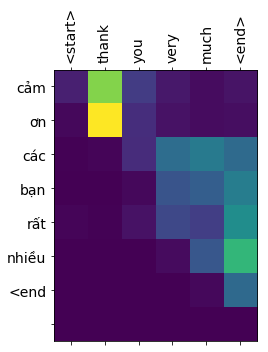

In [58]:
translation_result = []
for i in range(len(pairs_2)):
  en_sentence = pairs_2[i][0].strip("<start>").strip("<end>").strip()
  vi_result, en_sentence, attention_plot = evaluate(en_sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
  vi_result = '<start> ' + vi_result.strip()
  vi_groundtruth = pairs_2[i][1]
  bleu_score = compute_bleu([[vi_groundtruth.split()]], [vi_result.split()], max_order=1)[0]*100
  print('\nInput: ', en_sentence)
  print('Groundtruth: ', vi_groundtruth)
  print('Translation: ', vi_result)
  print('Bleu Score: ', bleu_score)
  if len(vi_result.split(' ')) <= 10:
    attention_plot = attention_plot[:len(vi_result.split(' ')), :len(en_sentence.split(' '))]
    plot_attention(attention_plot, en_sentence.split(' '), vi_result.strip('<start> ').split(' '))
  translation_result.append([en_sentence, vi_groundtruth, vi_result, bleu_score, attention_plot])

**Tính bleu score trung bình trên tập Test:**

In [60]:
bleu_score_list = []
for i in range(len(translation_result)):
  bleu_score_list.append(translation_result[i][3])

mean_bleu_score = sum(bleu_score_list)/len(bleu_score_list)
print("Average Bleu Score: ", mean_bleu_score)

Average Bleu Score:  48.423642764590205
